✅ Comprehensive Data Science Pipeline (Refined)
 

✅ Decide to clip, impute, or flag based on percent of outliers.

🔍 Consider domain knowledge before removing or capping.

5. Missing Value Imputation (First Pass)
✅ Impute easy/immediate columns (e.g., fill 0s, forward fill, or placeholders).

📌 Do not over-impute until after feature engineering.

6. Feature Engineering
✅ Encode categorical features (Label/OneHot/Target). 

✅ Transform skewed distributions if needed.

✅ Combine, bin, or decompose features (ratios, logs, clusters, embeddings).

✅ Create interaction terms or polynomial features if helpful.

7. Impute Missing (Second Pass)
✅ Now that new features exist, re-check and impute again.

✅ Consider predictive imputation (e.g., KNN, model-based).

8. Feature Selection (Optional but important)
🔍 Drop redundant, highly correlated features.

🔍 Use mutual information, importance scores, or recursive elimination.

9. Scaling / Normalization
⚖️ Use StandardScaler, RobustScaler, or QuantileTransformer as needed.

⚠️ Only scale numerical features and not categorical encodings unless required.

10. Model Training
✅ Train linear and tree-based models (e.g., Ridge, Lasso, RF, XGBoost).

✅ Compare with baseline models (e.g., DummyClassifier/Regressor).

11. Model Tuning
✅ Perform GridSearchCV or RandomizedSearchCV.

⚠️ Use cross-validation to avoid overfitting on validation set.

12. Model Evaluation
📊 Compare scores (MAE, RMSE, F1, ROC-AUC, etc.).

🔍 Use validation curve, learning curve, residual plots, SHAP, etc.

13. Finalization
✅ Select best model.

✅ Train on full training data if needed.

✅ Save pipeline (e.g., using joblib, pickle, or sklearn.Pipeline).

✅ Prepare test predictions / deployment.

💡 Extras You Might Consider:
Data leakage check: Ensure no future or target info leaks into features.

Pipelines/ColumnTransformer: Automate your steps in scikit-learn pipeline for reproducibility.

Experiment tracking: Use MLFlow, Weights & Biases, or logs to track model versions and scores.

Documentation: Document feature decisions, data assumptions, etc.

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from scipy.stats import entropy, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error
pd.options.display.max_rows = 1000  

NAME = "Albert_Aina" 
TRAIN = pd.read_csv(f"0_{NAME}_train.csv")
TEST = pd.read_csv(f"0_{NAME}_test.csv")  
RANDOM_STATE = 42
TRAIN_SHAPE, TEST_SHAPE = TRAIN.shape, TEST.shape 
print(f"TRAIN shape: {TRAIN_SHAPE}    TEST shape: {TEST_SHAPE}")
 

TRAIN shape: (20483, 61)    TEST shape: (9453, 60)


<pre>
<em>✅ Data Review & Statistics Inspection including outlier and skew detection</em>  
</pre>

In [3]:
from typing import Optional
from IPython.display import display, Markdown

# Set pandas display option to show up to 1000 rows
pd.options.display.max_rows = 1000

def inspect_dataframe(df: pd.DataFrame, name: Optional[str] = "DataFrame", iqr=(0.25, 0.75), z_thresh=3) -> pd.DataFrame:
    """
    Display key insights about a DataFrame, including null counts, data types,
    memory usage, skewness, z-score range, IQR bounds, and percentage of outlier rows per column.

    Parameters:
        df (pd.DataFrame): The DataFrame to inspect.
        name (str): Optional name to display as the DataFrame identifier.
        iqr (tuple): The lower and upper quantile for IQR calculation (default (0.25, 0.75)).
        z_thresh (float): Threshold for z-score to define outliers (default 3).

    Returns:
        pd.DataFrame: A summary DataFrame with metadata and statistics.
    """
    # Basic metadata
    info_dict = {
        "unique_count": df.nunique(),
        "null_count": df.isnull().sum(),
        "null_%": round(df.isnull().sum() / len(df) * 100, 2),
        "data_type": df.dtypes,
        "memory_usage_mb": round(df.memory_usage(deep=True) / 1_000_000, 2)
    }
    info_df = pd.DataFrame(info_dict)
    info_df.index.name = f"{name}_columns"

    # Display quick summary
    display(Markdown(f"#### {name} Info"))
    print(f"Shape of {name}: {df.shape}")
    print(f"Duplicate rows in {name}: {df.duplicated().sum()}")
    print("\nData Types Count:")
    #print(info_df["data_type"].value_counts())

    # Numerical stats
    numerical = df.select_dtypes(include='number')
    statistics = numerical.describe().T.round(2)

    # Skewness
    skewness = numerical.skew().round(2)
    statistics.insert(statistics.columns.get_loc("std") + 1, "skew", skewness)

    # Z-score bounds
    zscore_bounds = ((numerical - numerical.mean()) / numerical.std()).abs().max().round(2)
    statistics["max_zscore"] = zscore_bounds
 
    # IQR bounds
    Q1 = numerical.quantile(iqr[0])
    Q3 = numerical.quantile(iqr[1])
    IQR = Q3 - Q1
    lower_bounds = Q1 - 1.5 * IQR
    upper_bounds = Q3 + 1.5 * IQR

    # Count outliers
    outlier_counts = ((numerical < lower_bounds) | (numerical > upper_bounds)).sum()
    outlier_percents = (outlier_counts / numerical.shape[0] * 100).round(2)

    # Add to statistics
    statistics["%outlier_by_iqr"] = outlier_percents
    statistics["iqr_bounds"] = list(zip(lower_bounds.round(2), upper_bounds.round(2)))

    # Outlier percentage based on z-score threshold per column
    def outlier_percent_zscore(series, thresh=z_thresh):
        if not np.issubdtype(series.dtype, np.number) or series.std() == 0 or series.isnull().all():
            return np.nan
        z_scores = (series - series.mean()) / series.std()
        return round((z_scores.abs() > thresh).sum() / len(series.dropna()) * 100, 2)

    outlier_percent = numerical.apply(outlier_percent_zscore)
    statistics["%outlier_by_z"] = outlier_percent

    # Combine metadata and statistics
    result_df = pd.concat([info_df, statistics], axis=1)

    return result_df

In [4]:
train_summary = inspect_dataframe(TRAIN, "data")
train_summary

#### data Info

Shape of data: (20483, 61)
Duplicate rows in data: 0

Data Types Count:


,unique_count,null_count,null_%,data_type,memory_usage_mb,count,mean,std,skew,min,25%,50%,75%,max,max_zscore,%outlier_by_iqr,iqr_bounds,%outlier_by_z
0_17_all,144.0,2403.0,11.73,float64,0.16,18080.0,12724.00,9286.40,0.98,411.00,3831.00,12508.00,17354.00,45170.00,3.49,1.51,"(-16453.5, 37638.5)",1.71
Index,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
__churn,2.0,0.0,0.00,int64,0.16,20483.0,0.16,0.37,1.84,0.00,0.00,0.00,0.00,1.00,2.28,16.14,"(0.0, 0.0)",0.00
__price_doc,5888.0,0.0,0.00,float64,0.16,20483.0,6.81,4.53,4.83,0.10,4.55,6.00,7.90,111.11,23.03,6.51,"(-0.48, 12.92)",1.41
avg_open_to_buy,18635.0,0.0,0.00,float64,0.16,20483.0,7200.62,7812.28,1.66,3.00,1777.00,3846.70,9683.35,34516.00,3.50,7.93,"(-10082.53, 21542.88)",2.53
avg_utilization_ratio,937.0,0.0,0.00,float64,0.16,20483.0,0.27,0.25,0.68,0.00,0.06,0.19,0.47,1.00,2.95,0.00,"(-0.55, 1.08)",0.00
big_market_raion,2.0,0.0,0.00,object,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
big_road1_1line,2.0,0.0,0.00,object,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
build_count_mix,9.0,3063.0,14.95,float64,0.16,17420.0,0.58,1.55,3.37,0.00,0.00,0.00,0.00,9.00,5.42,16.55,"(0.0, 0.0)",1.85
build_count_wood,34.0,3063.0,14.95,float64,0.16,17420.0,41.69,128.33,4.18,0.00,0.00,0.00,7.00,793.00,5.85,17.97,"(-10.5, 17.5)",2.93


In [5]:
feature_tag = {
        'temporal': (
            'year', 'month', 'day', 'weekday', 'quarter', 'dayofyear',
            'weekofyear', 'elapsed_days', 'build_year'
        ),
        'cyclical': (
            'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'
        ),
        'demographic': (
            'gender', 'education_level', 'income_category', 'marital_status',
            'customer_age', 'dependent_count'
        ),
        'property': (
            'floor', 'full_sq', 'life_sq', 'num_room',
            'max_floor', 'state'
        ),
        'location': (
            'mkad_km', 'metro_km_walk', 'railroad_station_walk_km',
            'public_transport_station_min_walk', 'detention_facility_km'
        ),
        'infrastructure': (
            'big_market_raion', 'culture_objects_top_25',
            'school_education_centers_top_20_raion', 'big_road1_1line',
            'thermal_power_plant_raion', 'radiation_raion',
            'oil_chemistry_raion', 'nuclear_reactor_raion',
            'incineration_raion', 'railroad_1line', 'railroad_terminal_raion',
            'water_1line', 'detention_facility_raion' 
        ),
        'finance': (
            'credit_limit', 'avg_utilization_ratio', 'avg_open_to_buy',
            'total_revolving_bal', 'total_trans_ct', 'total_amt_chng_q4_q1',
            'total_ct_chng_q4_q1', 'months_inactive_12_mon', 'months_on_book',
            'contacts_count_12_mon', 'total_relationship_count',
            'card_category' 
        ),
        'amenities': (
            'leisure_count_3000', 'leisure_count_5000', 'cafe_count_1000_price_1000',
            'cafe_sum_1000_min_price_avg', 'cafe_sum_1500_min_price_avg',
            'sport_count_2000', 'office_sqm_5000'
        ),
        'structure': (
            'build_count_wood', 'build_count_mix'
        ),
        'other': (
            'market_count_1500', 'product_type', 'ecology', 'trc_count_2000'
        )
}




must_be_interpretable = [
    # Spatial / physical dimensions
    'max_floor', 'floor', 'life_sq', 'full_sq', 'office_sqm_5000',
    'railroad_station_walk_km', 'metro_km_walk', 'mkad_km', 'detention_facility_km',
    'build_year', 'num_room',

    # Financial / behavioral metrics
    'credit_limit', 'avg_open_to_buy', 'avg_utilization_ratio',
    'total_trans_amt', 'total_trans_ct', 'total_revolving_bal',
    'months_on_book', 'months_inactive_12_mon', 'dependent_count', 'customer_age',
    'total_amt_chng_q4_q1', 'total_ct_chng_q4_q1', 'total_relationship_count',

    # Encoded categorical or important identifiers
    'product_type', 'card_category', 'income_category',
    'education_level', 'gender', 'marital_status', 'state',

    # Target variables
    '__churn', '__price_doc'
]


<pre>
<em>✅ Helper function visual inspection to view distribution and outliers</em>  
</pre>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import boxcox
import warnings
import pandas as pd

def is_categorical_or_object(series):
    return pd.api.types.is_object_dtype(series) or isinstance(series.dtype, pd.CategoricalDtype)
    
def inspect_visually(dfs, features=None, drop_inf=True):
    """
    For each feature in each DataFrame:
        - If numeric:
            - Left: Histogram + KDE
            - Right: Box-Cox Boxplot
        - If categorical:
            - Left: Horizontal Countplot
            - Right: Box-Cox Boxplot of value counts
    """
    df_names = list(dfs.keys())
    sample_df = next(iter(dfs.values()))

    if features is None:
        features = sample_df.columns.tolist()

    nrows = len(features)
    ncols = 2 * len(dfs)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), constrained_layout=True)

    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes[np.newaxis, :]
    elif ncols == 1:
        axes = axes[:, np.newaxis]

    for i, feature in enumerate(features):
        for j, (df_name, df) in enumerate(dfs.items()):
            ax_left = axes[i, 2 * j]
            ax_right = axes[i, 2 * j + 1]

            if feature not in df.columns:
                ax_left.set_visible(False)
                ax_right.set_visible(False)
                continue

            series = df[feature].copy()
            dtype = series.dtype
            if drop_inf:
                series = series.replace([np.inf, -np.inf], np.nan)
            series = series.dropna()

            if series.empty:
                ax_left.text(0.5, 0.5, "No data", ha='center', va='center')
                ax_right.set_visible(False)
                continue
                
            #if is_categorical_or_object(series): 
            if dtype in ['object', 'category']: 
                print(f'{feature} type {dtype}')
                # --- CATEGORICAL ---
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=FutureWarning)
                        sns.countplot(y=series, order=series.value_counts().index, ax=ax_left)
                    ax_left.set_title(f"{feature} - {df_name} (Countplot)")

                    counts = series.value_counts()
                    count_vals = counts.values.astype(float)

                    if (count_vals <= 0).any() or len(count_vals) < 2:
                        raise ValueError("Box-Cox requires at least 2 positive values")

                    transformed, _ = boxcox(count_vals)
                    sns.boxplot(x=transformed, ax=ax_right, color='orange')
                    ax_right.set_title(f"{feature} - {df_name} (Box-Cox of Counts)")

                except Exception as e:
                    ax_right.text(0.5, 0.5, f"Box-Cox failed\n{str(e)}",
                                  ha='center', va='center', fontsize=9)
                    ax_right.axis('off')
            else: 
                # --- NUMERIC ---
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=FutureWarning)
                        sns.histplot(series, kde=True, ax=ax_left, bins=30, stat='density')
                    ax_left.set_title(f"{feature} - {df_name} (Hist+KDE)")

                    boxcox_series = series[series > 0]
                    if boxcox_series.nunique() < 2:
                        raise ValueError("Not enough unique positive values for Box-Cox")
                    transformed, _ = boxcox(boxcox_series)
                    sns.boxplot(y=transformed, ax=ax_right, color='orange')
                    ax_right.set_title(f"{feature} - {df_name} (Box-Cox Boxplot)")

                except Exception as e:
                    ax_right.text(0.5, 0.5, f"Box-Cox failed\n{str(e)}",
                                  ha='center', va='center', fontsize=9)
                    ax_right.axis('off')
 

    plt.suptitle("Feature Distributions and Box-Cox Transforms", fontsize=18, y=1.02)
    plt.show()

<pre>
<em>✅ Grouping data by distribution and variability</em>  
</pre>

In [7]:
from scipy import stats
from scipy.signal import find_peaks

def group_columns_by_normality(df, alpha=0.05, skew_threshold=1, kurtosis_threshold=3):
    """
    Enhanced version with robust multimodal detection and peak tracking
    """
    groups = {  
        'peaks_info': [],  # Stores (col_name, peak_count)
        'normal': [], 'near_normal': [], 'skewed': [], 
        'heavy_tailed': [], 'multimodal_moderate': [], 'multimodal_extreme': [],
        'non_numeric': [], 'ordinal_multi_rep': [], 'bin_dicho': [], 'constant': [],
        'unknown': []
    }

    def check_multimodal_kde(data):
        """Returns number of peaks or None if analysis fails"""
        from scipy.stats import gaussian_kde
        try:
            clean_data = data.dropna().values
            if len(clean_data) < 8:  # Minimum for meaningful KDE
                return None
                
            kde = gaussian_kde(clean_data)
            x = np.linspace(clean_data.min(), clean_data.max(), 1000)
            y = kde(x)
            peaks, _ = find_peaks(y, height=0.1*y.max())
            return len(peaks)
        except:
            return None

    for col in df.columns:
        
        try:
            data = df[col]
            n_unique = data.nunique()
            peak_count = check_multimodal_kde(data)
            
            
            # 1. Check for constant columns
            if n_unique <= 1:
                groups['constant'].append(col)
                continue
                
            # 2. Check binary
            if n_unique == 2:
                groups['bin_dicho'].append(col)
                continue

            # 3. Non-numeric columns
            if not np.issubdtype(df[col].dtype, np.number):
                groups['non_numeric'].append(col)
                continue
                
            # 4. Low cardinality numeric
            if n_unique < 10:
                groups['ordinal_multi_rep'].append(col)
                continue

            # 5. Full distribution analysis
            clean_data = data.dropna()
            skew = stats.skew(clean_data)
            kurt = stats.kurtosis(clean_data)
            shapiro_p = stats.shapiro(clean_data)[1] if len(clean_data) < 5000 else np.nan
            dagostino_p = stats.normaltest(clean_data)[1]
            
            is_normal = (
                (pd.isna(shapiro_p) or shapiro_p > alpha) and 
                (dagostino_p > alpha) and 
                (abs(skew) < 0.5) and 
                (abs(kurt) < 1)
            )

            # Multimodal analysis
            if peak_count is not None:
                groups['peaks_info'].append((col, peak_count))
                
                if peak_count > 3:
                    groups['multimodal_extreme'].append(col)
                elif peak_count > 1:
                    groups['multimodal_moderate'].append(col) 
                elif is_normal:
                    groups['normal'].append(col)
                elif abs(skew) >= skew_threshold:
                    groups['skewed'].append(col)
                elif abs(kurt) >= kurtosis_threshold:
                    groups['heavy_tailed'].append(col)
                else:
                    groups['near_normal'].append(col)
            else:
                # Fallback if KDE fails
                if is_normal:
                    groups['normal'].append(col)
                elif abs(skew) >= skew_threshold:
                    groups['skewed'].append(col)
                elif abs(kurt) >= kurtosis_threshold:
                    groups['heavy_tailed'].append(col)
                else:
                    groups['near_normal'].append(col)
                    
        except Exception as e:
            print(f"Error processing {col}: {str(e)}")
            groups['unknown'].append(col)

    # Validation
    classified = sum(len(v) for v in groups.values() if isinstance(v, list))
    if classified != len(df.columns):
        missing = set(df.columns) - set().union(*[v for v in groups.values() if isinstance(v, list)])
        groups['unknown'].extend(missing)
        
    return groups
distribution = group_columns_by_normality(TRAIN)  

In [8]:
distribution['peaks_info']

[('max_floor', 6),
 ('total_revolving_bal', 4),
 ('leisure_count_3000', 1),
 ('total_ct_chng_q4_q1', 1),
 ('railroad_station_walk_km', 2),
 ('0_17_all', 4),
 ('trc_count_2000', 2),
 ('build_count_wood', 1),
 ('credit_limit', 1),
 ('total_trans_ct', 2),
 ('leisure_count_5000', 1),
 ('life_sq', 1),
 ('cafe_count_1000_price_1000', 1),
 ('mkad_km', 3),
 ('avg_utilization_ratio', 3),
 ('public_transport_station_min_walk', 1),
 ('customer_age', 1),
 ('detention_facility_km', 3),
 ('sport_count_2000', 2),
 ('cafe_sum_1000_min_price_avg', 4),
 ('total_amt_chng_q4_q1', 1),
 ('metro_km_walk', 2),
 ('office_sqm_5000', 1),
 ('total_trans_amt', 3),
 ('cafe_sum_1500_min_price_avg', 4),
 ('floor', 2),
 ('num_room', 3),
 ('months_on_book', 2),
 ('avg_open_to_buy', 1),
 ('build_year', 0),
 ('full_sq', 1),
 ('__price_doc', 1)]

In [9]:
for col in distribution.keys():
    if 'build_year' in distribution[col]:
        print(col)

skewed


In [10]:
data_dict = {}

In [11]:
constant = TRAIN[[col for col in distribution['constant']]]
if len(constant.columns):
    inspect_visually(
    dfs={"Train": TRAIN ,  "Test": TEST},
    features=binary.columns
        )  
    data_dict['constant'] = constant.columns.tolist()

In [12]:
bin_dicho = TRAIN[[col for col in distribution['bin_dicho']]]
valid_bin = {'yes', 'no', '1', '0', 'true', 'false', 't', 'f', 'y', 'n'}
 
bin_dicho_str = bin_dicho.astype(str) 
binary_cols = [
    col for col in bin_dicho_str.columns 
    if bin_dicho_str[col].str.lower().str.strip().isin(valid_bin).all()
]
 
binary = bin_dicho[binary_cols]
dichotomous = bin_dicho[[col for col in bin_dicho.columns if col not in binary.columns]]

big_market_raion type object
big_market_raion type object
water_1line type object
water_1line type object
culture_objects_top_25 type object
culture_objects_top_25 type object
big_road1_1line type object
big_road1_1line type object
thermal_power_plant_raion type object
thermal_power_plant_raion type object
radiation_raion type object
radiation_raion type object
oil_chemistry_raion type object
oil_chemistry_raion type object
nuclear_reactor_raion type object
nuclear_reactor_raion type object
railroad_1line type object
railroad_1line type object
incineration_raion type object
incineration_raion type object
detention_facility_raion type object
detention_facility_raion type object
railroad_terminal_raion type object
railroad_terminal_raion type object


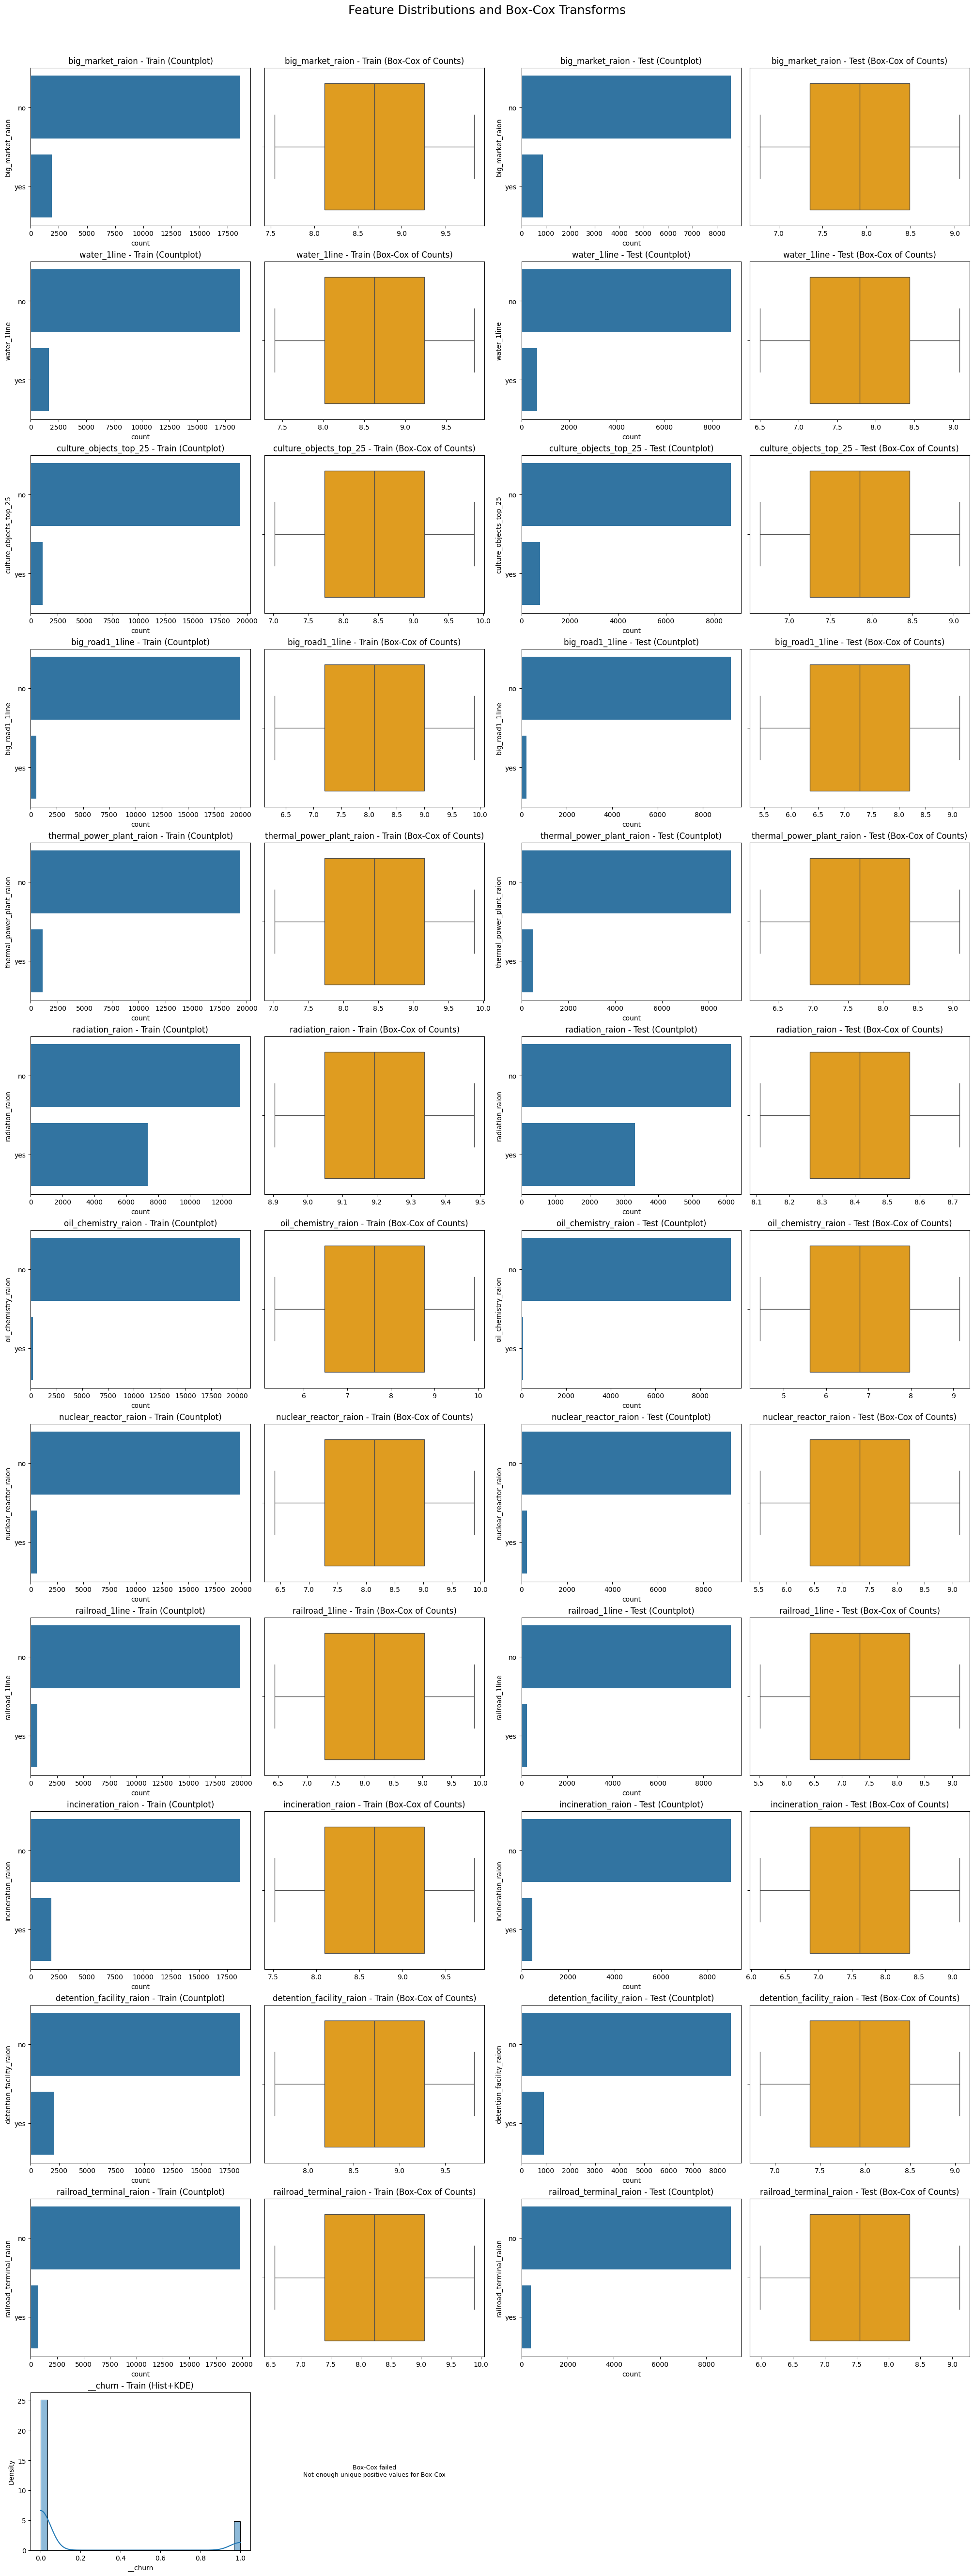

In [13]:
if len(binary.columns):
    inspect_visually(
    dfs={"Train": TRAIN ,  "Test": TEST},
    features=binary.columns
        )  
    data_dict['binary'] = binary.columns.tolist()
    

marital_status type object
marital_status type object
product_type type object
product_type type object
gender type object
gender type object
education_level type object
education_level type object


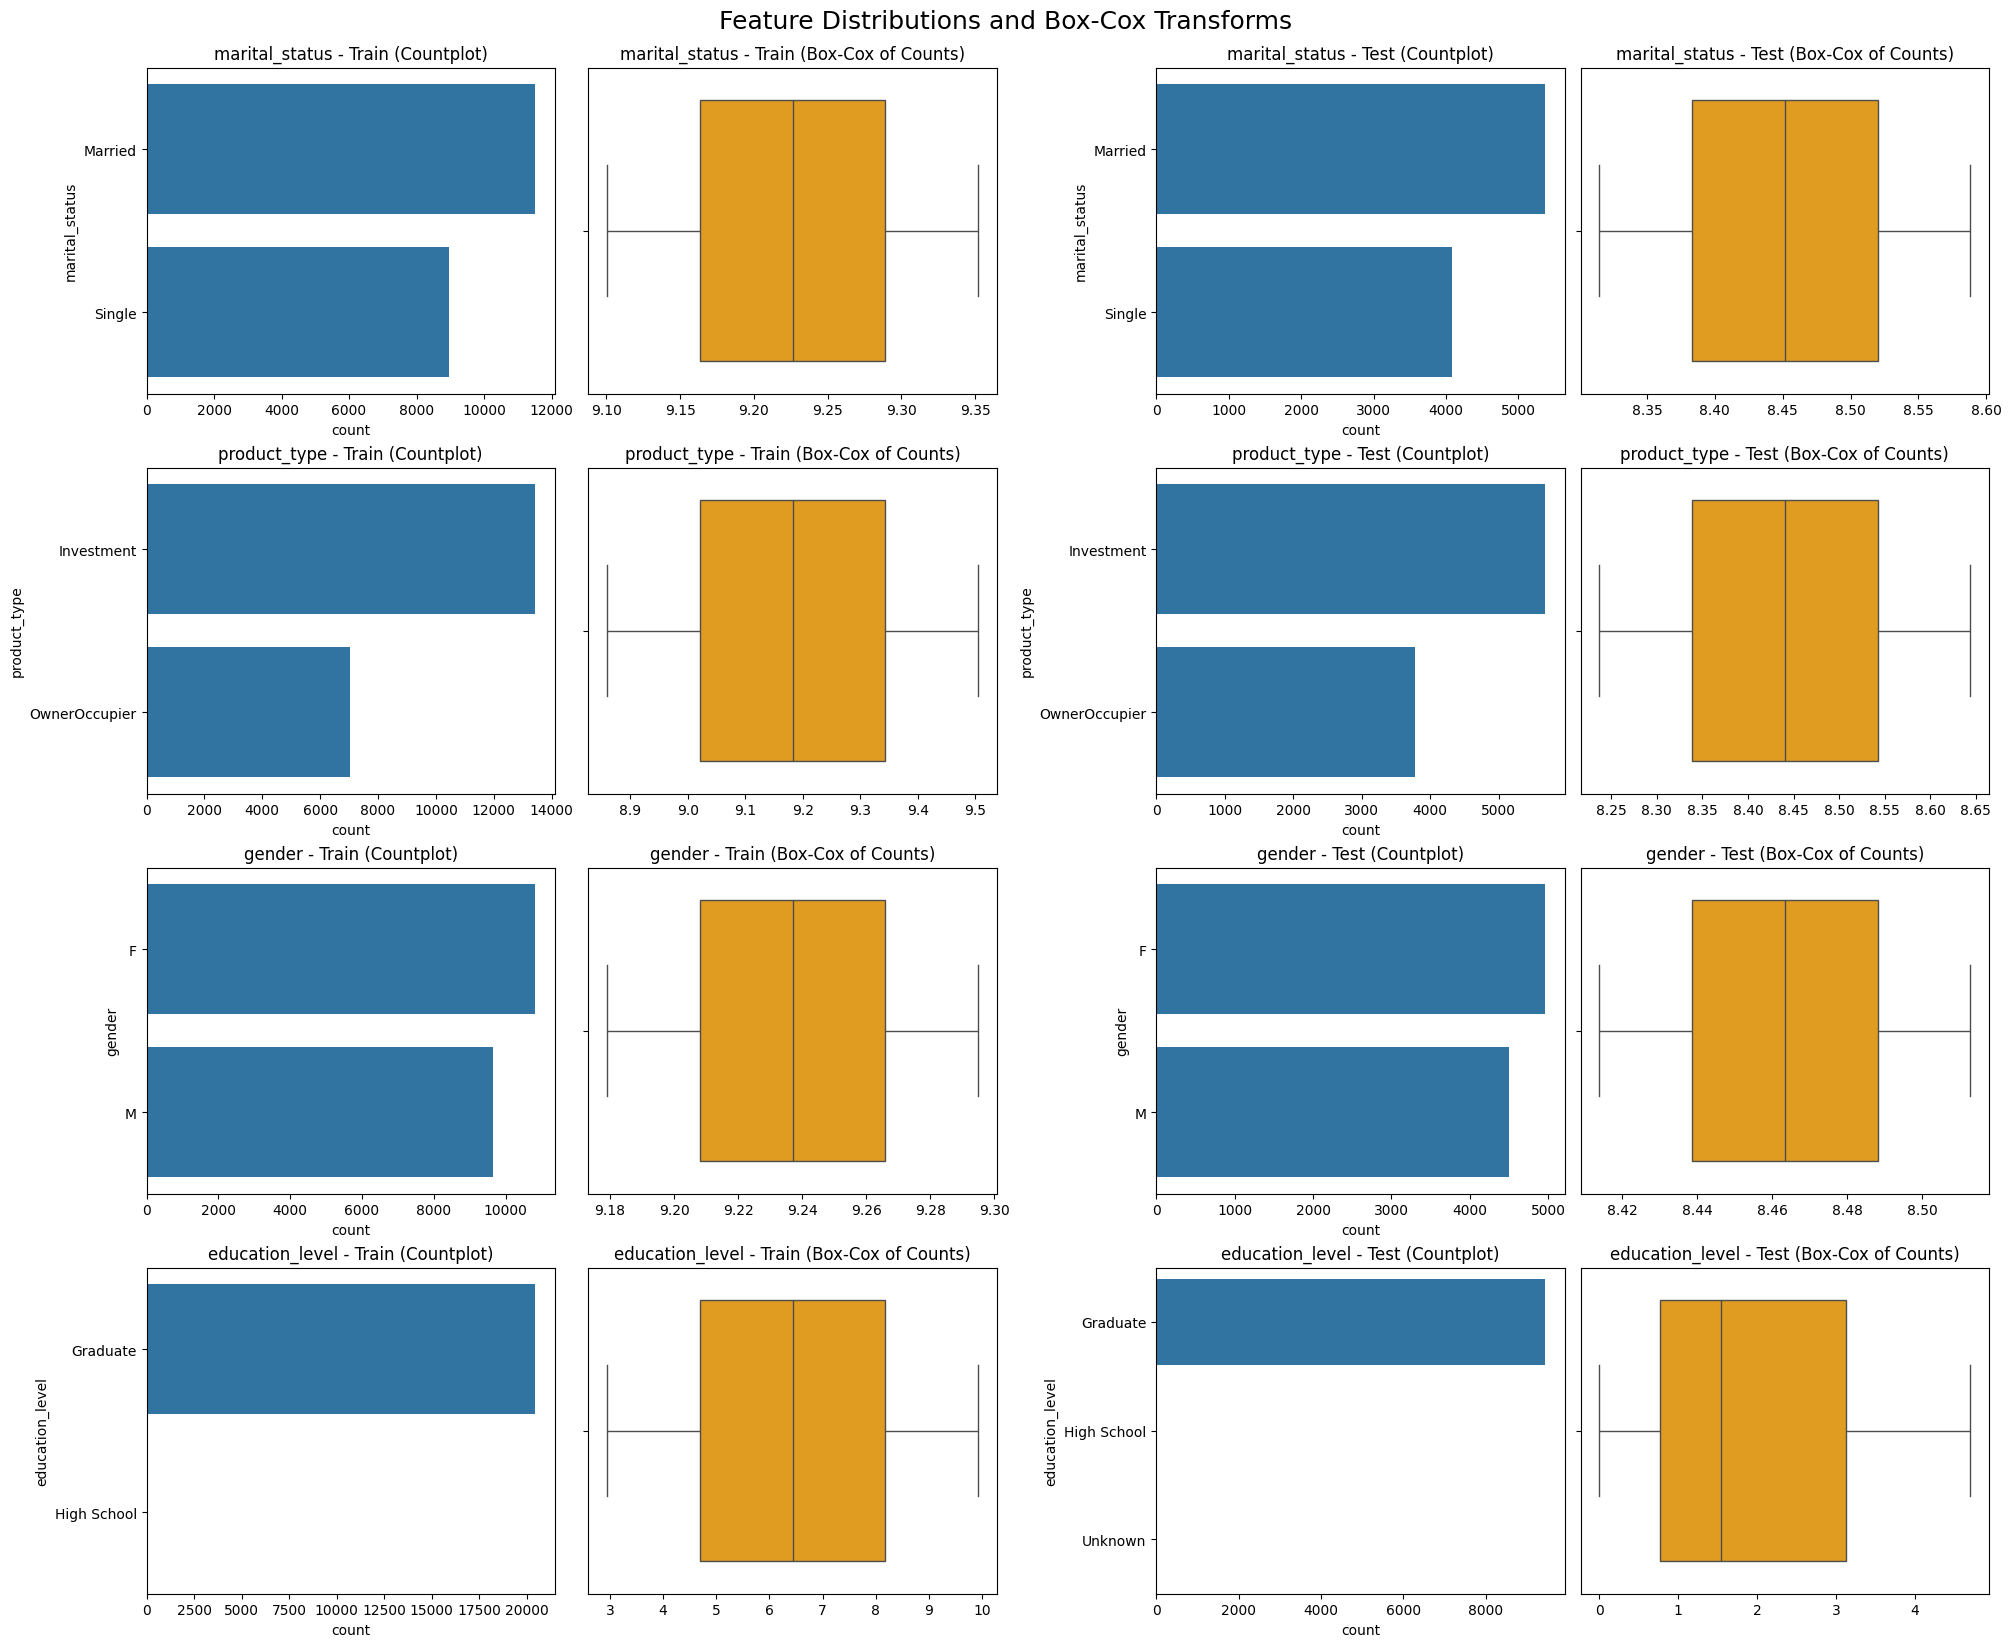

In [14]:
if len(dichotomous.columns):
    inspect_visually(
    dfs={"Train": TRAIN ,  "Test": TEST},
    features=dichotomous.columns
    )  
    data_dict['dichotomous'] = dichotomous.columns.tolist()
    

card_category type object
card_category type object
income_category type object
income_category type object
ecology type object
ecology type object
timestamp type object
timestamp type object


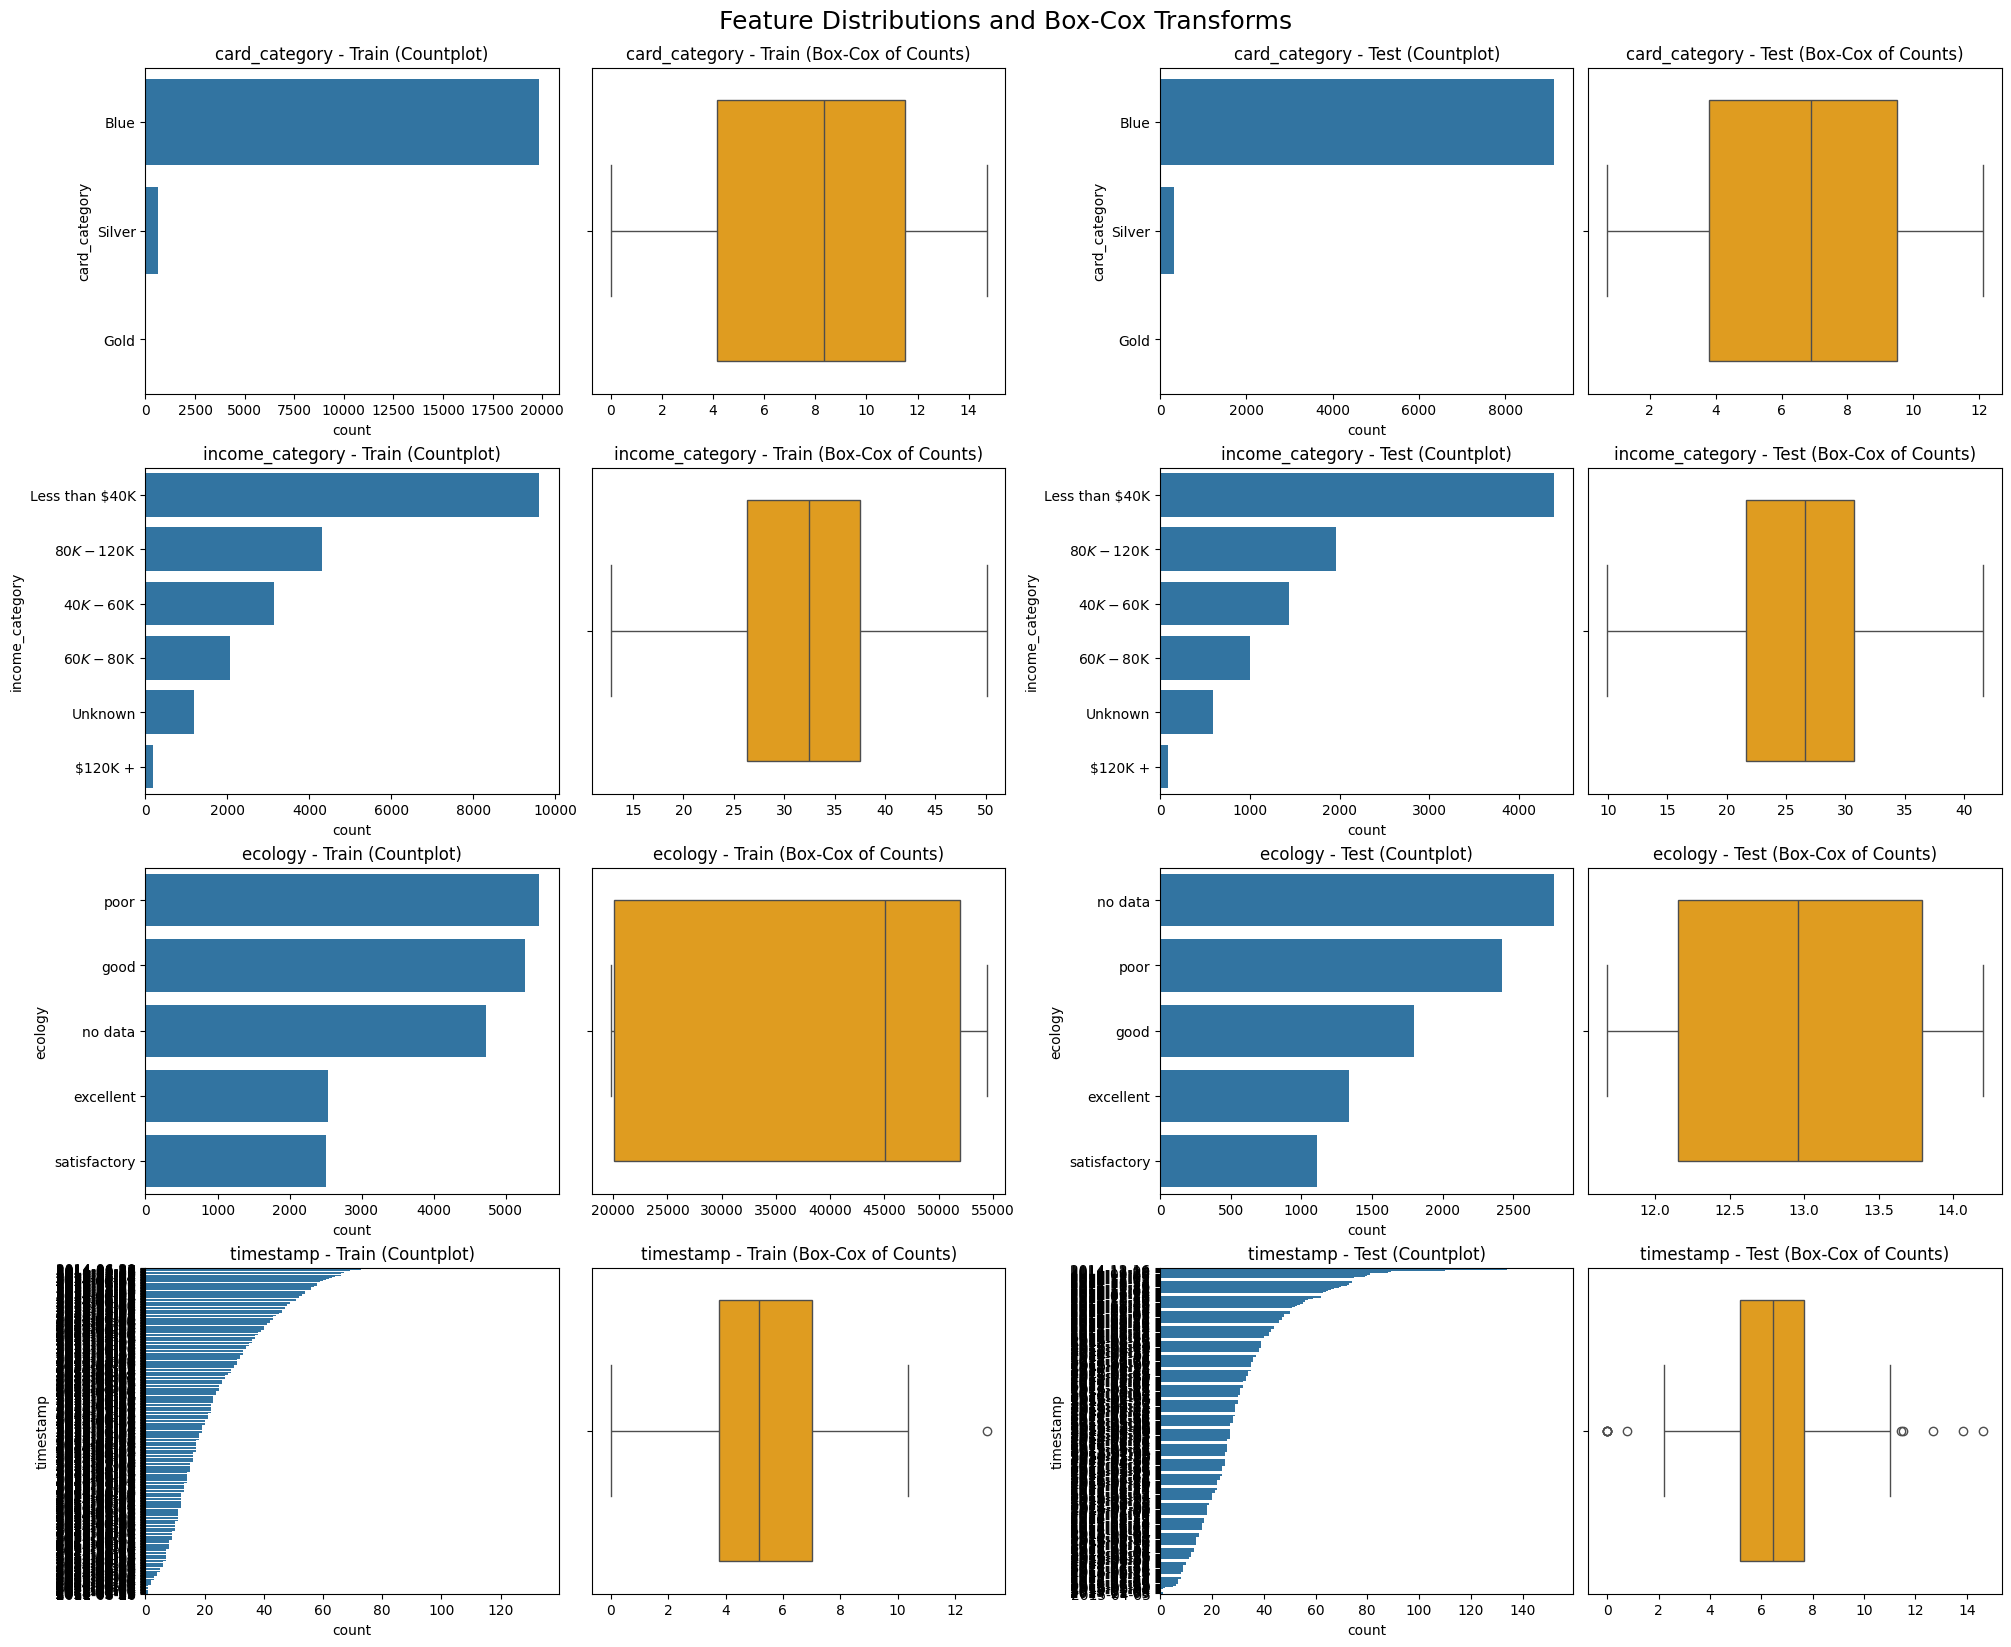

In [15]:
categorical = TRAIN[[col for col in distribution['non_numeric']]]
if len(categorical.columns):
    inspect_visually(
    dfs={"Train": TRAIN ,  "Test": TEST},
    features=categorical.columns
    )  
    data_dict['categorical'] = categorical.columns.tolist()
    

In [16]:
data_dict['timestamp'] = ['timestamp']
data_dict['categorical'] = [col for col in categorical.columns if col not in ['timestamp']]


In [17]:
ordinal_multi_rep = TRAIN[[col for col in distribution['ordinal_multi_rep']]]
for col in ordinal_multi_rep.columns:
    print(ordinal_multi_rep[col].value_counts())

state
3.0     3120
2.0     3117
1.0     1999
4.0      232
33.0       1
Name: count, dtype: int64
market_count_1500
0    11706
1     4249
2     3014
3      752
4      440
5      248
6       60
7       14
Name: count, dtype: int64
contacts_count_12_mon
2    13646
3     6134
1      624
6       45
4       33
0        1
Name: count, dtype: int64
school_education_centers_top_20_raion
0    18432
1     1907
2      144
Name: count, dtype: int64
months_inactive_12_mon
3    11843
2     7184
1     1455
4        1
Name: count, dtype: int64
dependent_count
3    6727
2    5277
1    4485
4    2973
0     994
5      27
Name: count, dtype: int64
total_relationship_count
3    7411
2    4354
6    2988
4    2789
5    2583
1     358
Name: count, dtype: int64
build_count_mix
0.0    14030
1.0     1290
2.0      738
5.0      591
4.0      331
9.0      167
8.0      119
3.0      117
6.0       37
Name: count, dtype: int64


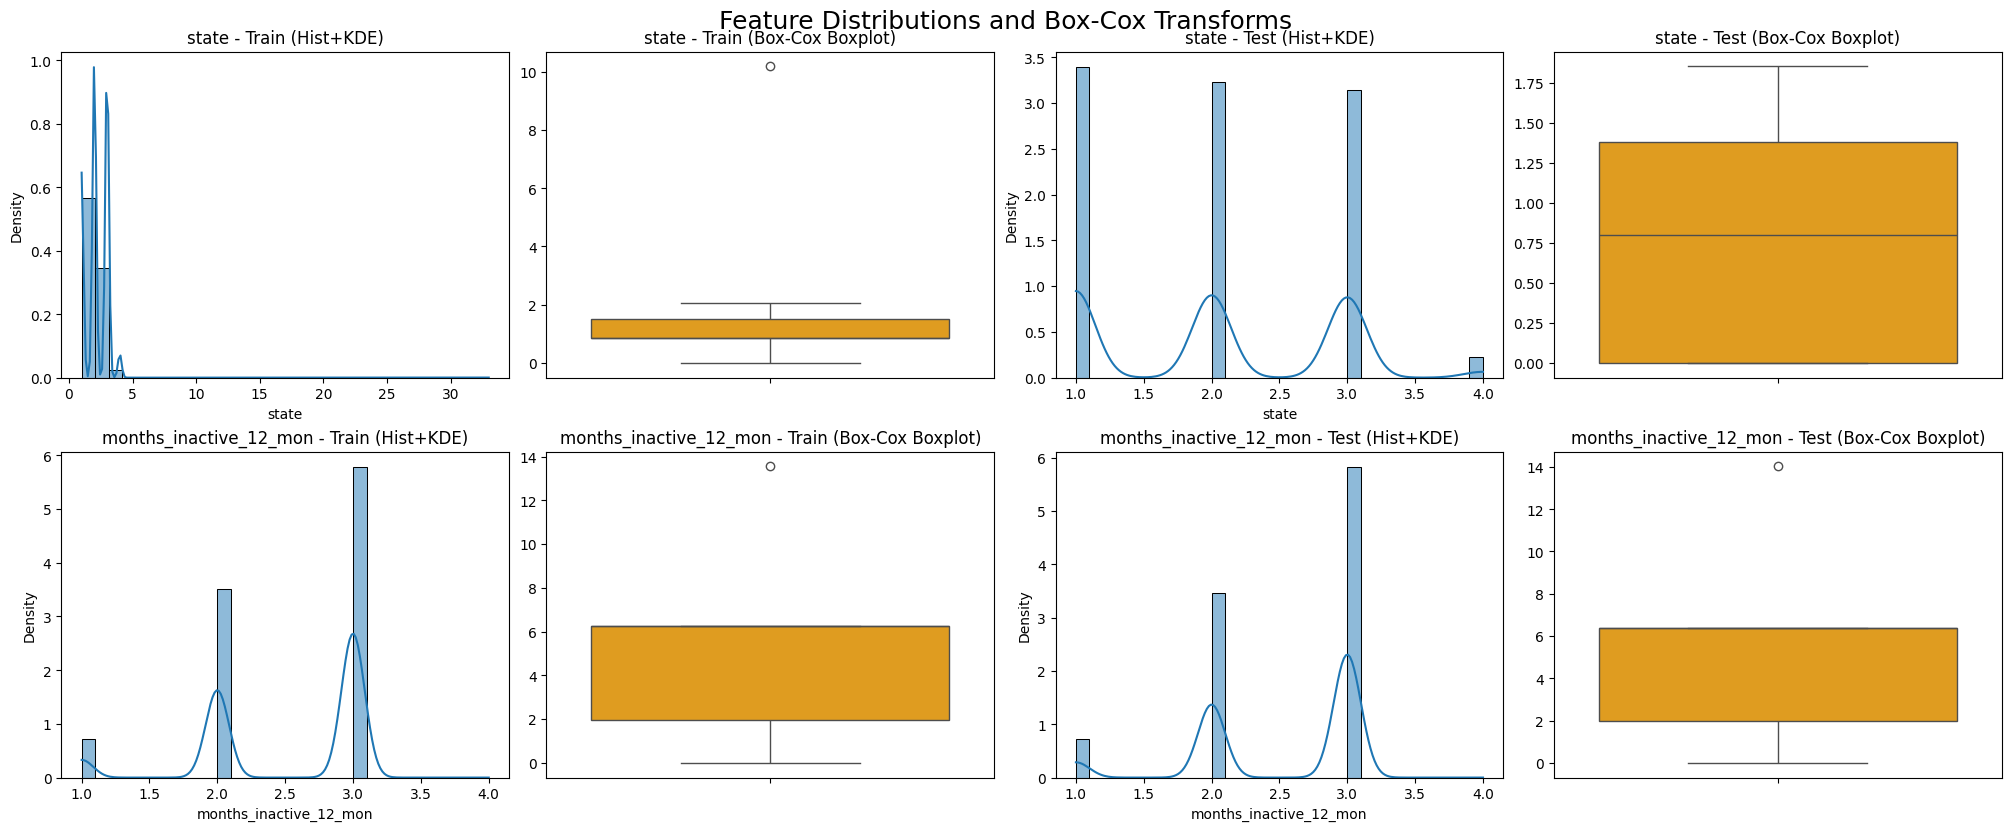

In [18]:
ordinal = TRAIN[ ['state', 'months_inactive_12_mon'] ]
if len(ordinal.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=ordinal.columns
        )  
    data_dict['ordinal'] = ordinal.columns.tolist()


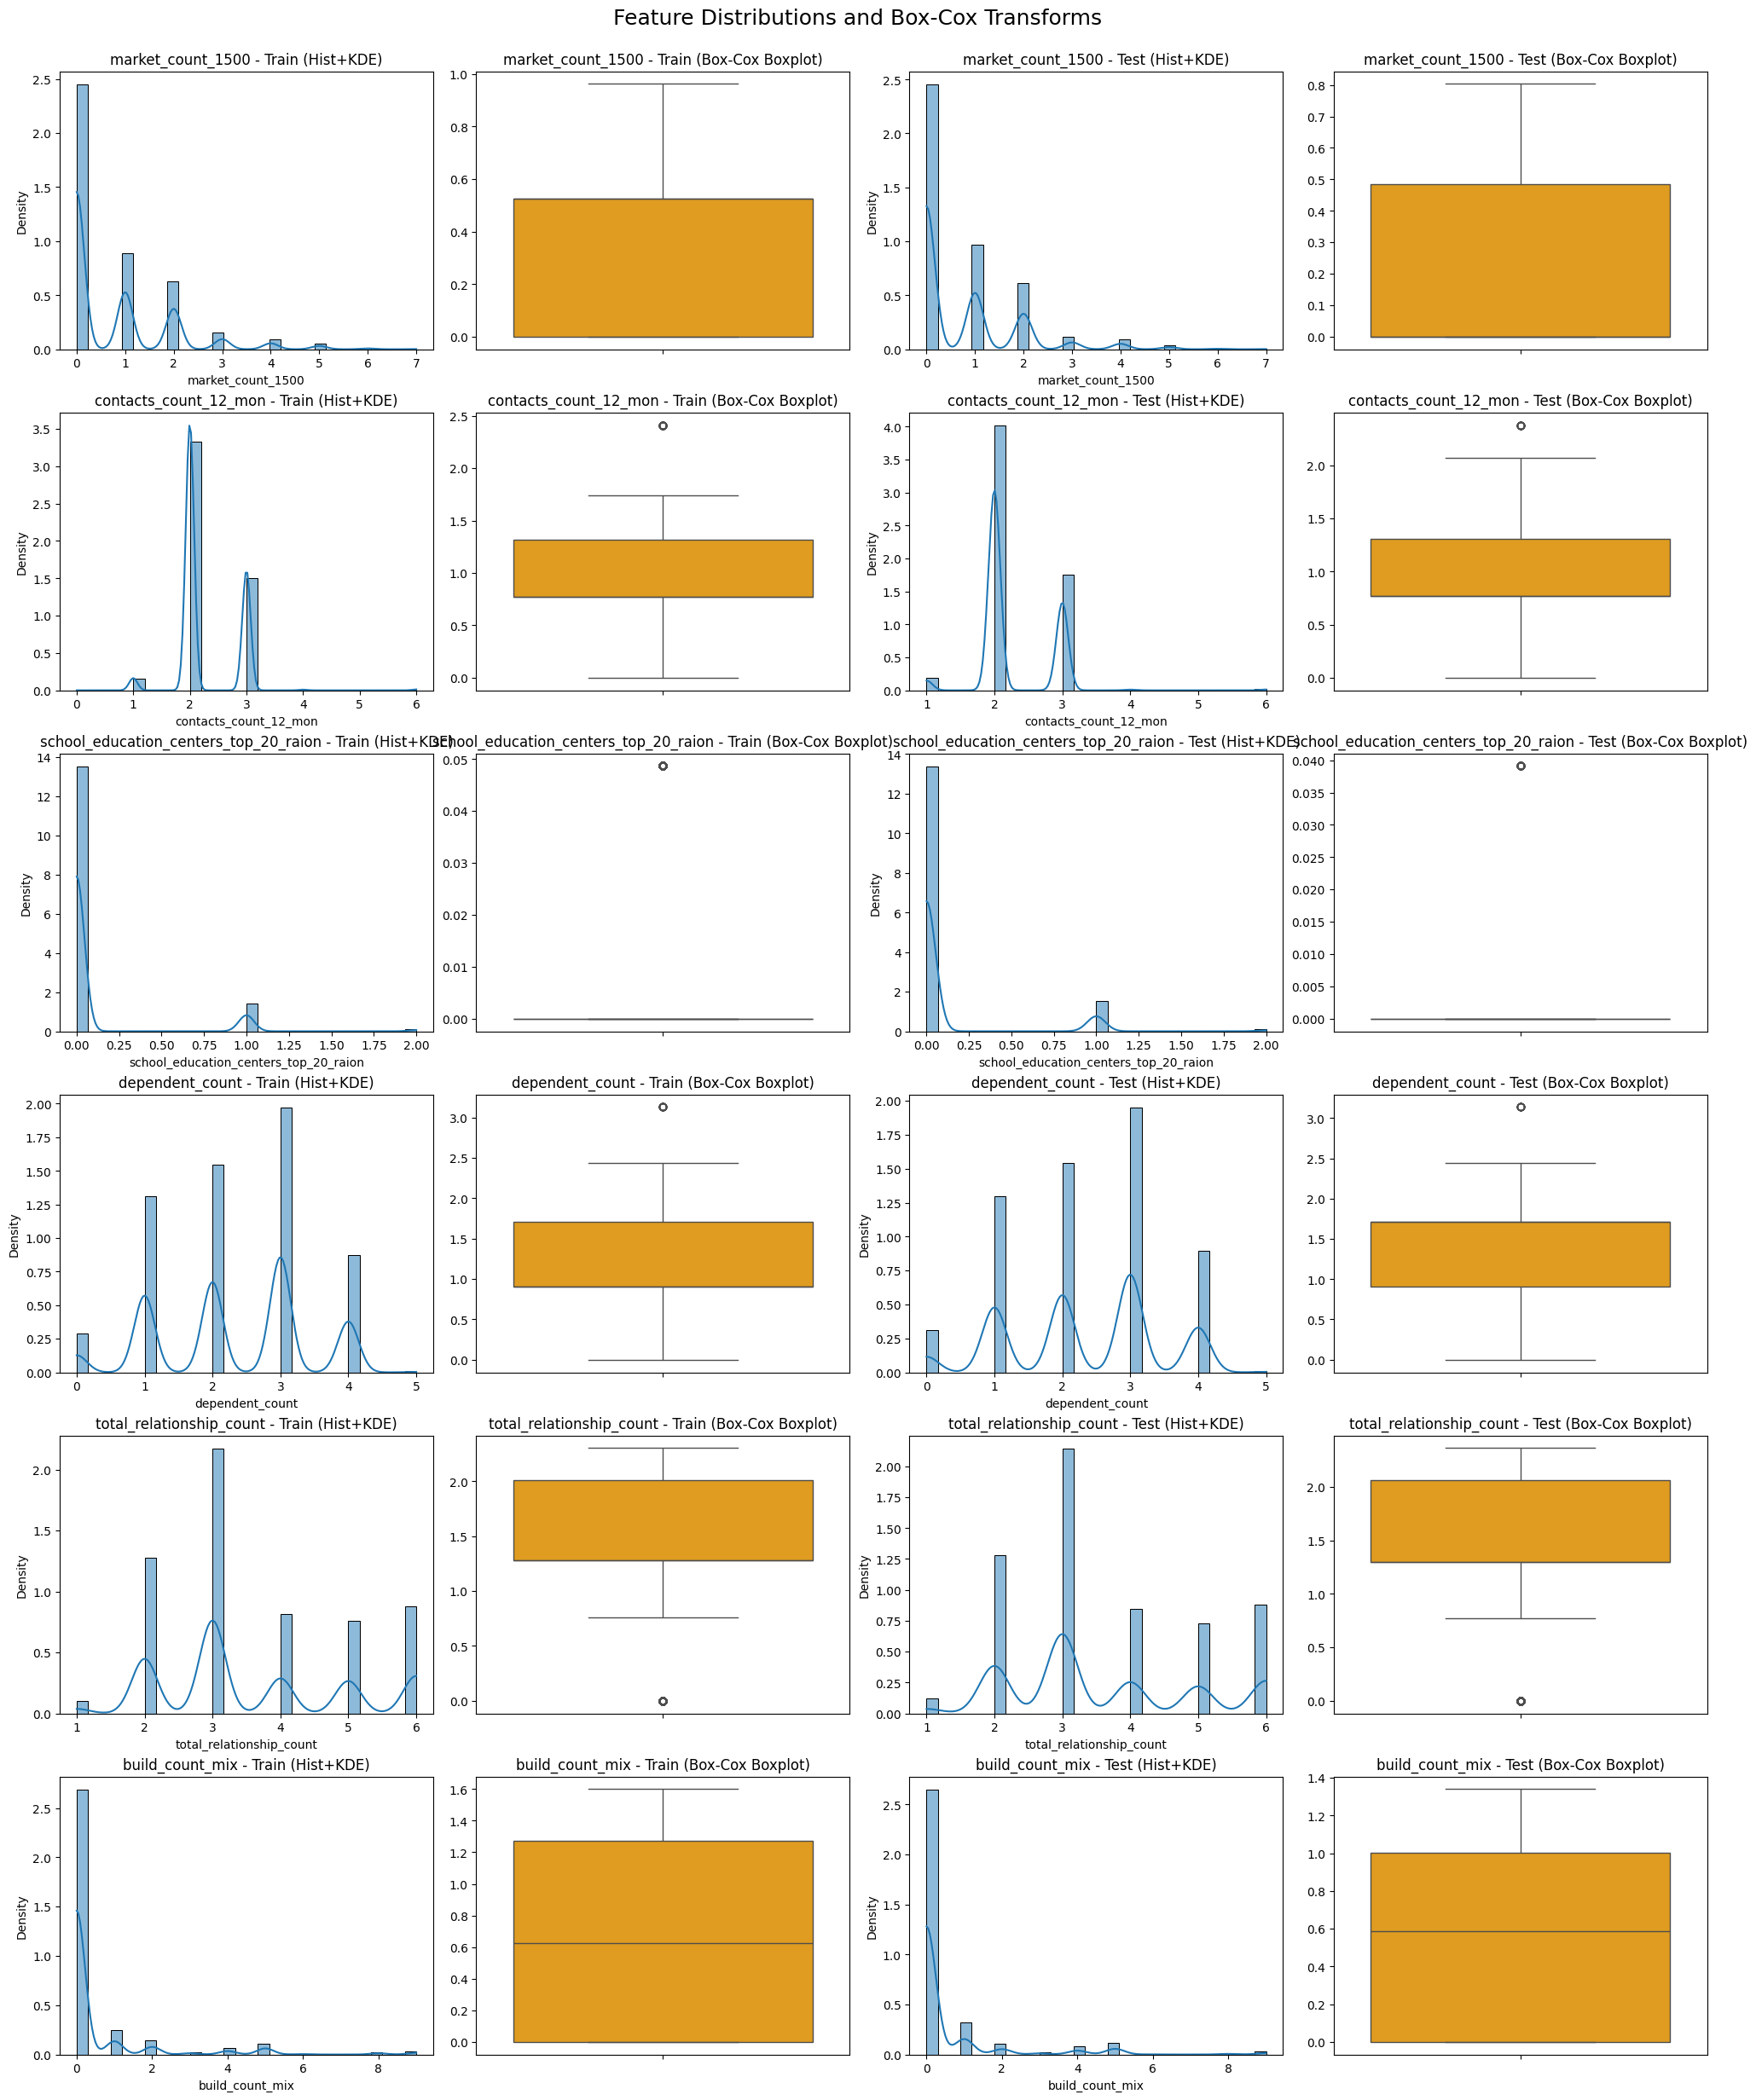

In [19]:
multi_rep = TRAIN[[col for col in ordinal_multi_rep if col not in ordinal]]
if len(multi_rep.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=multi_rep.columns
        )  
    data_dict['multi_rep'] = multi_rep.columns.tolist()
    

In [20]:
normal = TRAIN[[col for col in distribution['normal']]]
if len(normal.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=normal.columns
        ) 
    data_dict['normal'] = normal.columns.tolist()
    

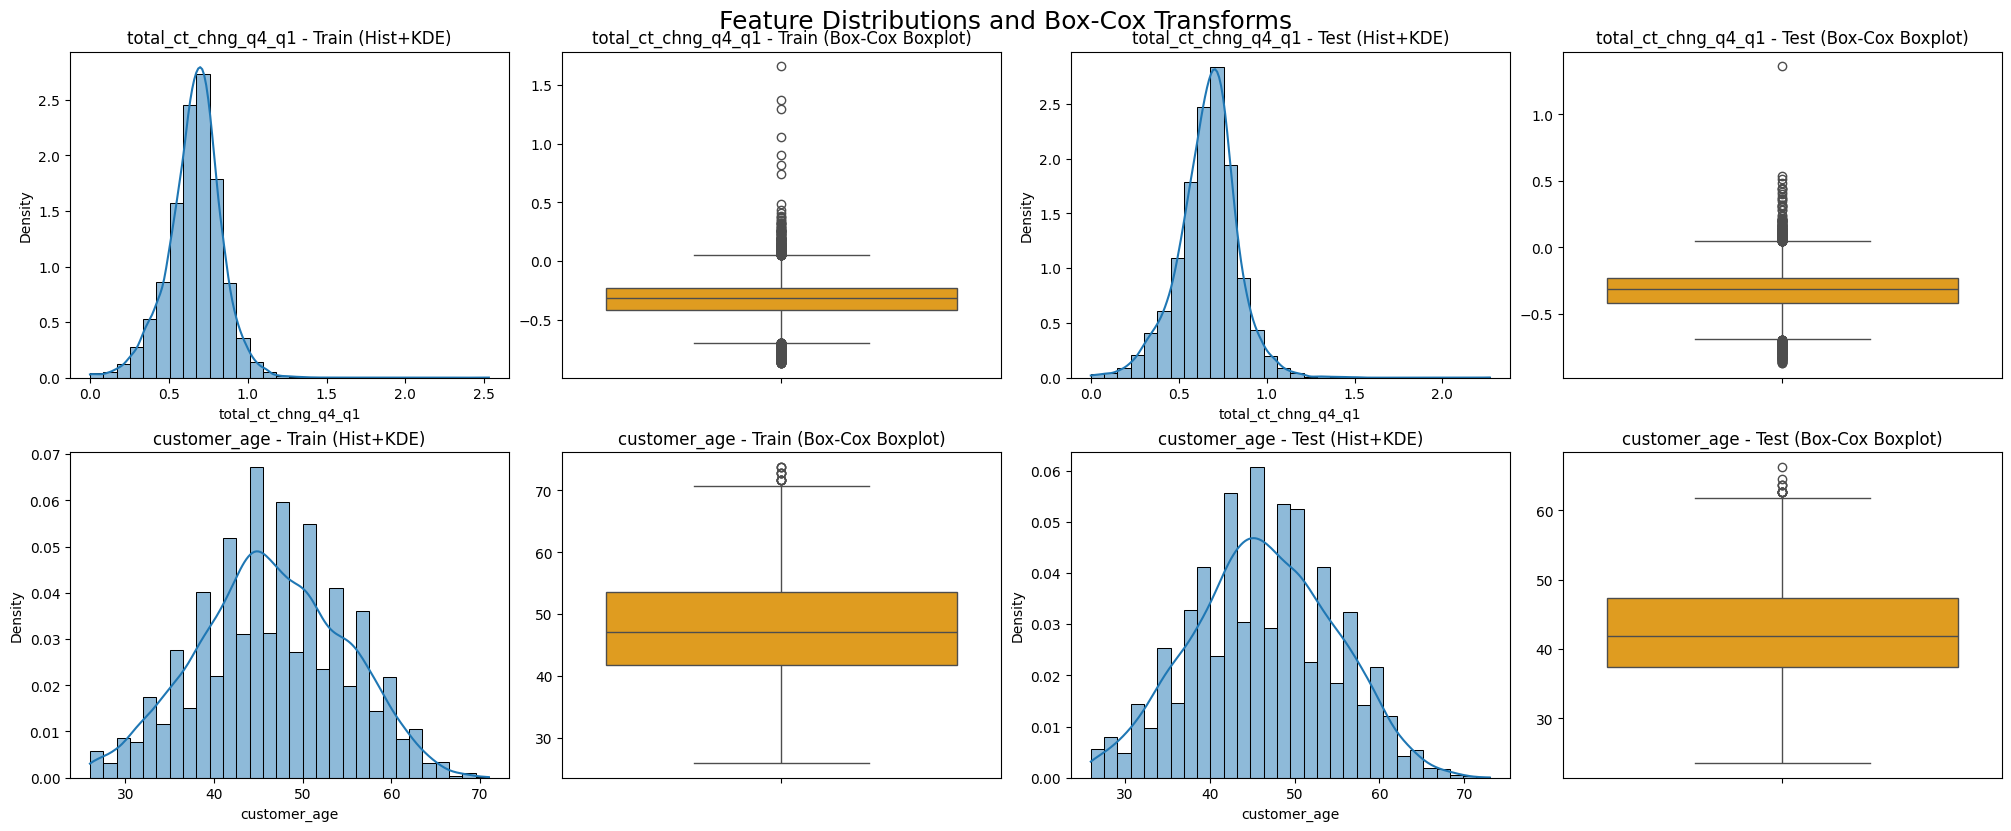

In [21]:
near_normal = TRAIN[[col for col in distribution['near_normal']]]
if len(near_normal.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=near_normal.columns
        )  
    data_dict['near_normal'] = near_normal.columns.tolist()
    

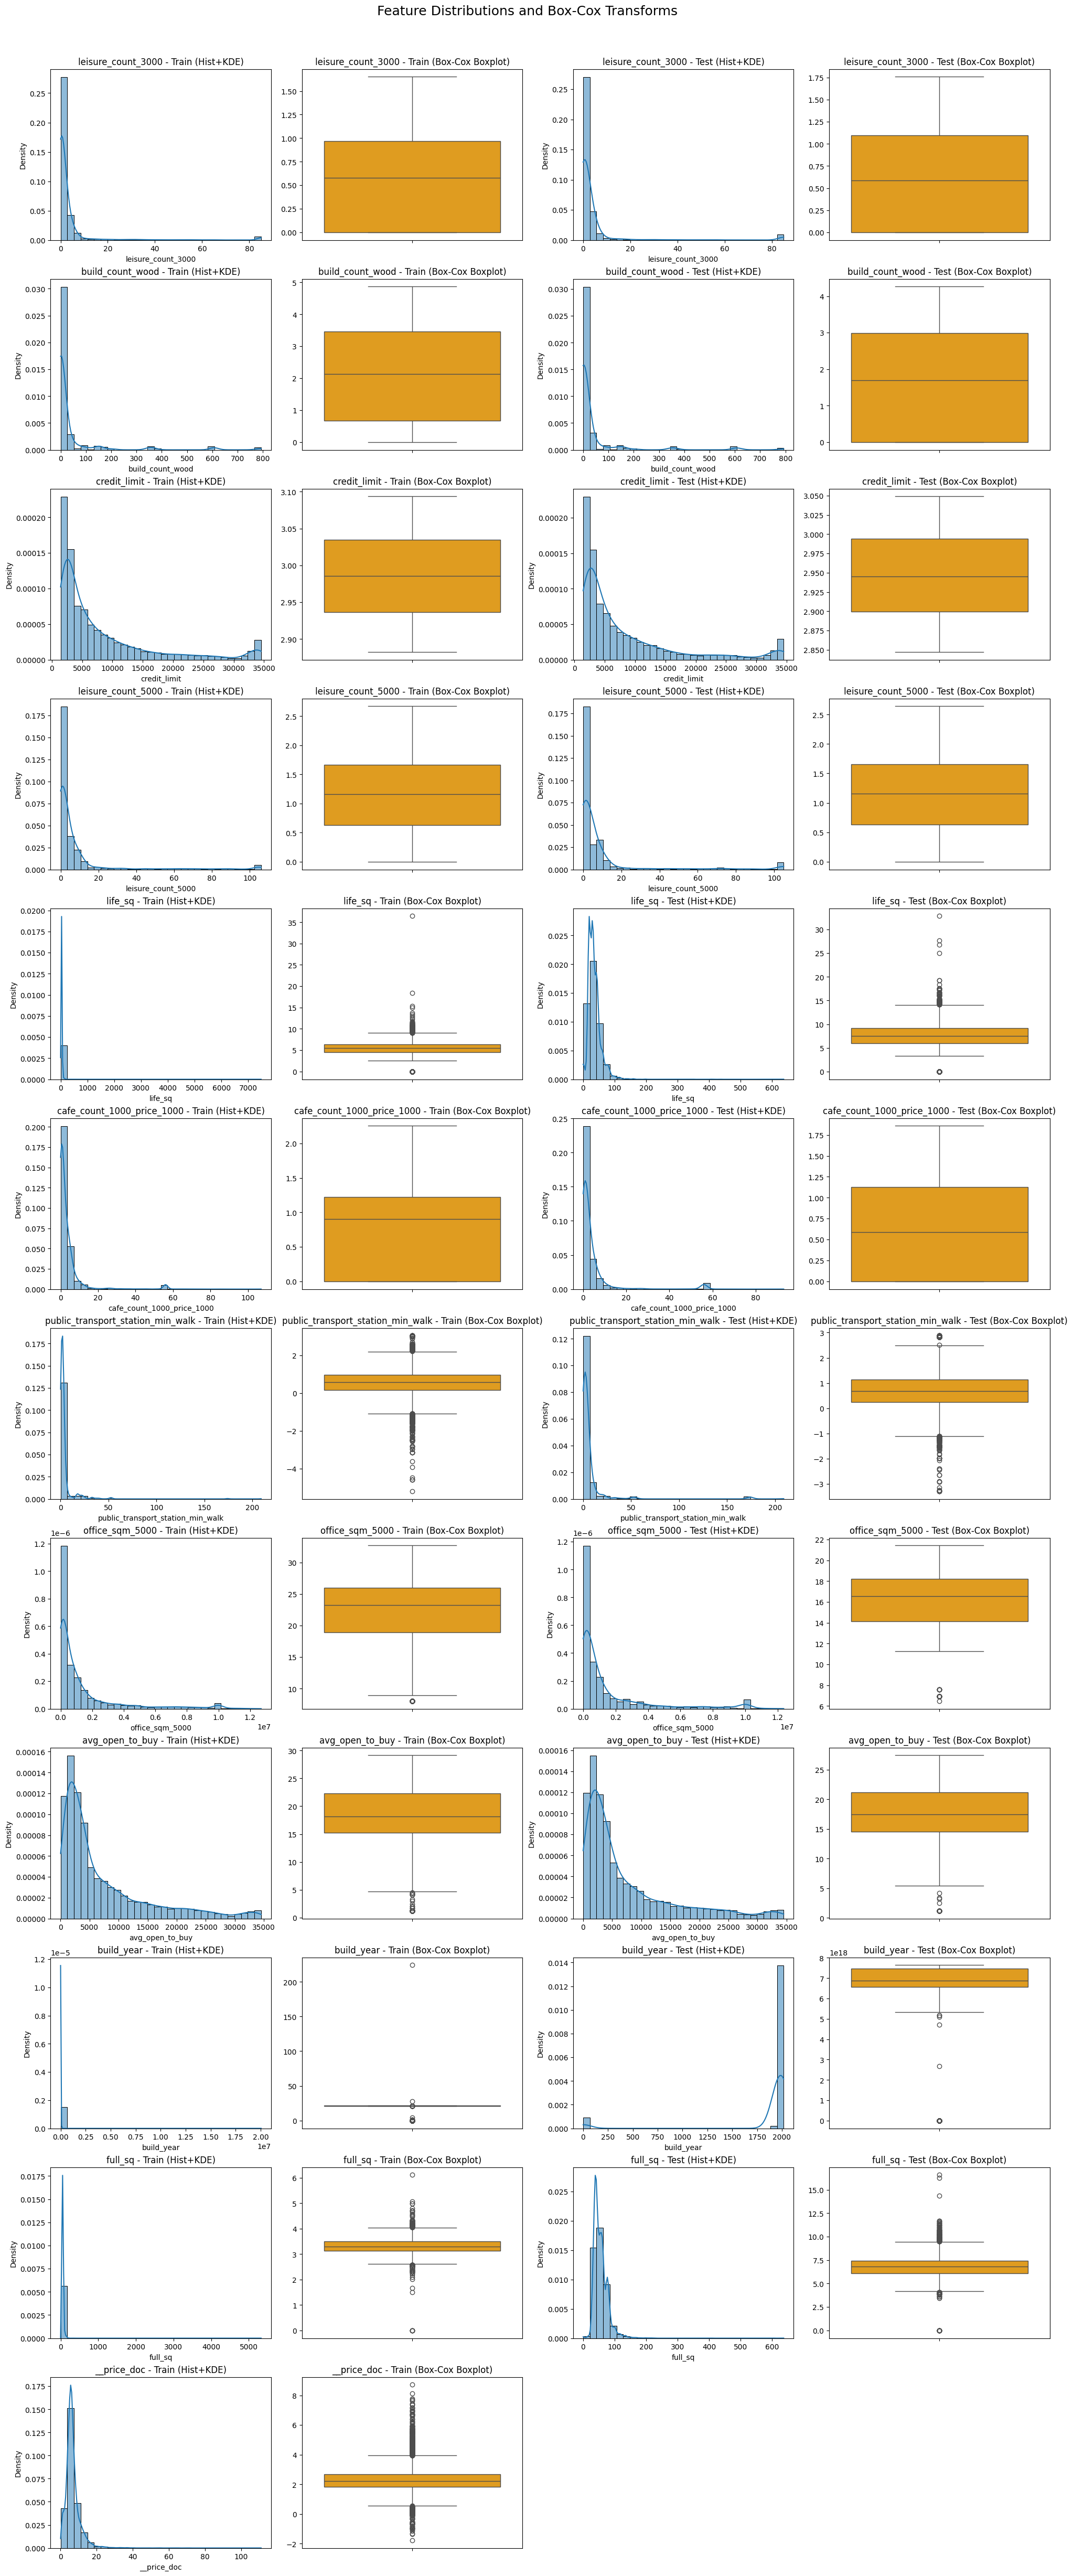

In [22]:
skewed = TRAIN[[col for col in distribution['skewed']]] 
if len(skewed.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=skewed.columns
        )  
    data_dict['skewed'] = skewed.columns.tolist()
    

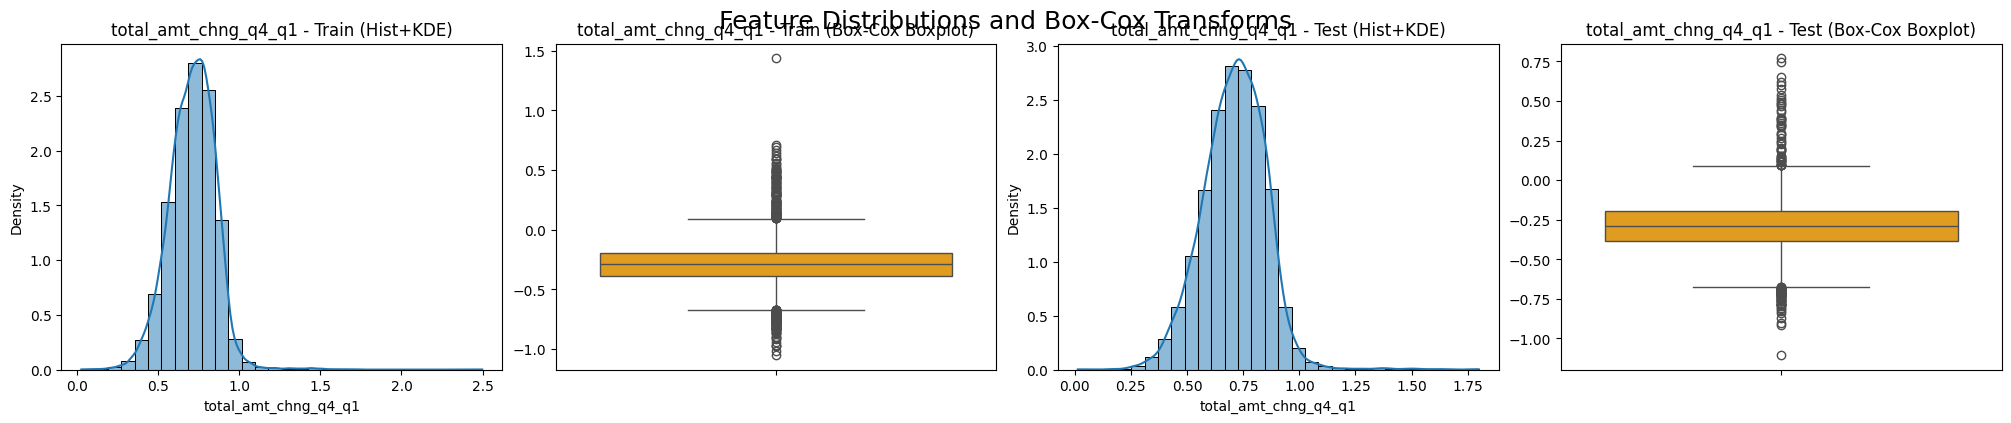

In [23]:
heavy_tailed = TRAIN[[col for col in distribution['heavy_tailed'] if col not in bin_dicho.columns]]
if len(heavy_tailed.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=heavy_tailed.columns
        )  
    data_dict['heavy_tailed'] = heavy_tailed.columns.tolist()
    

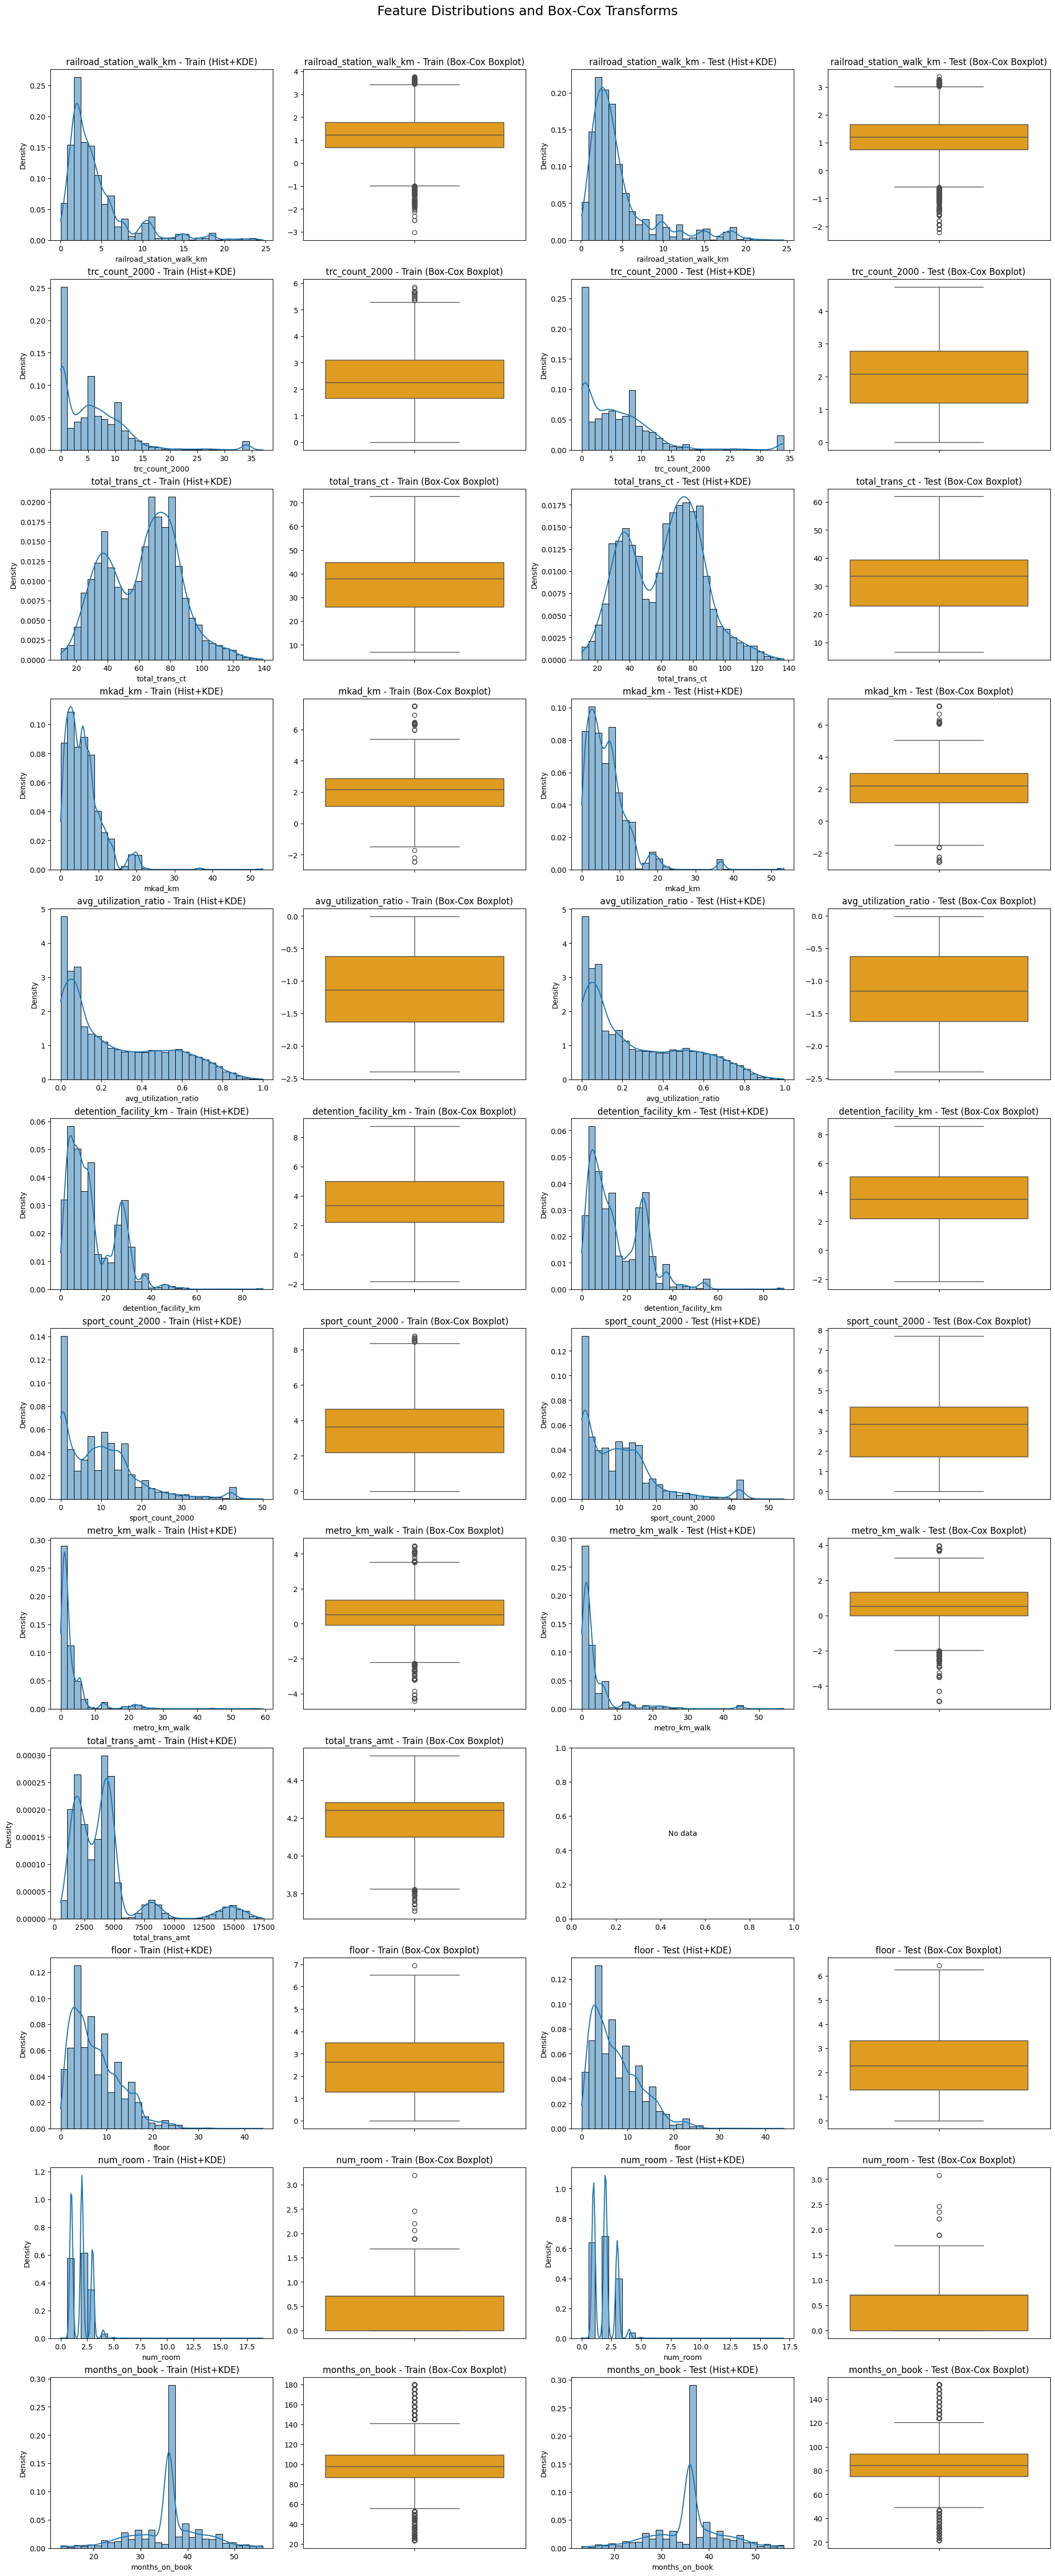

In [24]:
multimodal_moderate = TRAIN[[col for col in distribution['multimodal_moderate']]]
if len(multimodal_moderate.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=multimodal_moderate.columns
        )  
    data_dict['multimodal_moderate'] = multimodal_moderate.columns.tolist()
    

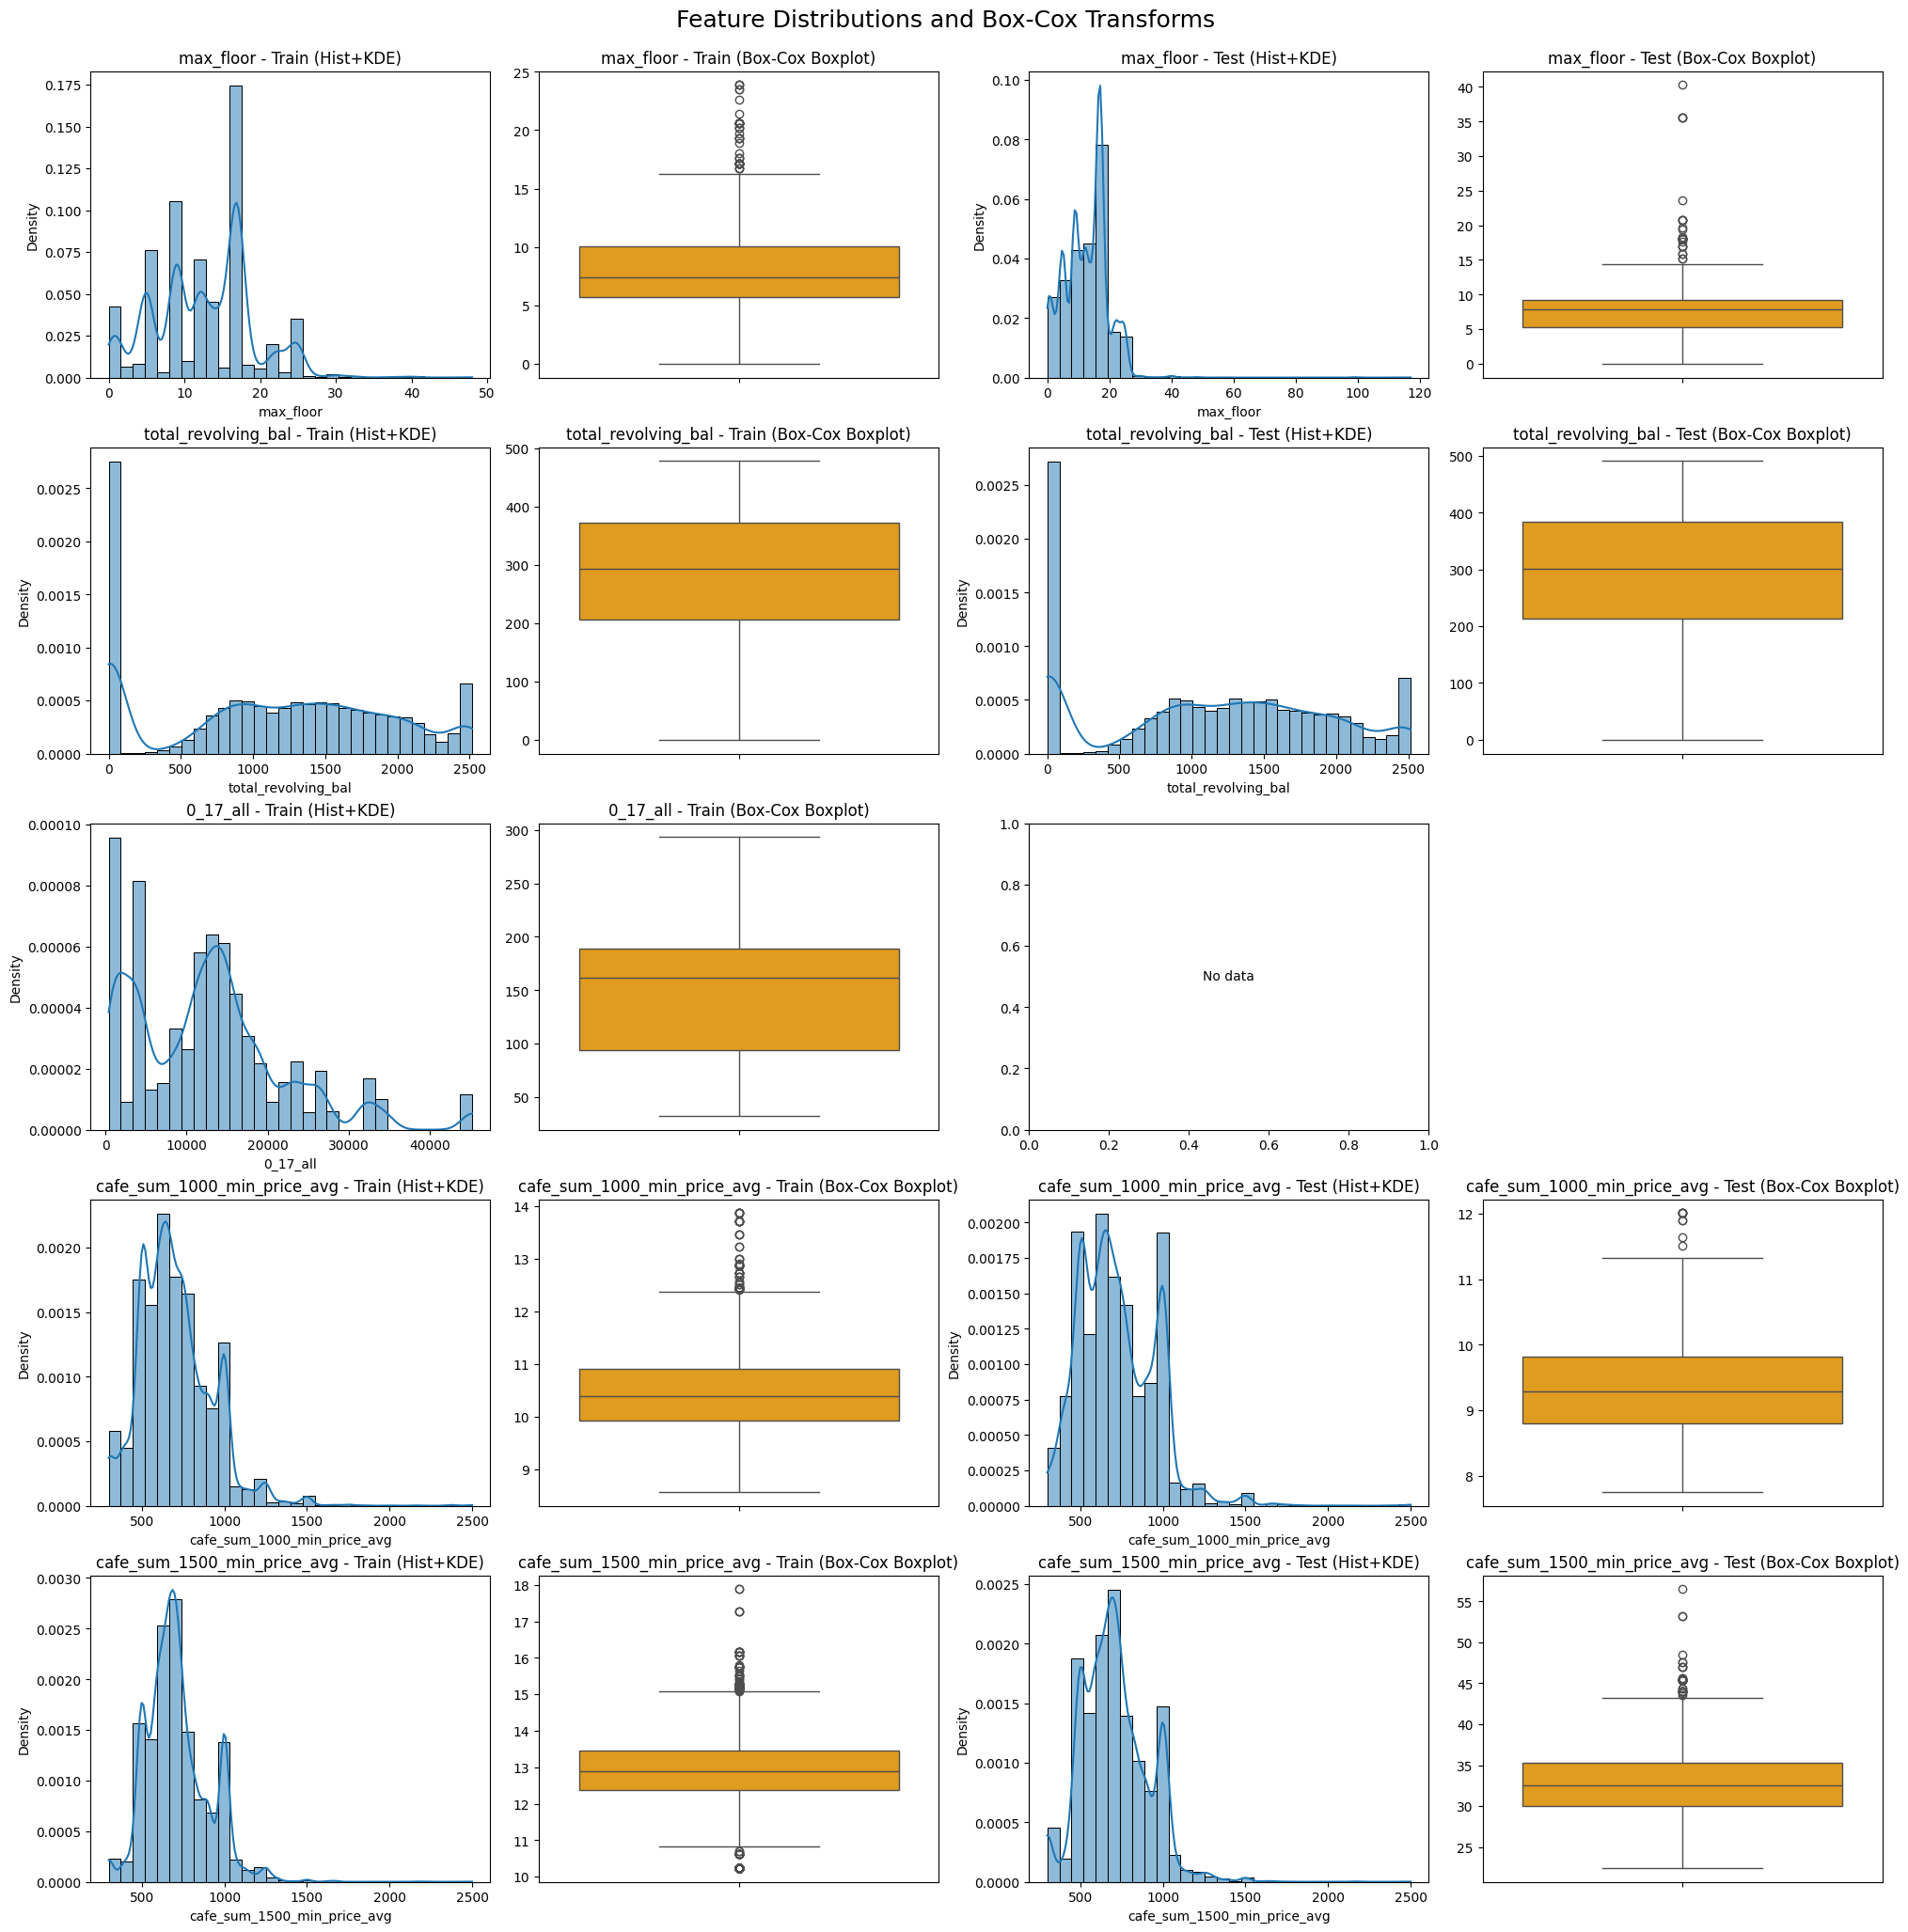

In [25]:
multimodal_extreme = TRAIN[[col for col in distribution['multimodal_extreme']]]
if len(multimodal_extreme.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=multimodal_extreme.columns
        )  
    data_dict['multimodal_extreme'] = multimodal_extreme.columns.tolist()
    

In [26]:
unknown = TRAIN[[col for col in distribution['unknown'] if col not in bin_dicho.columns]]
if len(unknown.columns):
    inspect_visually(
        dfs={"Train": TRAIN ,  "Test": TEST},
        features=multimodal.columns
        ) 
    data_dict['unknown'] = unknown.columns.tolist()
    

Histogram of total revolving balance



<Axes: >

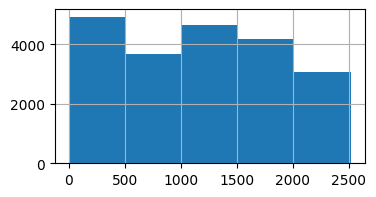

In [27]:
print('Histogram of total revolving balance\n')
TRAIN.total_revolving_bal.hist(bins = 5, figsize = (4,2))

In [28]:
from collections import defaultdict

def clean_data_dict(data_dict, train_columns = [], target_columns = [], target_key='target'):
    train_columns_set = set(train_columns)
    
    # Remove target columns and columns not in train
    cleaned_dict = {}
    for key, cols in data_dict.items():
        # Keep only columns in train and not in target
        cleaned_cols = [col for col in cols if col in train_columns_set and col not in target_columns]
        cleaned_dict[key] = cleaned_cols

    # Add/overwrite target key
    cleaned_dict[target_key] = [col for col in target_columns if col in train_columns_set]

    # Track where each column appears
    column_to_keys = defaultdict(list)
    for key, cols in cleaned_dict.items():
        for col in cols:
            column_to_keys[col].append(key)

    # Find overlapping columns
    overlapping_columns = {col: keys for col, keys in column_to_keys.items() if len(keys) > 1}

    # Report
    if overlapping_columns:
        print("❗ Columns appearing in multiple categories:")
        for col, keys in overlapping_columns.items():
            print(f" - {col}: {keys}")
    else:
        print("✅ No overlapping columns found.")

    return cleaned_dict
 

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from scipy.stats import (chi2_contingency, pointbiserialr, spearmanr, 
                         kruskal, f_oneway, pearsonr)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.7, min_target_correlation=0.7, 
                 method='auto', n_jobs=None):
        """
        Enhanced feature selector that handles all variable type combinations.
        
        Parameters:
        -----------
        threshold : float (default=0.7)
            Correlation threshold for feature removal
        min_target_correlation : float (default=0.7)
            Minimum required correlation with target to keep a feature
        method : str {'auto', 'pearson', 'spearman', 'kendall', 'cramers', 'mutual_info'}
            Correlation method to use
        n_jobs : int (default=None)
            Number of jobs to run in parallel for mutual information
        """
        self.threshold = threshold
        self.min_target_correlation = min_target_correlation
        self.method = method
        self.n_jobs = n_jobs
        self.columns_to_keep_ = None
        self.columns_to_drop_ = None
        self.constant_features_ = None
        self.feature_types_ = None
        self.target_type_ = None

    def _determine_variable_type(self, series):
        """Determine if variable is numeric, categorical, or binary"""
        if pd.api.types.is_numeric_dtype(series):
            unique_vals = series.nunique()
            if unique_vals == 2:
                return 'binary'
            return 'numeric'
        return 'categorical'

    def _safe_pearson(self, x, y):
        """Pearson correlation with NaN/constant handling"""
        with np.errstate(divide='ignore', invalid='ignore'):
            if np.nanstd(x) == 0 or np.nanstd(y) == 0:
                return 0.0
            corr = np.corrcoef(x, y, rowvar=False)[0, 1]
            return corr if not np.isnan(corr) else 0.0

    def _safe_spearman(self, x, y):
        """Spearman correlation with NaN/constant handling"""
        try:
            return spearmanr(x, y, nan_policy='omit')[0]
        except:
            return 0.0

    def _cramers_v(self, x, y):
        """Calculate Cramér's V statistic for categorical-categorical"""
        confusion_matrix = pd.crosstab(x, y)
        try:
            chi2 = chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2/n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        except:
            return 0.0

    def _correlation_ratio(self, categories, values):
        """Correlation ratio for categorical-numeric"""
        try:
            categories = pd.factorize(categories)[0]
            values = np.asarray(values)
            if np.nanstd(values) == 0:
                return 0.0
            fcat, _ = pd.factorize(categories)
            y_avg = np.array([np.nanmean(values[fcat == i]) 
                            for i in np.unique(fcat)])
            y_total_avg = np.nanmean(values)
            numerator = np.nansum(np.multiply(np.bincount(fcat), np.power(y_avg - y_total_avg, 2)))
            denominator = np.nansum(np.power(values - y_total_avg, 2))
            return np.sqrt(numerator/denominator) if denominator != 0 else 0.0
        except:
            return 0.0

    def _anova_correlation(self, categories, values):
        """ANOVA F-value for categorical-numeric"""
        try:
            categories = pd.factorize(categories)[0]
            groups = [values[categories == i] for i in np.unique(categories)]
            f_val = f_oneway(*groups)[0]
            return np.sqrt(f_val / (f_val + len(values) - len(groups)))
        except:
            return 0.0

    def _get_correlation_method(self, x_type, y_type):
        """Select appropriate correlation method based on variable types"""
        if self.method != 'auto':
            return self.method
            
        if x_type == 'numeric' and y_type == 'numeric':
            return 'pearson'
        elif x_type == 'numeric' and y_type in ['binary', 'categorical']:
            return 'correlation_ratio'
        elif x_type in ['binary', 'categorical'] and y_type == 'numeric':
            return 'correlation_ratio'
        elif x_type in ['binary', 'categorical'] and y_type in ['binary', 'categorical']:
            return 'cramers_v'
        else:
            return 'pearson'  # fallback

    def _calculate_correlation(self, x, y, x_type, y_type, method='auto'):
        """Calculate correlation based on variable types"""
        method = self._get_correlation_method(x_type, y_type) if method == 'auto' else method
        
        if method == 'pearson':
            return self._safe_pearson(x, y)
        elif method == 'spearman':
            return self._safe_spearman(x, y)
        elif method == 'cramers_v':
            return self._cramers_v(x, y)
        elif method == 'correlation_ratio':
            return self._correlation_ratio(x, y)
        elif method == 'anova':
            return self._anova_correlation(x, y)
        elif method == 'mutual_info':
            if x_type == 'numeric' and y_type == 'numeric':
                return mutual_info_regression(x.values.reshape(-1, 1), y, n_jobs=self.n_jobs)[0]
            else:
                return mutual_info_classif(x.values.reshape(-1, 1), y, n_jobs=self.n_jobs)[0]
        else:
            return self._safe_pearson(x, y)  # default fallback

    def fit(self, X, y):
        """Identify correlated features with enhanced type handling"""
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, (pd.Series, pd.DataFrame)):
            y = pd.Series(y) if len(y.shape) == 1 else pd.DataFrame(y)
        
        # Step 1: Drop constant features
        self.constant_features_ = [
            col for col in X.columns 
            if X[col].nunique() <= 1 or X[col].isna().all()
        ]
       # print(f"🚨 Dropping constant columns: {self.constant_features_}")
        X = X.drop(columns=self.constant_features_).copy()
        
        # Determine feature types
        self.feature_types_ = {col: self._determine_variable_type(X[col]) 
                              for col in X.columns}
        self.target_type_ = self._determine_variable_type(y)
        
        # Encode categorical features
        le = LabelEncoder()
        for col in X.columns:
            if self.feature_types_[col] in ['categorical', 'binary']:
                X[col] = le.fit_transform(X[col].astype(str).fillna('MISSING'))
        
        # Encode target if categorical
        if self.target_type_ in ['categorical', 'binary']:
            y = le.fit_transform(y.astype(str).fillna('MISSING'))
        
        # Calculate correlation matrix
        corr_matrix = pd.DataFrame(0.0, index=X.columns, columns=X.columns)
        np.fill_diagonal(corr_matrix.values, 1.0)
        
        # Fill correlation matrix
        for i, col1 in enumerate(X.columns):
            for j, col2 in enumerate(X.columns):
                if i >= j:
                    continue
                x_type = self.feature_types_[col1]
                y_type = self.feature_types_[col2]
                corr_matrix.loc[col1, col2] = self._calculate_correlation(
                    X[col1], X[col2], x_type, y_type
                )
                corr_matrix.loc[col2, col1] = corr_matrix.loc[col1, col2]
        
        # Calculate target correlations
        target_corr = pd.Series(0.0, index=X.columns)
        for col in X.columns:
            x_type = self.feature_types_[col]
            target_corr[col] = self._calculate_correlation(
                X[col], y, x_type, self.target_type_
            )
 
        # Identify highly correlated feature pairs
        high_corr_pairs = np.where(np.triu(corr_matrix > self.threshold, k=1))
        high_corr_pairs = list(zip(high_corr_pairs[0], high_corr_pairs[1]))
        
        # Create graph of correlated features
        from collections import defaultdict
        corr_graph = defaultdict(set)
        for i, j in high_corr_pairs:
            col1 = corr_matrix.index[i]
            col2 = corr_matrix.columns[j]
            corr_graph[col1].add(col2)
            corr_graph[col2].add(col1)
        
        # Find connected components (groups of correlated features)
        visited = set()
        correlated_groups = []
        
        for col in corr_matrix.columns:
            if col not in visited:
                stack = [col]
                component = set()
                while stack:
                    node = stack.pop()
                    if node not in visited:
                        visited.add(node)
                        component.add(node)
                        stack.extend(corr_graph[node] - visited)
                if len(component) > 1:
                    correlated_groups.append(component)
        
        # Select features to keep/drop
        self.columns_to_keep_ = set()
        self.columns_to_drop_ = set()
        
        for group in correlated_groups:
            # Find feature with highest absolute correlation to target
            best_feature = max(group, key=lambda x: abs(target_corr[x]))
            
            # Only keep if meets minimum target correlation
            if abs(target_corr[best_feature]) >= self.min_target_correlation:
                self.columns_to_keep_.add(best_feature)
                self.columns_to_drop_.update(group - {best_feature})
            else:
                # If no feature meets threshold, keep all (don't drop any)
                self.columns_to_keep_.update(group)
        
        # Convert to lists for consistency
        self.columns_to_keep_ = list(self.columns_to_keep_)
        self.columns_to_drop_ = list(self.columns_to_drop_)
        
        print(f"✅ Keeping {len(self.columns_to_keep_)} features")
        print(f"🚨 Dropping {len(self.columns_to_drop_)} correlated features")
        
        return self
    
    def transform(self, X):
        """Drop correlated and constant features"""
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        if hasattr(self, 'constant_features_'):
            X = X.drop(columns=self.constant_features_, errors='ignore')
        
        return X.drop(columns=self.columns_to_drop_, errors='ignore')
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

### PIPELINE

<pre><h3>
📊 PIPELINE 0: Data Cleaning and splitting pipeline💡

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from typing import Optional, List

class BaseDataCleaner(BaseEstimator, TransformerMixin):
    def __init__(
        self, 
        test_df: Optional[pd.DataFrame] = None,
        task: str = 'regression',
        reg_target: Optional[str] = None,
        cls_target: Optional[str] = None,
        date_columns: Optional[List[str]] = None,
        test_size: float = 0.3,
        random_state: int = 42,
        stratify_col: Optional[str] = None,
        use_external_features: bool = True,
        drop_correlated_features: bool = False,
        correlation_threshold: float = 0.8,
        negative_allowed: Optional[List[str]] = None,
        data_dict: Optional[dict] = None
    ):
        self.data_dict = data_dict or {}
        self.categorical_columns = []
        self.numeric_columns = []
        
        self.test_df = test_df.copy() if test_df is not None else pd.DataFrame()
        self.task = task
        self.reg_target = reg_target
        self.cls_target = cls_target
        self.date_columns = [col.lower().strip() for col in date_columns] if date_columns else []
        self.target_columns = [col.lower().strip() for col in [self.reg_target, self.cls_target] if col is not None]  
        self.test_size = test_size
        self.random_state = random_state
        self.stratify_col = stratify_col
        self.use_external_features = use_external_features
        
        self.drop_correlated_features = drop_correlated_features
        self.correlation_threshold = correlation_threshold
        self.correlation_selector_ = None
        
        self.negative_allowed = negative_allowed if negative_allowed is not None else []
        self.verbose = True
        
        # Internal attributes
        self.datetime_formats_ = {}
        self.dropped_columns_ = []
        self.column_types_ = {}
        self.fitted = False
        self.train_ = None
        self.valid_ = None
        self.test_ = self.test_df.copy()
        self.y_train_ = None
        self.y_valid_ = None
        self.train_timestamp_ = None
        self.valid_timestamp_ = None
        self.test_timestamp_ = None
        self.external_columns = {} 
        
    def clean_infs_and_negatives(self, X):
        X = pd.DataFrame(X).copy()
    
        # Replace inf/-inf with NaN only in numeric columns
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            inf_mask = X[col].isin([np.inf, -np.inf])
            if inf_mask.any() and getattr(self, 'verbose', True):
                print(f"Replacing inf/-inf in column '{col}' with NaN")
            X.loc[inf_mask, col] = np.nan
    
        # Replace negative values in disallowed columns
        negative_allowed = getattr(self, 'negative_allowed', [])
        for col in numeric_cols:
            if col not in negative_allowed:
                neg_mask = X[col] < 0
                if neg_mask.any() and getattr(self, 'verbose', True):
                    print(f"Replacing negatives in column '{col}' with NaN")
                X.loc[neg_mask, col] = np.nan
    
        return X
        
    def _lowercase_columns(self, df):
        df.columns = [col.lower().strip() for col in df.columns]

    def _drop_fully_null_and_inconsistent_columns(self, train, valid=None, test=None):
        valid = valid if valid is not None else pd.DataFrame()
        test = test if test is not None else pd.DataFrame()

        sets = [set(train.columns)]
        if not valid.empty:
            sets.append(set(valid.columns))
        if not test.empty:
            sets.append(set(test.columns))
        common_cols = set.intersection(*sets)

        fully_null = set()
        for df in [train, valid, test]:
            if df is not None and not df.empty:
                fully_null.update(df.columns[df.isnull().all()])

        to_drop = list((set(train.columns) | set(valid.columns) | set(test.columns)) - common_cols | fully_null)
        self.dropped_columns_ = to_drop

        for df in [train, valid, test]:
            if df is not None and not df.empty:
                df.drop(columns=to_drop, inplace=True, errors='ignore')

        return train, valid, test

    def _parse_datetime_from_train(self, train):
        parsed_cols = {}
        formats = [
            "%Y-%m-%d", "%d-%m-%Y", "%m/%d/%Y", "%Y-%m-%dT%H:%M:%S",
            "%d/%m/%Y", "%b-%Y", "%B %d, %Y", "%Y-%m"
        ]

        for col in self.date_columns:
            if col in train.columns:
                for fmt in formats:
                    try:
                        converted = pd.to_datetime(train[col], format=fmt, errors="coerce")
                        if converted.notna().sum() > 0:
                            parsed_cols[col] = fmt
                            break
                    except Exception:
                        continue
        self.datetime_formats_ = parsed_cols

    def _parse_datetime(self, df):
        for col, fmt in self.datetime_formats_.items():
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], format=fmt, errors='coerce')
        return df 
        
    def _make_category(self, df):
        if hasattr(self, 'categorical_columns'):
            for col in self.categorical_columns:
                if col in df.columns:
                    #print(f'converting {col} to categorical type')
                    df[col] = df[col].astype('category')
        return df

    def _extract_datetime_features(self, df):
        # For each datetime col, extract features and append 
        original_columns = df.columns
        for col in self.date_columns:
            if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
                df[f'{col}_year'] = df[col].dt.year
                df[f'{col}_month'] = df[col].dt.month
                df[f'{col}_day'] = df[col].dt.day
                df[f'{col}_weekday'] = df[col].dt.weekday
                df[f'{col}_hour'] = df[col].dt.hour
                df[f'{col}_quarter'] = df[col].dt.quarter
                df[f'{col}_weekofyear'] = df[col].dt.isocalendar().week.astype(int)
                df[f'{col}_is_month_start'] = df[col].dt.is_month_start.astype(int)
                df[f'{col}_is_month_end'] = df[col].dt.is_month_end.astype(int)
                df[f'{col}_is_weekend'] = df[col].dt.weekday.isin([5,6]).astype(int)
            if not hasattr(self, 'external_feature_names'):
                self.external_feature_names = [x for x in df.columns if x not in original_columns]
        return df
        
    def drop_correlated(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Drop highly correlated features using CorrelationSelector.
        
        Parameters:
        -----------
        X : pd.DataFrame
            Input features
        y : Optional[pd.Series]
            Target variable (required if not already stored in cleaner)
            
        Returns:
        --------
        pd.DataFrame with correlated features removed
        """
        if not self.drop_correlated_features:
            return X
            
        if y is None:
            if self.task == 'regression' and hasattr(self, 'y_train_'):
                y = self.y_train_
            elif self.task == 'classification' and hasattr(self, 'y_train_'):
                y = self.y_train_
            else:
                raise ValueError("Target variable y must be provided or available in cleaner")
        
        # Initialize and fit the correlation selector
        self.correlation_selector_ = CorrelationSelector(threshold=self.correlation_threshold)
        self.correlation_selector_.fit(X, y)
        
        # Apply the transformation
        X_reduced = self.correlation_selector_.transform(X)
        
        if self.verbose:
            print(f"🚨 Dropping {len(self.correlation_selector_.columns_to_drop_)} correlated features")
            print("🚨 Dropping columns:", self.correlation_selector_.columns_to_drop_)
        
        return X_reduced

    def fit(self, X: pd.DataFrame, y=None): 
     
        # Lowercase columns
        X = self.clean_infs_and_negatives(X)          
        self._lowercase_columns(X)
        if not self.test_df.empty:
            self._lowercase_columns(self.test_df)
    
        # Split train into train and valid
        from sklearn.model_selection import train_test_split
        stratify_data = X[self.stratify_col] if self.stratify_col and self.stratify_col in X.columns else None
        train_split, valid_split = train_test_split(
            X, test_size=self.test_size, random_state=self.random_state, stratify=stratify_data
        )
    
        # Parse datetime from train only
        self._parse_datetime_from_train(train_split)
        # Parse datetime consistently in all splits
        train_split = self._parse_datetime(train_split)
        valid_split = self._parse_datetime(valid_split)
        if not self.test_df.empty:
            self.test_df = self._parse_datetime(self.test_df)
    
        # Extract datetime features and append
        train_split = self._extract_datetime_features(train_split)
        valid_split = self._extract_datetime_features(valid_split)
        if not self.test_df.empty: 
            self.test_df = self._extract_datetime_features(self.test_df)
    
        # Targets
        if self.task=='regression' and self.reg_target is not None:
            self.y_train_ = train_split[self.reg_target].copy()
            self.y_valid_ = valid_split[self.reg_target].copy()
        elif self.task=='classification' and self.cls_target is not None:
            self.y_train_ = train_split[self.cls_target].copy()
            self.y_valid_ = valid_split[self.cls_target].copy()
        elif self.task == 'both':
            self.y_train_ = train_split[[self.reg_target, self.cls_target]].copy()
            self.y_valid_ = valid_split[[self.reg_target, self.cls_target]].copy()
    
        # Save timestamps separately
        self.train_timestamp_ = train_split[self.date_columns[0]].copy() if self.date_columns and self.date_columns[0] in train_split.columns else pd.Series(dtype='object')
        self.valid_timestamp_ = valid_split[self.date_columns[0]].copy() if self.date_columns and self.date_columns[0] in valid_split.columns else pd.Series(dtype='object')
        self.test_timestamp_ = self.test_df[self.date_columns[0]].copy() if self.date_columns and self.date_columns[0] in self.test_df.columns else pd.Series(dtype='object')
    
        # Drop original datetime columns and target columns from features
        drop_cols = list(set(self.target_columns + self.date_columns))
        train_features = train_split.drop(columns=[col for col in drop_cols if col in train_split.columns], errors='ignore')
        valid_features = valid_split.drop(columns=[col for col in drop_cols if col in valid_split.columns], errors='ignore')
        test_features = self.test_df.drop(columns=[col for col in drop_cols if col in self.test_df.columns], errors='ignore') if not self.test_df.empty else pd.DataFrame()
    
        # Drop fully null/inconsistent columns
        train_features, valid_features, test_features = self._drop_fully_null_and_inconsistent_columns(train_features, valid_features, test_features)
    
        # Fit correlation selector on FULL training data if enabled
        if self.drop_correlated_features:
            self.correlation_selector_ = CorrelationSelector(
                threshold=self.correlation_threshold
            )
            # Use train_features (already cleaned) and y_train_
            self.correlation_selector_.fit(train_features, self.y_train_)
            
            # Store ALL original columns (not just correlated ones)
            self.all_original_columns_ = train_features.columns.tolist()
            
            if self.verbose:
                dropped = self.correlation_selector_.columns_to_drop_
                kept = [col for col in self.all_original_columns_ 
                       if col not in dropped]
                print(f"🔍 Correlation analysis completed on training data")
                print(f"📊 Original features: {len(self.all_original_columns_)}")
                print(f"✅ Features to keep: {len(kept)}")
                print(f"❌ Features to drop from correlated groups: {len(dropped)}")
                print("Dropping correlated features:", dropped)
    
        # Store cleaned data splits for downstream
        self.train_ = train_features
        self.valid_ = valid_features
        self.test_ = test_features
        
        # Infer and store column types
        self.column_types_ = self._infer_column_types(train_features) 
        self.fitted = True
    
        return self

    def transform(self, X: pd.DataFrame):
        if not self.fitted:
            raise RuntimeError("You must fit the transformer before calling transform.")
        
        df = X.copy()
        
        # STRICT TYPE ENFORCEMENT
        if hasattr(self, 'categorical_columns') and hasattr(self, 'numeric_columns'):
            # Enforce categorical types
            for col in self.categorical_columns:
                if col in df.columns:
                    df[col] = df[col].astype('category')
            
            # Enforce numeric types
            for col in self.numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Fallback to automatic type handling if no predefined columns
        else:
            for col in df.columns:
                if col in self.column_types_["numeric"]:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                elif col in self.column_types_["datetime"]:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                elif col in self.column_types_["categorical"] or col in self.column_types_["binary"]:
                    df[col] = df[col].astype('category')
        
        # Apply correlation reduction
        if self.drop_correlated_features and hasattr(self, 'correlation_selector_'):
            columns_to_keep = [col for col in df.columns 
                             if col not in self.correlation_selector_.columns_to_drop_]
            df = df[columns_to_keep]
            
            if self.verbose:
                print(f"✅ Kept {len(columns_to_keep)} features")
                print(f"🚨 Dropped correlated features: {self.correlation_selector_.columns_to_drop_}")
        
        # Remove external features if disabled
        if not self.use_external_features and hasattr(self, 'external_feature_names'):
            df = df.drop(columns=self.external_feature_names, errors='ignore')


        if self.data_dict:
            # Clean data dict first (unchanged)
            self.data_dict = self.clean_data_dict(
                self.data_dict, 
                df, 
                target_columns=[self.reg_target, self.cls_target],
                date_columns=self.date_columns
            )
            
            # Get categorical columns (unchanged)
            self.categorical_columns = [
                col for col in 
                (self.data_dict['categorical'] + 
                 self.data_dict['ordinal'] + 
                 self.data_dict['dichotomous'] +
                 self.data_dict['binary'])
                if col in df.columns
            ]
            
            # Explicit in-place type conversion
            def _convert_types(df):
                for col in df.columns:
                    if col in self.categorical_columns:
                        df[col] = df[col].astype('category', copy=False)
                return df
            
            # Modify DataFrames in-place
            df = _convert_types(df) 
            
        return df


    def _infer_column_types(self, df):
        """Type inference that respects strict categorical/numeric definitions"""
        types = {"numeric": [], "categorical": [], "binary": [], "datetime": [], "target": []}
        
        # First apply strict definitions from data_dict if available
        if hasattr(self, 'categorical_columns') and hasattr(self, 'numeric_columns'):
            for col in df.columns:
                if col in self.target_columns:
                    types["target"].append(col)
                elif col in self.datetime_formats_:
                    types["datetime"].append(col)
                elif col in self.categorical_columns:
                    # Check if binary (exactly 2 unique values)
                    if df[col].nunique() == 2:
                        types["binary"].append(col)
                    else:
                        types["categorical"].append(col)
                elif col in self.numeric_columns:
                    types["numeric"].append(col)
            return types
        
        # Fallback to automatic detection
        for col in df.columns:
            if col in self.target_columns:
                types["target"].append(col)
                continue
            if col in self.datetime_formats_:
                types["datetime"].append(col)
                continue
                
            unique_vals = df[col].dropna().unique()
            if df[col].dtype == 'bool' or len(unique_vals) == 2:
                types["binary"].append(col)
            elif pd.api.types.is_numeric_dtype(df[col]):
                types["numeric"].append(col)
            else:
                types["categorical"].append(col)
        return types


    def clean_data_dict(self, data_dict, train, target_columns=[], date_columns=[]):
        """
        Cleans the data dictionary by:
        1. Keeping only columns present in train data
        2. Preserving target and timestamp columns
        3. Tracking all dropped columns
        
        Returns dictionary with:
        - Cleaned feature columns
        - Preserved targets/timestamps 
        - 'dropped' key (always present, empty list if none)
        """
        # Initialize sets for fast lookups
        train_cols = set(train.columns) if train is not None else set()
        targets = set(target_columns)
        dates = set(date_columns)
        
        cleaned_dict = {}
        dropped = set()
        
        # Process each feature category
        for key, cols in data_dict.items():
            # Skip if not a list or is a reserved key
            if not isinstance(cols, (list, set)) or key in ['target', 'timestamp']:
                continue
                
            # Keep columns that exist in train data and aren't targets/dates
            kept_cols = [c for c in cols if c in train_cols and c not in targets and c not in dates]
            cleaned_dict[key] = kept_cols
            
            # Track dropped columns
            dropped.update(c for c in cols if c not in kept_cols)
        
        # Add targets and dates (only if they exist in train data)
        cleaned_dict['target'] = [c for c in target_columns if c in train_cols]
        cleaned_dict['timestamp'] = [c for c in date_columns if c in train_cols]
        
        # Always include 'dropped' key (empty list if none)
        cleaned_dict['dropped'] = [c for c in dropped if c not in targets and c not in dates]
        
        return cleaned_dict 

        
base_cleaner = BaseDataCleaner( 
            test_df= TEST,
            task='regression',
            reg_target='__price_doc',
            cls_target='__churn',
            date_columns=['timestamp'],
            test_size= 0.5,
            random_state= 42,
            stratify_col = '__churn',
            use_external_features = True,
            drop_correlated_features = True,
            data_dict=data_dict,
        ).fit(TRAIN)

train_, valid_, test_ = base_cleaner.transform(base_cleaner.train_), base_cleaner.transform(base_cleaner.valid_), base_cleaner.transform(base_cleaner.test_)


✅ Keeping 38 features
🚨 Dropping 0 correlated features
🔍 Correlation analysis completed on training data
📊 Original features: 66
✅ Features to keep: 66
❌ Features to drop from correlated groups: 0
Dropping correlated features: []
✅ Kept 66 features
🚨 Dropped correlated features: []
✅ Kept 66 features
🚨 Dropped correlated features: []
✅ Kept 66 features
🚨 Dropped correlated features: []


In [31]:
base_cleaner.data_dict.keys()

dict_keys(['binary', 'dichotomous', 'categorical', 'ordinal', 'multi_rep', 'near_normal', 'skewed', 'heavy_tailed', 'multimodal_moderate', 'multimodal_extreme', 'dropped', 'target', 'timestamp'])

In [32]:
base_cleaner.data_dict['dichotomous']


['marital_status', 'product_type', 'gender', 'education_level']

In [33]:
base_cleaner.data_dict['dropped']


['0_17_all', 'total_trans_amt']

In [34]:
train_.select_dtypes(include = ['category'])

,state,marital_status,big_market_raion,water_1line,culture_objects_top_25,product_type,big_road1_1line,card_category,income_category,thermal_power_plant_raion,...,ecology,gender,oil_chemistry_raion,nuclear_reactor_raion,months_inactive_12_mon,railroad_1line,education_level,incineration_raion,detention_facility_raion,railroad_terminal_raion
6723,NaN,Married,no,no,no,Investment,no,Blue,Less than $40K,no,...,poor,F,no,no,2.0,no,Graduate,no,yes,no
3034,NaN,Married,no,no,yes,Investment,no,Blue,Less than $40K,no,...,excellent,F,no,no,2.0,yes,Graduate,no,no,no
8801,NaN,Married,no,no,no,OwnerOccupier,no,Blue,Less than $40K,no,...,good,F,no,no,3.0,no,Graduate,no,yes,no
11981,2.0,Married,no,no,no,Investment,no,Blue,$80K - $120K,no,...,poor,M,no,no,3.0,no,Graduate,no,no,no
263,NaN,Married,no,no,no,Investment,no,Blue,Less than $40K,no,...,poor,F,no,no,3.0,no,Graduate,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17802,1.0,Single,no,no,no,OwnerOccupier,no,Blue,Unknown,no,...,good,F,no,no,3.0,no,Graduate,no,yes,no
12284,1.0,Single,no,no,no,OwnerOccupier,no,Blue,Less than $40K,no,...,good,F,no,no,2.0,no,Graduate,yes,no,no
9930,3.0,Married,no,no,no,Investment,no,Blue,Less than $40K,yes,...,poor,F,no,yes,3.0,no,Graduate,no,no,no
3466,NaN,Married,no,no,no,OwnerOccupier,no,Blue,Less than $40K,no,...,good,F,no,no,2.0,no,Graduate,no,yes,no


In [35]:
def summary(df):
    summary = inspect_dataframe(df, "data")
    numeric_summary = summary[summary.data_type!='category']
    categorical_summary = summary[summary.data_type=='category'].dropna(axis = 1)
    numeric_categorical = [col for col in train_.columns if train_[col].dropna().nunique() < 10 
                       and '_count' not in col and train_[col].dtype != 'category' if col in df.columns]
    num_cat_summary = numeric_summary.loc[numeric_categorical]
    
    return numeric_summary, categorical_summary, num_cat_summary

In [36]:
#summary(train_)[0][['unique_count','null_%', '%outlier_by_iqr','iqr_bounds', '%outlier_by_z', 'max_zscore']]

In [37]:
#summary(train_)[1]


In [38]:
#summary(train_)[2]

<pre><h3>
📊 PIPELINE 1: Feature Tagging and Custom outlier clipping clipping💡

In [39]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks


class SmartOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        columns=None,
        method='gmm',  # 'gmm', 'iqr', 'isolation_forest', 'clip'
        replace_strategy='clip',  # 'clip', 'null', 'mean', 'median'
        border_quantile=0.05,
        max_components=5,
        min_peak_height_ratio=0.1,
        contamination=0.01,
        verbose=False
    ):
        self.columns = columns
        self.method = method
        self.replace_strategy = replace_strategy
        self.border_quantile = border_quantile
        self.max_components = max_components
        self.min_peak_height_ratio = min_peak_height_ratio
        self.contamination = contamination
        self.verbose = verbose
        self.clip_params_ = {}

    def _fit_gmm(self, series):
        kde = gaussian_kde(series)
        x = np.linspace(series.min(), series.max(), 1000)
        y = kde(x)
        peaks, _ = find_peaks(y, height=self.min_peak_height_ratio * y.max())
        n_components = min(len(peaks), self.max_components) or 1

        gmm = GaussianMixture(n_components=n_components, random_state=42)
        clusters = gmm.fit_predict(series.values.reshape(-1, 1))

        cluster_clip = {}
        for c in range(n_components):
            sub = series[clusters == c]
            if sub.empty:
                continue
            low = sub.quantile(self.border_quantile)
            high = sub.quantile(1 - self.border_quantile)
            cluster_clip[c] = {'low': low, 'high': high}

        return gmm, cluster_clip

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.clip_params_ = {}

        if self.columns is None:
            self.columns_ = list(X.columns)
        else:
            self.columns_ = list(self.columns)

        for col in self.columns_:
            if col not in X.columns:
                if self.verbose:
                    print(f"[{col}] Skipped: column not in input data.")
                continue

            series = X[col].dropna()

            if series.nunique() < 10:
                if self.verbose:
                    print(f"[{col}] Skipped: low cardinality.")
                continue

            if self.method == 'gmm':
                model, clip_info = self._fit_gmm(series)
                self.clip_params_[col] = {'model': model, 'clip_info': clip_info}

            elif self.method == 'iqr':
                Q1 = series.quantile(0.25)
                Q3 = series.quantile(0.75)
                IQR = Q3 - Q1
                low = Q1 - 1.5 * IQR
                high = Q3 + 1.5 * IQR
                self.clip_params_[col] = {'low': low, 'high': high}

            elif self.method == 'clip':
                low = series.quantile(self.border_quantile)
                high = series.quantile(1 - self.border_quantile)
                self.clip_params_[col] = {'low': low, 'high': high}

            elif self.method == 'isolation_forest':
                iso = IsolationForest(contamination=self.contamination, random_state=42)
                iso.fit(series.values.reshape(-1, 1))
                low = series.quantile(self.border_quantile)
                high = series.quantile(1 - self.border_quantile)
                self.clip_params_[col] = {'model': iso, 'low': low, 'high': high}

            else:
                raise ValueError(f"Unsupported method: {self.method}")

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in self.columns_:
            if col not in self.clip_params_ or col not in X.columns:
                continue

            col_values = X[col]
            mask_notna = col_values.notna()
            valid_vals = col_values[mask_notna].values.reshape(-1, 1)

            if self.method == 'gmm':
                model = self.clip_params_[col]['model']
                clip_info = self.clip_params_[col]['clip_info']
                clusters = model.predict(valid_vals)

                for idx, cluster_id in zip(col_values[mask_notna].index, clusters):
                    val = X.at[idx, col]
                    low = clip_info[cluster_id]['low']
                    high = clip_info[cluster_id]['high']

                    if val < low or val > high:
                        
                        X.at[idx, col] = self._replace(val, col, X[col].astype(float), low, high)

            elif self.method in ['iqr', 'clip']:
                low = self.clip_params_[col]['low']
                high = self.clip_params_[col]['high']

                for idx in col_values[mask_notna].index:
                    val = X.at[idx, col]
                    if val < low or val > high:
                        X.at[idx, col] = self._replace(val, col, X[col], low, high)

            elif self.method == 'isolation_forest':
                model = self.clip_params_[col]['model']
                low = self.clip_params_[col]['low']
                high = self.clip_params_[col]['high']
                preds = model.predict(valid_vals)
                outlier_indices = col_values[mask_notna].index[preds == -1]

                for idx in outlier_indices:
                    val = X.at[idx, col]
                    X.at[idx, col] = self._replace(val, col, X[col], low, high)

            if self.verbose:
                print(f"[{col}] Processed using method: {self.method} with strategy: {self.replace_strategy}")

        return X

    def _replace(self, value, col, series, low=None, high=None):
        """Handles outlier replacement based on the strategy."""
        if self.replace_strategy == 'clip':
            return np.clip(value, low, high)
        elif self.replace_strategy == 'null':
            return np.nan
        elif self.replace_strategy == 'mean':
            return series.mean()
        elif self.replace_strategy == 'median':
            return series.median()
        else:
            raise ValueError(f"Invalid replace_strategy: {self.replace_strategy}")

    def sample_grid(self):
        return {
            'method': ['gmm', 'iqr', 'clip', 'isolation_forest'],
            'replace_strategy': ['clip', 'null', 'mean', 'median'],
            'border_quantile': [0.01, 0.05, 0.1],
            'max_components': [2, 3, 5],
            'min_peak_height_ratio': [0.05, 0.1, 0.2],
            'contamination': [0.005, 0.01, 0.05],
            'verbose': [False, True]
        }


In [122]:
# Test the implementation
if __name__ == "__main__":
    # Create comprehensive test data
    test_data = TRAIN.copy()
     
    
    print("Original data:")
    print(test_data)
    print("\nData types:")
    print(test_data.dtypes)
    
    # Test 1: Basic functionality
    print("\nTest 1: Basic functionality")
    handler = SmartOutlierHandler(columns=multimodal_extreme.columns)
    handler.fit(test_data)
    transformed = handler.transform(test_data.copy())
    result_df = pd.DataFrame(transformed, columns=test_data.columns)
    
    # Restore dtypes for display
    for col in test_data.columns:
        if col in handler.dtypes_:
            try:
                result_df[col] = result_df[col].astype(handler.dtypes_[col])
            except (ValueError, TypeError):
                pass
    
    print("\nTransformed data:")
    print(result_df)
    print("\nTransformed data types:")
    print(result_df.dtypes)
    
    # Test 2: Full pipeline with GridSearchCV
    print("\nTest 2: Full pipeline with GridSearchCV")
    from sklearn.model_selection import GridSearchCV
    
    # Create a simple scoring function for demonstration
    def dummy_scorer(estimator, X, y=None):
        """Simple scorer that returns a constant value for demonstration."""
        return 0.95  # Dummy score
    
    pipeline = SmartOutlierHandler.build_full_pipeline(
        test_data,
        numeric_cols=multimodal_extreme.columns,
        method='iqr',
        replace_strategy='clip',
        verbose=True
    )
    
    param_grid = {
        'preprocessor__numeric__outlier__method': ['iqr', 'isolation_forest', 'gmm'],
        'preprocessor__numeric__outlier__replace_strategy': ['clip', 'median', 'mean', 'null']
    }
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=2,
        scoring=dummy_scorer,  # Using our dummy scorer
        verbose=1
    )
    
    # try:
    #     grid_search.fit(test_data)
    #     print("\nGrid search completed successfully!")
    #     print("Best params:", grid_search.best_params_)
    # except Exception as e:
    #     print("\nGrid search failed:", str(e))

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.validation import (
    check_is_fitted, 
    check_array,
    _check_feature_names_in,
    validate_data
)
from typing import List, Union
import warnings

class SmartOutlierHandler(BaseEstimator, TransformerMixin):
    """Smart outlier detection and handling for numeric columns with proper dtype preservation."""
    
    def __init__(self, columns: Union[List[str], List[int], None] = None,
                 method: str = 'iqr',
                 replace_strategy: str = 'clip',
                 border_quantile: float = 0.05,
                 max_components: int = 5,
                 min_peak_height_ratio: float = 0.1,
                 contamination: float = 0.01,
                 verbose: bool = True):
        self.columns = columns
        self.method = method
        self.replace_strategy = replace_strategy
        self.border_quantile = border_quantile
        self.max_components = max_components
        self.min_peak_height_ratio = min_peak_height_ratio
        self.contamination = contamination
        self.verbose = verbose

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y=None):
        """Fit the outlier handler to the data."""
        # Validate input data
        X = validate_data(self, X, y=None, 
                         ensure_all_finite=False,
                         ensure_2d=True,
                         dtype=None)[0]
        
        # Convert to DataFrame and store feature information
        X = pd.DataFrame(X)
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.asarray(X.columns, dtype=object)
        self.dtypes_ = X.dtypes.to_dict()
        
        # Select columns to process
        if self.columns is None:
            self.columns_ = [i for i, col in enumerate(X.columns) 
                           if pd.api.types.is_numeric_dtype(X.iloc[:, i])]
        else:
            self.columns_ = []
            for col in self.columns:
                if isinstance(col, int) and col < X.shape[1]:
                    if pd.api.types.is_numeric_dtype(X.iloc[:, col]):
                        self.columns_.append(col)
                    elif self.verbose:
                        warnings.warn(f"Column index {col} is not numeric")
                elif isinstance(col, str) and col in X.columns:
                    if pd.api.types.is_numeric_dtype(X[col]):
                        self.columns_.append(X.columns.get_loc(col))
                    elif self.verbose:
                        warnings.warn(f"Column '{col}' is not numeric")
                elif self.verbose:
                    warnings.warn(f"Column {col} not found in input data")
        
        if not self.columns_:
            raise ValueError("No valid numeric columns found to process")
        
        self.clip_params_ = {}
        
        for col_idx in self.columns_:
            col_name = X.columns[col_idx]
            series = X.iloc[:, col_idx].dropna()
            
            if len(series) < 2 or series.nunique() < 2:
                if self.verbose:
                    print(f"[Column {col_name}] Skipped - insufficient data")
                continue

            try:
                if self.method == 'gmm':
                    model, clip_info = self._fit_gmm(series)
                    self.clip_params_[col_idx] = {'model': model, 'clip_info': clip_info}
                elif self.method == 'iqr':
                    Q1, Q3 = series.quantile([0.25, 0.75])
                    IQR = Q3 - Q1
                    self.clip_params_[col_idx] = {
                        'low': Q1 - 1.5 * IQR,
                        'high': Q3 + 1.5 * IQR
                    }
                elif self.method == 'clip':
                    self.clip_params_[col_idx] = {
                        'low': series.quantile(self.border_quantile),
                        'high': series.quantile(1 - self.border_quantile)
                    }
                elif self.method == 'isolation_forest':
                    iso = IsolationForest(
                        contamination=self.contamination, 
                        random_state=42
                    )
                    iso.fit(series.values.reshape(-1, 1))
                    self.clip_params_[col_idx] = {
                        'model': iso,
                        'low': series.quantile(self.border_quantile),
                        'high': series.quantile(1 - self.border_quantile)
                    }
            except Exception as e:
                if self.verbose:
                    print(f"[Column {col_name}] Error during fitting: {str(e)}")
                continue

        return self

    def transform(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """Transform the data by handling outliers with proper dtype preservation."""
        check_is_fitted(self)
        
        # Validate input data
        X = validate_data(self, X, 
                         ensure_all_finite=False,
                         ensure_2d=True,
                         dtype=None,
                         reset=False)[0]
        
        # Convert to DataFrame using stored feature names
        X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        numeric_cols = [X.columns[col_idx] for col_idx in self.columns_ 
                       if col_idx < X.shape[1]]
        
        # Convert numeric columns to float for processing while keeping original values
        original_values = {col: X[col].copy() for col in numeric_cols}
        X[numeric_cols] = X[numeric_cols].astype(np.float64)
        
        # Process outliers
        for col_idx in self.clip_params_:
            if col_idx >= X.shape[1]:
                continue
                
            col_name = X.columns[col_idx]
            col_values = X[col_name]
            mask_notna = col_values.notna()
            valid_vals = col_values[mask_notna]
            
            if len(valid_vals) == 0:
                continue
                
            if self.method == 'gmm':
                clusters = self.clip_params_[col_idx]['model'].predict(
                    valid_vals.values.reshape(-1, 1))
                for idx, cluster_id in zip(valid_vals.index, clusters):
                    val = valid_vals.loc[idx]
                    clip_info = self.clip_params_[col_idx]['clip_info'][cluster_id]
                    if val < clip_info['low'] or val > clip_info['high']:
                        new_val = self._replace(val, valid_vals, 
                                             clip_info['low'], 
                                             clip_info['high'])
                        X.loc[idx, col_name] = new_val
            elif self.method == 'isolation_forest':
                preds = self.clip_params_[col_idx]['model'].predict(
                    valid_vals.values.reshape(-1, 1))
                for idx in valid_vals.index[preds == -1]:
                    val = valid_vals.loc[idx]
                    bounds = self.clip_params_[col_idx]
                    new_val = self._replace(val, valid_vals,
                                         bounds['low'],
                                         bounds['high'])
                    X.loc[idx, col_name] = new_val
            else:
                bounds = self.clip_params_[col_idx]
                for idx in valid_vals.index:
                    val = valid_vals.loc[idx]
                    if val < bounds['low'] or val > bounds['high']:
                        new_val = self._replace(val, valid_vals,
                                             bounds['low'],
                                             bounds['high'])
                        X.loc[idx, col_name] = new_val
        
        # Convert back to original dtypes carefully
        for col in numeric_cols:
            original_dtype = original_values[col].dtype
            if pd.api.types.is_integer_dtype(original_dtype):
                if X[col].isna().any():
                    # Use pandas' nullable integer type if there are NaNs
                    X[col] = X[col].round().astype(f'Int{original_dtype.itemsize*8}')
                else:
                    # Round and convert back to original integer type
                    X[col] = X[col].round().astype(original_dtype)
            else:
                # For non-integer types, convert directly
                X[col] = X[col].astype(original_dtype)
        
        return X.values

    def _fit_gmm(self, series: pd.Series):
        """Fit Gaussian Mixture Model to detect clusters with robust enhancements."""
        data = series.values.reshape(-1, 1)
        
        # KDE peak detection
        kde = gaussian_kde(data.ravel())
        x = np.linspace(data.min(), data.max(), 1000)
        y = kde(x)
        peaks, _ = find_peaks(y, 
                             height=self.min_peak_height_ratio*y.max(),
                             prominence=0.1*y.max())
        
        # BIC for component selection
        bic_scores = []
        max_possible_components = min(len(peaks), self.max_components) or 1
        n_components_range = range(1, max_possible_components + 1)
        
        for n in n_components_range:
            gmm = GaussianMixture(n_components=n, 
                                 covariance_type='full',
                                 random_state=42,
                                 reg_covar=1e-6)
            gmm.fit(data)
            bic_scores.append(gmm.bic(data))
        
        best_n = n_components_range[np.argmin(bic_scores)]
        best_gmm = GaussianMixture(n_components=best_n,
                                  covariance_type='full',
                                  random_state=42,
                                  reg_covar=1e-6).fit(data)
        
        # Cluster validation
        clusters = best_gmm.predict(data)
        cluster_clip = {}
        
        for c in range(best_n):
            cluster_data = data[clusters == c]
            cluster_size = len(cluster_data)
            
            if cluster_size > max(5, 0.05 * len(data)):
                cluster_clip[c] = {
                    'low': np.quantile(cluster_data, self.border_quantile),
                    'high': np.quantile(cluster_data, 1 - self.border_quantile)
                }
        
        if not cluster_clip:
            cluster_clip[0] = {
                'low': np.quantile(data, self.border_quantile),
                'high': np.quantile(data, 1 - self.border_quantile)
            }
        
        return best_gmm, cluster_clip

    def _replace(self, value: float, series: pd.Series, 
                low: float, high: float) -> float:
        """Replace outlier value according to strategy."""
        if self.replace_strategy == 'clip':
            return np.clip(value, low, high)
        elif self.replace_strategy == 'null':
            return np.nan
        elif self.replace_strategy == 'mean':
            return series.mean()
        elif self.replace_strategy == 'median':
            return series.median()
        else:
            raise ValueError(f"Unknown replace strategy: {self.replace_strategy}")

    def get_feature_names_out(self, input_features=None):
        """Get output feature names."""
        check_is_fitted(self)
        if input_features is None:
            if hasattr(self, 'feature_names_in_'):
                return self.feature_names_in_
            return np.array([f"feature_{i}" for i in range(self.n_features_in_)])
        return np.asarray(input_features, dtype=object)

    def _more_tags(self):
        return {
            'allow_nan': True,
            'requires_y': False,
            'X_types': ['2darray']
        }
     
    
    @classmethod
    def build_full_pipeline(cls, data: pd.DataFrame, 
                           numeric_cols: List[str] = None,
                           method: str = 'iqr',
                           replace_strategy: str = 'clip',
                           **kwargs) -> Pipeline:
        """
        Build complete pipeline with imputation and outlier handling.
        """
        if numeric_cols is None:
            numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
        
        return Pipeline([
            ('preprocessor', ColumnTransformer([
                ('numeric', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('outlier', cls(
                        columns=numeric_cols,
                        method=method,
                        replace_strategy=replace_strategy,
                        **kwargs
                    ))
                ]), numeric_cols),
                ('passthrough', 'passthrough', 
                 list(set(data.columns) - set(numeric_cols)))
            ], remainder='passthrough'))
        ])



Original data:
       max_floor  state marital_status big_market_raion  total_revolving_bal  \
0            NaN    NaN         Single               no                 1906   
1            NaN    NaN        Married               no                   12   
2            NaN    NaN        Married               no                 2153   
3            NaN    NaN        Married               no                 1806   
4            NaN    NaN        Married               no                  753   
...          ...    ...            ...              ...                  ...   
20478       16.0    3.0        Married               no                 1377   
20479       17.0    1.0        Married               no                 1636   
20480       12.0    3.0        Married               no                 1490   
20481       17.0    3.0         Single               no                 1220   
20482       17.0    3.0         Single              yes                  719   

       market_count_1500

/var/folders/8p/5b20r23j67zbxb3q51b45ykh0000gn/T/ipykernel_51956/2686194849.py:86: UserWarning: Column max_floor not found in input data
  warnings.warn(f"Column {col} not found in input data")
/var/folders/8p/5b20r23j67zbxb3q51b45ykh0000gn/T/ipykernel_51956/2686194849.py:86: UserWarning: Column total_revolving_bal not found in input data
  warnings.warn(f"Column {col} not found in input data")
/var/folders/8p/5b20r23j67zbxb3q51b45ykh0000gn/T/ipykernel_51956/2686194849.py:86: UserWarning: Column 0_17_all not found in input data
  warnings.warn(f"Column {col} not found in input data")
/var/folders/8p/5b20r23j67zbxb3q51b45ykh0000gn/T/ipykernel_51956/2686194849.py:86: UserWarning: Column cafe_sum_1000_min_price_avg not found in input data
  warnings.warn(f"Column {col} not found in input data")
/var/folders/8p/5b20r23j67zbxb3q51b45ykh0000gn/T/ipykernel_51956/2686194849.py:86: UserWarning: Column cafe_sum_1500_min_price_avg not found in input data
  warnings.warn(f"Column {col} not found i

ValueError: No valid numeric columns found to process

In [120]:
pipeline = SmartOutlierHandler(method = 'gmm')

In [121]:
from sklearn.utils.validation import validate_data, check_is_fitted

from sklearn.utils.estimator_checks import check_estimator
check_estimator(SmartOutlierHandler())  # Should pass all tests

TypeError: Estimator SmartOutlierHandler has defined either `_more_tags` or `_get_tags`, but not `__sklearn_tags__`. If you're customizing tags, and need to support multiple scikit-learn versions, you can implement both `__sklearn_tags__` and `_more_tags` or `_get_tags`. This change was introduced in scikit-learn=1.6

In [102]:
multimodal_extreme.columns

Index(['max_floor', 'total_revolving_bal', '0_17_all',
       'cafe_sum_1000_min_price_avg', 'cafe_sum_1500_min_price_avg'],
      dtype='object')

In [103]:
pipeline._fit_gmm(multimodal_extreme['max_floor'].dropna())

(GaussianMixture(n_components=4, random_state=42),
 {0: {'low': np.float64(9.0), 'high': np.float64(16.0)},
  1: {'low': np.float64(17.0), 'high': np.float64(17.0)},
  2: {'low': np.float64(18.0), 'high': np.float64(30.0)},
  3: {'low': np.float64(0.0), 'high': np.float64(5.0)}})

In [66]:
import sklearn
print(sklearn.__version__)

1.7.0


AssertionError: `SmartOutlierHandler.transform()` does not check for consistency between input number
of features with SmartOutlierHandler.fit(), via the `n_features_in_` attribute.
You might want to use `sklearn.utils.validation.validate_data` instead
of `check_array` in `SmartOutlierHandler.fit()` and SmartOutlierHandler.transform()`. This can be done
like the following:
from sklearn.utils.validation import validate_data
...
class MyEstimator(BaseEstimator):
    ...
    def fit(self, X, y):
        X, y = validate_data(self, X, y, ...)
        ...
        return self
    ...
    def transform(self, X):
        X = validate_data(self, X, ..., reset=False)
        ...
    return X


<pre><h3>
📊 PIPELINE 3: Categorical Features Encoding💡

In [ ]:
#all_order = train_[[col for col in ordinal.columns] + [col for col in categorical.columns if col != 'timestamp']]

In [ ]:
for col in all_order.columns:
    print(all_order[col].value_counts())

In [ ]:
import warnings
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold

# Try importing category_encoders (optional)
try:
    from category_encoders import TargetEncoder, WOEEncoder
    HAS_CATEGORY_ENCODERS = True
except ImportError:
    HAS_CATEGORY_ENCODERS = False
    warnings.warn("category_encoders not installed - using simplified target encoding")

# Define order mappings at class level for better organization
DEFAULT_ORDER_MAP = {
    'state': [1.0, 2.0, 3.0, 4.0],
    'months_inactive_12_mon': [1.0, 2.0, 3.0, 4.0],
    'card_category': ['Blue', 'Silver', 'Gold'],
    'income_category': [
        'Unknown',
        'Less than $40K',
        '$40K - $60K',
        '$60K - $80K',
        '$80K - $120K',
        '$120K +'
    ],
    'ecology': [
        'no data',
        'poor',
        'satisfactory',
        'good',
        'excellent'
    ]
}

class UniversalCategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    A flexible categorical encoder that supports multiple encoding strategies with automatic
    selection based on data characteristics.
    
    Parameters:
    -----------
    strategy : str ('auto', 'onehot', 'ordinal', 'target', 'woe', 'binary')
        Encoding strategy. 'auto' selects based on data characteristics.
    order : dict or None
        Custom ordering for ordinal encoding (e.g., {'col1': ['a','b','c']})
    n_splits : int
        Number of folds for cross-validated target encoding
    random_state : int
        Random seed for reproducibility
    smoothing : float
        Smoothing factor for target/WoE encoding
    min_unique_for_target : int
        Minimum unique values required to use target encoding
    """
    
    def __init__(self, strategy='auto', order=None, n_splits=5, 
                 random_state=42, smoothing=1.0, min_unique_for_target=10):
        self.strategy = strategy
        self.order = order or DEFAULT_ORDER_MAP
        self.n_splits = n_splits
        self.random_state = random_state
        self.smoothing = smoothing
        self.min_unique_for_target = min_unique_for_target
        self.feature_encodings_ = {}
        self.columns_ = None

    # Main Interface Methods
    def fit(self, X, y=None):
        """Fit encoder to data with input validation"""
        X = pd.DataFrame(X).copy()
        
        # Validate input types
        for col in X.columns:
            if not pd.api.types.is_string_dtype(X[col]):
                X[col] = X[col].astype(str)
                
        self.columns_ = X.columns.tolist()
        
        if self.strategy == 'auto':
            self._auto_detect_strategy(X, y)
            
        for col in X.columns:
            self._fit_feature(X[[col]], y, col)
            
        return self
        
    def transform(self, X):
        """Transform data with robust type checking"""
        X = pd.DataFrame(X).copy()
        print(f"Before Category Encoding {X.isnull().sum().sum()}")          
        results = pd.DataFrame(index=X.index)
        
        FILL_VALUES = {
            'ordinal': -999,
            'binary': -1,
            'target': 0,
            'woe': 0,
            'onehot': 0
        }
        
        for col in X.columns:
            if col not in self.feature_encodings_:
                raise ValueError(f"Column '{col}' was not seen during fitting")
                
            encoding_info = self.feature_encodings_[col]
            strategy = encoding_info['strategy']
            encoder = encoding_info['encoder']
            col_data = X[col].astype(str).fillna('nan_missing')
            
            if strategy == 'ordinal':
                results[col] = self._safe_ordinal_transform(encoder, col_data, FILL_VALUES['ordinal'])
                
            elif strategy == 'binary':
                results[col] = self._safe_ordinal_transform(encoder, col_data, FILL_VALUES['binary'])
                
            elif strategy == 'onehot':
                onehot_df = self._safe_onehot_transform(encoder, col_data, col)
                results = pd.concat([results, onehot_df], axis=1)
                
            elif strategy in ['target', 'woe']:
                results[col] = self._safe_target_transform(col_data, encoder, FILL_VALUES[strategy])
        
        # Final validation
        X = self._validate_numeric_output(results)
        print(f"Null Rows Category Encoding {X.isnull().sum().sum()}")
        return X

    def _fit_feature(self, X_col, y, col_name):
        """Fit appropriate encoder for a single feature"""
        strategy = self._validate_strategy(X_col, y, col_name)
        
        encoder_map = {
            'ordinal': self._fit_ordinal,
            'onehot': self._fit_onehot,
            'target': self._fit_target,
            'woe': self._fit_woe,
            'binary': self._fit_binary
        }
        
        if strategy not in encoder_map:
            raise ValueError(f"Unknown encoding strategy: {strategy}")
            
        encoder = encoder_map[strategy](X_col, y) if strategy != 'binary' else encoder_map[strategy](X_col)
        self.feature_encodings_[col_name] = {
            'encoder': encoder,
            'strategy': strategy
        }
        
    def _validate_numeric_output(self, df):
        """Ensure all outputs are numeric and return the validated dataframe"""
        for col in df.columns:
            if not pd.api.types.is_numeric_dtype(df[col]):
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-999)
                warnings.warn(f"Coerced non-numeric values in column {col}")
        return df  # Added missing return statement
    
    def _safe_target_transform(self, col_data, encoder, fill_value):
        """Safe target/WoE transformation with enhanced handling"""
        if isinstance(encoder, dict):
            # Calculate fill value as smoothed global mean for target encoding
            if fill_value == 0 and encoder and self.smoothing > 0:
                global_mean = np.mean(list(encoder.values()))
                n = len(encoder)
                fill_value = (np.sum(list(encoder.values())) + global_mean * self.smoothing) / (n + self.smoothing)
            
            # Map values with fallback
            mapped = col_data.map(encoder)
            return mapped.fillna(fill_value).astype(np.float64)
        
        # Complete fallback
        return pd.Series(fill_value, index=col_data.index, dtype=np.float64)
    
    
    def _safe_onehot_transform(self, encoder, col_data, col_name):
        """One-hot transform with proper column naming"""
        encoded = encoder.transform(col_data.to_frame())
        # Get feature names before creating DataFrame
        feature_names = [f"{col_name}_{cat}" for cat in encoder.categories_[0]]
        return pd.DataFrame(
            encoded,
            columns=feature_names,
            index=col_data.index
        ).fillna(0)

    def _safe_ordinal_transform(self, encoder, col_data, fill_value):
        """Safe ordinal/binary transformation"""
        encoded = encoder.transform(col_data.to_frame())
        return np.where(
            encoded == -999 if fill_value == -999 else -1,
            fill_value,
            encoded
        ).astype(np.float64)
 
   
    def _woe_encode_single_col(self, X_col, y):
        y = pd.Series(y).astype(int)
        event_sum = y.groupby(X_col.iloc[:, 0]).sum()
        non_event_sum = (1 - y).groupby(X_col.iloc[:, 0]).sum()
        
        # Additive smoothing (Laplace)
        smoothing = max(self.smoothing, 1e-6)  # Ensure > 0
        event_prob = (event_sum + smoothing) / (y.sum() + 2 * smoothing)
        non_event_prob = (non_event_sum + smoothing) / ((1 - y).sum() + 2 * smoothing)
        
        # Clip probabilities to avoid numerical instability
        event_prob = np.clip(event_prob, 1e-6, 1 - 1e-6)
        non_event_prob = np.clip(non_event_prob, 1e-6, 1 - 1e-6)
        
        woe = np.log(event_prob / non_event_prob)
        return woe.replace([np.inf, -np.inf], 0.0)

    # Strategy Selection
    def _auto_detect_strategy(self, X, y):
        """More conservative auto-detection"""
        self.auto_strategies_ = {}
        
        for col in X.columns:
            n_unique = X[col].nunique()
            col_dtype = X[col].dtype
            
            # Always use ordinal for non-string categoricals
            if not pd.api.types.is_string_dtype(col_dtype):
                self.auto_strategies_[col] = 'ordinal'
                continue
                
            if y is None:
                self.auto_strategies_[col] = 'ordinal'
            elif pd.Series(y).nunique() == 2 and n_unique >= self.min_unique_for_target:
                self.auto_strategies_[col] = 'woe' if HAS_CATEGORY_ENCODERS else 'target'
            elif n_unique >= self.min_unique_for_target:
                self.auto_strategies_[col] = 'target'
            else:
                self.auto_strategies_[col] = 'ordinal'


    def _validate_strategy(self, X_col, y, col_name):
        """Validate and potentially adjust encoding strategy"""
        if self.strategy == 'auto':
            strategy = self.auto_strategies_[col_name]
        else:
            strategy = self.strategy
    
        if strategy == 'woe' and (y is None or pd.Series(y).nunique() != 2):
            raise ValueError("WoE requires binary target")
            
        # Fixed line - using .iloc[0] instead of [0]
        if strategy in ['target', 'woe'] and X_col.nunique().iloc[0] < self.min_unique_for_target:
            warnings.warn(f"Feature '{col_name}' has too few unique values for {strategy} encoding. Using ordinal instead.")
            return 'ordinal'
            
        return strategy

    # Individual Encoder Implementations
    def _fit_ordinal(self, X_col, y=None):
        """More robust ordinal encoder"""
        categories = self._prepare_ordinal_categories(X_col)
        encoder = OrdinalEncoder(
            categories=[categories],
            handle_unknown='use_encoded_value',
            unknown_value=-999,
            dtype=np.float64  # Force float output
        )
        encoder.fit(X_col.astype(str).fillna('nan_missing'))
        return encoder

    def _fit_onehot(self, X_col, y=None):
        """Fit one-hot encoder with consistent settings"""
        encoder = OneHotEncoder(
            sparse_output=False,  # Always return dense array
            handle_unknown='ignore',
            drop=None  # Keep all categories
        )
        encoder.fit(X_col.astype(str).fillna('nan_missing'))
        return encoder

    def _fit_target(self, X_col, y):
        """Fit target encoder"""
        return self._cv_encode(X_col, y, self._target_encode_single_col)

    def _fit_woe(self, X_col, y):
        """Fit WoE encoder"""
        return self._cv_encode(X_col, y, self._woe_encode_single_col)

    def _fit_binary(self, X_col):
        """Fit binary encoder"""
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        encoder.fit(X_col.astype(str).fillna('nan_missing'))
        return encoder

    # Helper Methods
    def _prepare_ordinal_categories(self, X_col):
        """Prepare ordered categories for ordinal encoding"""
        col_name = X_col.columns[0]
        
        if isinstance(self.order, dict) and col_name in self.order:
            predefined_order = [str(x) for x in self.order[col_name]]
            if 'nan_missing' not in predefined_order:
                predefined_order = ['nan_missing'] + predefined_order
            return predefined_order
        
        unique_vals = X_col[col_name].astype(str).unique()
        categories = sorted(unique_vals) if self.order == 'sorted' else list(unique_vals)
        
        if 'nan_missing' not in categories:
            categories = ['nan_missing'] + [x for x in categories if x != 'nan_missing']
        
        return categories

    def _cv_encode(self, X_col, y, encode_func):
        """Cross-validated encoding implementation"""
        X = pd.DataFrame(X_col).copy()
        y = pd.Series(y).copy()
        encoders = {}
        
        for col in X.columns:
            # Initialize as float64 to avoid dtype issues
            oof_encoded = pd.Series(index=X.index, dtype=np.float64)
            kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
            
            for train_idx, val_idx in kf.split(X):
                fold_encoder = encode_func(X.iloc[train_idx][[col]], y.iloc[train_idx])
                # Ensure values are float before assignment
                mapped_values = X.iloc[val_idx][col].map(fold_encoder).astype(np.float64)
                oof_encoded.iloc[val_idx] = mapped_values
            
            full_encoder = encode_func(X[[col]], y)
            # Fill NA with float values
            fill_values = X[col].map(full_encoder).astype(np.float64)
            oof_encoded.fillna(fill_values, inplace=True)
            encoders[col] = full_encoder
            
        return encoders

    def _target_encode_single_col(self, X_col, y):
        group_col = X_col.iloc[:, 0].astype(str)
        mean = y.groupby(group_col, observed=False).mean()
        
        if self.smoothing > 0:
            global_mean = y.mean()
            count = y.groupby(group_col, observed=False).count()
            mean = (mean * count + global_mean * self.smoothing) / (count + self.smoothing)
        
        return mean
    
    def _woe_encode_single_col(self, X_col, y):
        y = pd.Series(y).astype(int)
        group_col = X_col.iloc[:, 0].astype(str)
        
        event_sum = y.groupby(group_col, observed=False).sum()
        non_event_sum = (1 - y).groupby(group_col, observed=False).sum()
        
        smoothing = max(self.smoothing, 1e-6)
        event_prob = (event_sum + smoothing) / (y.sum() + 2 * smoothing)
        non_event_prob = (non_event_sum + smoothing) / ((1 - y).sum() + 2 * smoothing)
        
        event_prob = np.clip(event_prob, 1e-6, 1 - 1e-6)
        non_event_prob = np.clip(non_event_prob, 1e-6, 1 - 1e-6)
        
        woe = np.log(event_prob / non_event_prob)
        return woe.replace([np.inf, -np.inf], 0.0)

    # Utility Methods
    @staticmethod
    def sample_grid():
        """Default parameter grid for hyperparameter tuning"""
        return {
            'strategy': ['onehot', 'ordinal', 'target'],
            'order': [None],
            'n_splits': [3, 5, 10],
            'random_state': [0, 42, 123]
        }

In [ ]:
encoder = UniversalCategoricalEncoder()

In [ ]:
#encoder.fit_transform(TRAIN).isnull().sum()

<pre>✅ Missingness Prediction and Evaluation
</pre>



<pre><h3>
📊 PIPELINE 2: Missing Imputer (Numeric features)💡

In [ ]:
#!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd

def auto_bin_target(y, n_bins=2):
    """Auto-bin target variable into n_bins categories."""
    y = pd.Series(y)
    bin_edges = np.linspace(y.min(), y.max(), n_bins + 1)
    y_binned = pd.cut(y, bins=bin_edges, labels=False, include_lowest=True).astype(str)
    return y_binned, n_bins, bin_edges

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class MissingnessFlagger(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=30.0, verbose=True):
        self.threshold = threshold
        self.verbose = verbose
        self.flagged_cols_ = []

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        self.flagged_cols_ = [
            col for col in df.columns if df[col].isnull().mean() * 100 > self.threshold
        ]
        if self.verbose:
            for col in self.flagged_cols_:
                null_pct = df[col].isnull().mean() * 100
                print(f"Flagging '{col}' with {null_pct:.2f}% missing")
        return self

    def transform(self, X):
     
        df = pd.DataFrame(X).copy()
        for col in self.flagged_cols_:
            df[f"{col}_was_missing"] = df[col].isnull().astype(int)
            
        return df

    def get_flagged_columns(self):
        return self.flagged_cols_
        
    def sample_grid(self):
        """
        Returns a copy of the built-in parameter grid for hyperparameter tuning.
        """
        return {'threshold':  [15, 30, 50]}

In [ ]:
flagger = MissingnessFlagger()
#flagger.fit_transform(train_)

In [ ]:
from copy import deepcopy
from typing import Union, List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import joblib
from catboost import CatBoostClassifier
class MissingnessDetectorImputer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model: Optional[object] = None,
        cv_split: int = 5,
        random_state: int = 42,
        missingness_ranges: Tuple[float, float] = (10, 30),
        missingness_score: float = 0.80,
        simple_strategy: str = 'mean',
        skip_categorical: Optional[List[str]] = None, 
        importance_threshold: float = 0.01,
        verbose: bool = True
    ):
        self.model = model if model is not None else CatBoostClassifier(
            iterations=100,
            random_seed=random_state,
            verbose=0,
            thread_count=-1
        )
        self.cv_split = cv_split
        self.random_state = random_state
        self.missingness_ranges = missingness_ranges
        self.missingness_score = missingness_score
        self.simple_strategy = simple_strategy
        self.skip_categorical = skip_categorical  # Don't convert None to empty list here
        self.importance_threshold = importance_threshold
        self.verbose = verbose
        
        # Initialize attributes
        self.imputer_config_ = {}
        self.feature_names_in_ = None
        self.required_features_ = None
        self.dtypes_ = None
        self._skip_categorical_actual = None  # Internal storage for actual skip list

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: Optional[pd.Series] = None) -> 'MissingnessDetectorImputer':
        df = self._ensure_dataframe(X)
        self._store_metadata(df)
        
        # Handle skip_categorical only in fit, store in internal variable
        self._skip_categorical_actual = self.skip_categorical if self.skip_categorical is not None else []
        
        # Auto-detect categoricals if not provided
        if not self._skip_categorical_actual:
            self._skip_categorical_actual = df.select_dtypes(include=["object", "category"]).columns.tolist()

        for col in df.columns:
            if col in self._skip_categorical_actual:
                continue

            if pd.api.types.is_numeric_dtype(df[col]):
                null_pct = df[col].isnull().mean() * 100
                self._handle_numeric(df, col, null_pct)
                
        # Store all required features for transform
        required_features_set = set(
            feature 
            for _, (_, features, _) in self.imputer_config_.items()
            for feature in features
        )
        self.required_features_ = list(required_features_set.union(self._skip_categorical_actual))

        if self.verbose:
            print(f"Fitted imputers for {len(self.imputer_config_)} numeric columns")
            print(f"Will skip imputation for {len(self._skip_categorical_actual)} categorical columns")

        return self

    # Modify transform method to use _skip_categorical_actual instead of skip_categorical
    def transform(self, X: Union[pd.DataFrame, np.ndarray]) -> pd.DataFrame:
        df = self._ensure_dataframe(X).copy()
        
        # Apply each imputer directly to its target column
        for col, (imputer, feature_names, _) in self.imputer_config_.items():
            if col not in df.columns:
                if self.verbose:
                    print(f"Warning: Column {col} not found in transform data")
                continue
                
            # Get available features that exist in current data
            available_features = [f for f in feature_names if f in df.columns]
            
            if not available_features:
                if self.verbose:
                    print(f"Warning: No features available for imputing {col}")
                df[col] = df[col].fillna(df[col].median())
                continue
                
            try:
                # Prepare and transform the data
                impute_data = df[available_features]
                imputed_values = imputer.transform(impute_data) 
                df[col] = imputed_values
                if X[col].isnull().sum():
                    print(f'Before Imputing {X[col].isnull().sum()}', f'Null Rows after imputing {col} ------> ', df[col].isnull().sum()) 
                        
            except Exception as e: 
                df[col] = df[col].fillna(df[col].mean())
        
        return df

    # Add proper cloning support
    def __sklearn_clone__(self):
        """Ensure proper cloning of the estimator"""
        new = type(self)(
            model=self.model,
            cv_split=self.cv_split,
            random_state=self.random_state,
            missingness_ranges=self.missingness_ranges,
            missingness_score=self.missingness_score,
            simple_strategy=self.simple_strategy,
            skip_categorical=self.skip_categorical,  # Pass the original parameter
            importance_threshold=self.importance_threshold,
            verbose=self.verbose
        )
        return new
 
    def _ensure_dataframe(self, X: Union[pd.DataFrame, np.ndarray]) -> pd.DataFrame:
        """Convert input to DataFrame while preserving column names."""
        if isinstance(X, pd.DataFrame):
            return X.copy()
        elif hasattr(self, 'feature_names_in_') and len(self.feature_names_in_) == X.shape[1]:
            return pd.DataFrame(X, columns=self.feature_names_in_)
        return pd.DataFrame(X)

    def _validate_input(self, df: pd.DataFrame) -> None:
        """Validate input data matches training structure."""
        if self.feature_names_in_ is None:
            raise ValueError("The imputer has not been fitted yet")
            
        missing_cols = set(self.feature_names_in_) - set(df.columns)
        if missing_cols:
            raise ValueError(f"Missing columns from training data: {missing_cols}")

    def _store_metadata(self, df: pd.DataFrame) -> None:
        """Store original column names and dtypes."""
        self.feature_names_in_ = df.columns.tolist()
        self.dtypes_ = df.dtypes.to_dict()

 
    def save(self, filepath: str) -> None:
        """
        Save fitted imputer to disk.
        
        Parameters:
        -----------
        filepath : str
            Path to save the imputer object
        """
        config = {
            'imputer_config': self.imputer_config_,
            'original_columns': self.original_columns_,
            'original_dtypes': self.original_dtypes_,
            'params': self.get_params()
        }
        joblib.dump(config, filepath)

    @classmethod
    def load(cls, filepath: str) -> 'MissingnessDetectorImputer':
        """
        Load fitted imputer from disk.
        
        Parameters:
        -----------
        filepath : str
            Path to saved imputer object
            
        Returns:
        --------
        MissingnessDetectorImputer
            Loaded imputer instance
        """
        config = joblib.load(filepath)
        imputer = cls(**config['params'])
        imputer.imputer_config_ = config['imputer_config']
        imputer.original_columns_ = config['original_columns']
        imputer.original_dtypes_ = config['original_dtypes']
        return imputer

    # Helper methods
    def _ensure_dataframe(self, X: Union[pd.DataFrame, np.ndarray]) -> pd.DataFrame:
        """Convert input to DataFrame while preserving column names."""
        if not isinstance(X, pd.DataFrame):
            if hasattr(self, 'original_columns_') and len(self.original_columns_) == X.shape[1]:
                return pd.DataFrame(X, columns=self.original_columns_)
            return pd.DataFrame(X)
        return X.copy()

    def _store_original_metadata(self, df: pd.DataFrame) -> None:
        """Store original column names and dtypes."""
        self.original_columns_ = df.columns.tolist()
        self.original_dtypes_ = df.dtypes.to_dict()

    def _validate_columns(self, df: pd.DataFrame) -> None:
        """Check for missing columns from training data."""
        missing_cols = set(self.original_columns_) - set(df.columns)
        if missing_cols and self.verbose:
            print(f"Warning: Missing columns from training data: {missing_cols}")

    def _handle_numeric(self, df: pd.DataFrame, col: str, null_pct: float) -> None:
        """Process numeric column based on missingness percentage."""
        if null_pct == 0:
            imputer = SimpleImputer(strategy=self.simple_strategy)
            imputer.fit(df[[col]])
            self.imputer_config_[col] = (imputer, [col], 0)
            return

        self._assign_numeric_imputer(df, col, null_pct)

    def _assign_numeric_imputer(self, df: pd.DataFrame, col: str, null_pct: float) -> None:
        """Select optimal imputer based on missingness pattern."""
        col_missing = df[col].isnull().astype(int)
        other_cols = df.drop(columns=[col])
        encoded = other_cols.select_dtypes(include=[np.number]).fillna(-999)
        
        try:
            score, related_cols = self._evaluate_missingness(encoded, col_missing)
            related_cols = related_cols[related_cols > self.importance_threshold].index.tolist()
        except Exception as e:
            if self.verbose:
                print(f'Warning: Error scoring missingness for {col}: {e}')
            score, related_cols = 0, []

        low, high = self.missingness_ranges
        if score > self.missingness_score and null_pct <= high and related_cols:
            impute_data = df[related_cols + [col]].copy()
            
            if null_pct < low:
                imputer = SimpleImputer(strategy=self.simple_strategy)
            elif null_pct <= high:
                imputer = KNNImputer(n_neighbors=5)
            else:
                imputer = IterativeImputer(random_state=self.random_state)

            imputer.fit(impute_data.select_dtypes(include=[np.number]))
            feature_names = impute_data.select_dtypes(include=[np.number]).columns.tolist()
        else:
            imputer = SimpleImputer(strategy=self.simple_strategy)
            imputer.fit(df[[col]])
            feature_names = [col]

        try:
            col_index = feature_names.index(col)
        except ValueError:
            col_index = 0

        self.imputer_config_[col] = (imputer, feature_names, col_index)

        if self.verbose:
            print(f'Processed {col} - {type(imputer).__name__} - '
                  f'Null%: {null_pct:.1f}% - '
                  f'Score: {score:.2f} - '
                  f'Related: {len(related_cols)}')

    def _evaluate_missingness(self, X: pd.DataFrame, y: pd.Series) -> Tuple[float, pd.Series]:
        """Evaluate whether missingness is related to other features."""
        model = deepcopy(self.model)  # Use the instance model which now has CatBoost default
        skf = StratifiedKFold(n_splits=self.cv_split, 
                            shuffle=True, 
                            random_state=self.random_state)
        aucs = []

        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            if len(np.unique(y_val)) < 2:
                continue

            model.fit(X_train, y_train)
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_val)[:, 1]
            else:
                y_pred_proba = model.decision_function(X_val)
            aucs.append(roc_auc_score(y_val, y_pred_proba))

        model.fit(X, y)
        importances = pd.Series(model.feature_importances_, index=X.columns)
        return np.nanmean(aucs) if aucs else 0.0, importances

    def get_feature_imputers(self) -> Dict[str, str]:
        """Get mapping of columns to their imputer types."""
        return {
            col: type(imputer[0]).__name__
            for col, imputer in self.imputer_config_.items()
        }

    def __sklearn_is_fitted__(self) -> bool:
        """Check if imputer is fitted."""
        return len(self.imputer_config_) > 0

In [ ]:
detector =  MissingnessDetectorImputer()

In [ ]:
#trains = detector.fit_transform(TRAIN)

<pre><h3>
📊 PIPELINE 4: Feature Normalization (Transformation and Scaling)💡

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    FunctionTransformer, StandardScaler, RobustScaler,
    QuantileTransformer, PowerTransformer
)


class TransformAndScale(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42, must_interprete=None, skew_range=(0.3, 0.5)):
        self.random_state = random_state
        self.skew_range = skew_range
        self.must_interprete = must_interprete if must_interprete is not None else []

    def _is_boolean_column(self, series):
        unique_vals = pd.Series(series.dropna().unique())
        return set(unique_vals).issubset({0, 1, True, False})

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        numeric_cols = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()

        self.feature_configs_ = {}
        self.numeric_cols_ = []
        self.boolean_cols_ = []

        for col in numeric_cols:
            col_data = X[col].dropna()

            if col_data.nunique() <= 1:
                transformer = FunctionTransformer(func=None)
                scaler = FunctionTransformer(func=None)

            elif self._is_boolean_column(col_data):
                transformer = FunctionTransformer(func=lambda x: x.astype(int))
                scaler = FunctionTransformer(func=None)
                self.boolean_cols_.append(col)

            else:
                skew = col_data.skew()
                min_val = col_data.min()

                # --- Transformer selection ---
                if abs(skew) < self.skew_range[0]:
                    transformer = FunctionTransformer(func=None)
                elif self.skew_range[0] <= abs(skew) <= self.skew_range[1] and min_val > 0:
                    transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
                elif min_val <= 0:
                    transformer = PowerTransformer(method="yeo-johnson", standardize=False)
                    transformer.fit(col_data.to_frame(name=col))
                else:
                    if col in self.must_interprete:
                        transformer = FunctionTransformer(func=None)
                    else:
                        transformer = QuantileTransformer(
                            output_distribution="normal",
                            random_state=self.random_state
                        )
                        transformer.fit(col_data.to_frame(name=col))

                # --- Scaler selection ---
                if abs(skew) < self.skew_range[0] or col in self.must_interprete:
                    scaler = StandardScaler()
                else:
                    scaler = RobustScaler(unit_variance=False)

                scaler.fit(transformer.transform(col_data.to_frame(name=col)))

            self.feature_configs_[col] = {
                "transformer": transformer,
                "scaler": scaler
            }
            self.numeric_cols_.append(col)

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in self.numeric_cols_:
            if col not in X.columns:
                X[col] = np.nan

        X_out = X.copy()

        for col in self.numeric_cols_:
            transformer = self.feature_configs_[col]["transformer"]
            scaler = self.feature_configs_[col]["scaler"]
            col_data = X[[col]]

            transformed = transformer.transform(col_data)
            transformed_df = pd.DataFrame(transformed, columns=[col], index=X.index)

            scaled = scaler.transform(transformed_df)
            scaled_df = pd.DataFrame(scaled, columns=[col], index=X.index)

            X_out[col] = scaled_df[col]

        return X_out
        
    def sample_grid(self):
        """
        Returns a copy of the built-in parameter grid for hyperparameter tuning.
        """
        return { 'skew_range': [(5, 20), (10, 30), (15, 50)] }



<pre><h3>
📊 PIPELINE 5: Model Fitting and Scoring💡

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

def get_models_and_params(task='regression', random_state=42, param_scope='all', model_scope = None):
    """
    Returns a tuple of (models_dict, param_grids_dict) for the specified problem type.
    
    Parameters:
    -----------
    task : str ('regression' or 'classification')
        Type of machine learning problem
    random_state : int
        Random state for reproducibility
    param_scope : str ('all', 'model', 'base', or 'none')
        - 'all': Both preprocessing and model parameters
        - 'model': Only model parameters
        - 'base': Only base preprocessing parameters
        - 'none': No parameters (empty dicts)

    Returns:
    --------
    tuple: (models_dict, param_grids_dict)
        models_dict: Dictionary of initialized model objects
        param_grids_dict: Dictionary of parameter grids for each model
    """ 
    if task not in ['regression', 'classification']:
        raise ValueError("task must be either 'regression' or 'classification'")

    if task == 'regression':
        all_models = {
            "Decision Tree": DecisionTreeRegressor(random_state=random_state),
            "Random Forest": RandomForestRegressor(random_state=random_state, verbose=0),
            "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=random_state, verbose=0),
            "LightGBM": lgb.LGBMRegressor(random_state=random_state, verbosity=-1),
            "XGBoost": xgb.XGBRegressor(random_state=random_state, verbosity=0),
            "CatBoost": cb.CatBoostRegressor(random_state=random_state, verbose=0),
            "Lasso": Lasso(random_state=random_state),
            "Ridge": Ridge(random_state=random_state)
        }

        all_param_grids = {
            "Decision Tree": {
                "max_depth": [None, 3, 5, 7],               # Default is None, added here
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2],
                "criterion": ['squared_error']
            },
            "Random Forest": {
                "n_estimators": [100, 50],                  # Default is 100, reorder to highlight it
                "max_depth": [None, 3, 5],                  # Default is None, added here
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2],
                "criterion": ['squared_error']
            },
            "Hist Gradient Boosting": {
                "max_iter": [100, 200],
                "max_depth": [None, 3, 5],                   # Default is None, added here
                "learning_rate": [0.1, 0.05],                 # Default is 0.1, reordered
                "min_samples_leaf": [1, 2],
                "loss": ['squared_error']
            },
            "LightGBM": {
                "n_estimators": [100, 50],                   # Default is 100, reordered
                "max_depth": [-1, 3, 5],                      # Default is -1, added here
                "learning_rate": [0.1, 0.05],                 # Default is 0.1, reordered
                "num_leaves": [31, 15],                        # Default is 31, reordered
                "objective": ['regression']
            },
            "XGBoost": {
                "n_estimators": [100, 50],                   # Default 100, reordered
                "max_depth": [6, 3, 5],                       # Default is 6, added here
                "learning_rate": [0.1, 0.05],                 # Default 0.1, reordered
                "subsample": [1.0, 0.8],                      # Default 1.0, reordered
                "colsample_bytree": [0.8],
                "objective": ['reg:squarederror']
            },
            "CatBoost": {
                "iterations": [1000, 100, 200],               # Default 1000 added and first
                "depth": [6, 3, 5, 7],                        # Default 6 added and first
                "learning_rate": [0.03, 0.05, 0.1],          # Default 0.03 added and first
                "l2_leaf_reg": [3, 1],                        # Default 3 added and first
                "loss_function": ['RMSE']
            },
            "Lasso": {
                "alpha": [1.0, 0.001, 0.01, 0.1],            # Default 1.0 added and first
            },
            "Ridge": {
                "alpha": [1.0, 10.0, 50.0, 100.0]            # Default is 1.0 already included first
            }
        }

        
    else:  # classification
        all_models = {
            "Decision Tree": DecisionTreeClassifier(random_state=random_state),
            "Random Forest": RandomForestClassifier(random_state=random_state, verbose=0),
            "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=random_state, verbose=0),
            "LightGBM": lgb.LGBMClassifier(random_state=random_state, verbosity=-1),
            "XGBoost": xgb.XGBClassifier(random_state=random_state, verbosity=0),
            "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=random_state),
            "Logistic Regression": LogisticRegression(random_state=random_state),
            "Log Reg + L1": LogisticRegression(random_state=random_state),
            "Log Reg + L2": LogisticRegression(random_state=random_state)
        }

        all_param_grids = {
            "Decision Tree": {
                "max_depth": [None, 5, 7],  # added default None, removed 3
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2],
                "criterion": ['gini', 'entropy']
            },
            "Random Forest": {
                "n_estimators": [50, 100],
                "max_depth": [None, 3],  # added default None, removed 5
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2],
                "criterion": ['gini', 'entropy']
            },
            "Hist Gradient Boosting": {
                "max_iter": [100, 200],
                "max_depth": [None, 5],  # added default None, removed 3
                "learning_rate": [0.1, 0.05],  # moved default 0.1 to front, removed 0.05
                "min_samples_leaf": [20, 2],  # added default 20, removed 1
                "loss": ['log_loss']
            },
            "LightGBM": {
                "n_estimators": [50, 100],
                "max_depth": [-1, 3],  # added default -1, removed 5
                "learning_rate": [0.1, 0.05],  # moved default 0.1 to front, removed 0.05
                "num_leaves": [31, 15],  # moved default 31 to front, removed 15
                "objective": ['binary']
            },
            "XGBoost": {
                "n_estimators": [50, 100],
                "max_depth": [6, 5],  # added default 6, removed 3
                "learning_rate": [0.3, 0.05],  # added default 0.3, removed 0.1
                "subsample": [0.8, 1.0],
                "colsample_bytree": [1, 0.8],  # added default 1, removed 0.8
                "objective": ['binary:logistic']
            },
            "CatBoost": {
                "iterations": [1000, 200],  # added default 1000, removed 100
                "depth": [6, 5, 7],  # added default 6
                "learning_rate": [0.03, 0.1],  # added default 0.03, removed 0.05
                "l2_leaf_reg": [3, 1],  # added default 3 (already there), swapped order
                "loss_function": ['Logloss']
            },
            "Logistic Regression": {
                "C": [1.0, 0.01, 0.1, 10.0],  # default first
                "solver": ['lbfgs']  # added default solver (original was liblinear)
            },
            "Log Reg + L1": {
                "C": [1.0, 0.01, 0.1, 10.0],  # default first
                "penalty": ['l1'],
                "solver": ['liblinear']
            },
            "Log Reg + L2": {
                "C": [1.0, 0.01, 0.1, 10.0],  # default first
                "penalty": ['l2'],
                "solver": ['liblinear']
            }
        }


    # Filter models if model_scope is provided
    if model_scope is not None:
        models = {}
        param_grids = {}
        for model_name in model_scope:
            if model_name in all_models:
                models[model_name] = all_models[model_name]
                param_grids[model_name] = all_param_grids.get(model_name, {})
            else:
                print(f"Warning: Model '{model_name}' not found in available models --> {all_models.keys()}")
    else:
        models = all_models
        param_grids = all_param_grids

    # Add default hyperparameter values if missing from grids
    for model_name, model in models.items():
        if model_name not in param_grids:
            continue
        grid = param_grids[model_name]
        defaults = model.get_params()
        for param in list(grid.keys()):
            default_val = defaults.get(param)
            if default_val is not None and default_val not in grid[param]:
                grid[param].append(default_val)

    base_preprocessing_grid = { 
        #'preprocessing__scaler__skew_range': [(0, 0.3), (0.3, 0.5), (0.5, 1)], 
        #'preprocessing__categorical__strategy': ['onehot', 'ordinal', 'target'], 
        
        # # For near_normal handler
        # 'preprocessing__outlier__near_normal__replace_strategy': ['clip', 'mean'],
        # 'preprocessing__outlier__near_normal__border_quantile': [0.01, 0.05],
        # 'preprocessing__outliers__near_normal__method': ['clip', 'iqr'],
    
        # # For heavy_tailed handler
        # 'preprocessing__outlier__heavy_tailed__replace_strategy': ['median'],
        # 'preprocessing__outlier__heavy_tailed__border_quantile': [0.01, 0.1],
        # 'preprocessing__outliers__heavy_tailed__method': ['clip', 'gmm',],
    
        # # For skewed handler
        # 'preprocessing__outliers__skewed__method': ['gmm', 'isolation_forest'], 
        # 'preprocessing__outlier__skewed__max_components': [2, 3],
        # 'preprocessing__outlier__skewed__replace_strategy': ['null', 'mean'],
    
        # # For multimodal
        # 'preprocessing__outliers__multimodal__method': ['gmm', 'isolation_forest'],
        # 'preprocessing__outlier__multimodal__replace_strategy': ['clip'],
        # 'preprocessing__outlier__multimodal__max_components': [2, 5],
    
        # # For extreme handler
        # 'preprocessing__outliers__extreme__method': ['gmm', 'isolation_forest'],
        # 'preprocessing__outlier__extreme__contamination': [0.005, 0.01],
        # 'preprocessing__outlier__extreme__replace_strategy': ['null', 'median'] 
    }


    def prefix_model_params(grid):
        new_grid = {}
        for k, v in grid.items():
            if k.startswith('preprocessing__'):
                new_grid[k] = v
            else:
                new_grid[f'model__{k}'] = v
        return new_grid
    
    # Apply param_scope modifications here (outside the prefix_model_params function)
    if param_scope == 'model':
        for model_name in param_grids:
            param_grids[model_name] = prefix_model_params(param_grids[model_name])
    elif param_scope == 'base':
        for model_name in param_grids:
            param_grids[model_name] = base_preprocessing_grid.copy()
    elif param_scope == 'all':
        for model_name in param_grids:
            prefixed_model_grid = prefix_model_params(param_grids[model_name])
            combined_grid = base_preprocessing_grid.copy()
            combined_grid.update(prefixed_model_grid)
            param_grids[model_name] = combined_grid
    elif param_scope == 'none':
        for model_name in param_grids:
            param_grids[model_name] = {}


    return models, param_grids


 

In [ ]:
#get_models_and_params(task='classification', random_state=42, param_scope='all', model_scope = ['CatBoost'])

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import clone
import pandas as pd
import numpy as np
import traceback
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer
    # Use this in GridSearchCV

class MultiModelScorer:
    def __init__(
        self,
        estimators,
        score_metric,
        score_metric_name,
        use_grid_search=True,
        param_grids=None,
        cv=5,  # Make flexible
        use_proba=False,
        cat_features=None,
        search_type='grid',
        n_iter=10,
        handle_imbalance=False  # New parameter
    ): 
        self.estimators = estimators
        self.score_metric = score_metric
        self.score_metric_name = score_metric_name
        self.use_grid_search = use_grid_search
        self.param_grids = param_grids or {} 
        self.use_proba = use_proba
        self.cat_features = cat_features
        self.search_type = search_type.lower()
        self.n_iter = n_iter
        self.cv = cv
        
        if self.search_type not in ['grid', 'random']:
            raise ValueError("search_type must be either 'grid' or 'random'")
            
        self.fitted_models = {}
        self.handle_imbalance = handle_imbalance
        

            
        self.X_train = None
        self.y_train = None
        
    def _get_final_estimator(self, model):
        if hasattr(model, 'steps'):
            return model.steps[-1][1]
        return model
        
        
    def fit(self, X, y):
        results = {}
        
        # Handle class imbalance if requested
        if self.handle_imbalance:
            from collections import Counter
            if min(Counter(y).values()) < 5:
                print("Applying class balancing...")
                from imblearn.over_sampling import SMOTE
                X, y = SMOTE().fit_resample(X, y)  
        
        # Create safe scorer if needed
        if "mean_squared_log_error" in self.score_metric_name.lower():
            safe_scorer = make_scorer(self.safe_msle, greater_is_better=False)
        else:
            safe_scorer = self.score_metric_name
        
        for name, pipeline in self.estimators.items(): 
            print(f"\n🚀 Training model: {name}")
            pipeline_clone = clone(pipeline)
    
            if self.use_grid_search and name in self.param_grids:
                param_grid = self.param_grids[name]
                
                try:
                    if self.search_type == 'grid':
                        print(f"🔍 Running Grid Search for {name}")
                        search = GridSearchCV(
                            pipeline_clone,
                            param_grid,
                            scoring=safe_scorer,  # Use safe scorer for all cases
                            cv=self.cv,
                            n_jobs=-1,
                            error_score='raise'
                        )
                    else:
                        print(f"🎲 Running Random Search for {name} (n_iter={self.n_iter})")
                        search = RandomizedSearchCV(
                            pipeline_clone,
                            param_grid,
                            n_iter=self.n_iter,
                            scoring=safe_scorer,  # Use safe scorer here too
                            cv=self.cv,
                            n_jobs=-1,
                            error_score='raise',
                            random_state=42
                        )
    
                    if self.cat_features and hasattr(search, 'fit'):
                        search.fit(X, y, cat_features=self.cat_features)
                    else:
                        search.fit(X, y)
    
                    print(f"✅ Best Params for {name}: {search.best_params_}")
                    results[name] = search.best_estimator_
                    
                except Exception as e:
                    print(f"❌ {self.search_type} search failed for {name}: {e}")
                    traceback.print_exc()
                    results[name] = None
            else:
                try:
                    if self.cat_features and hasattr(pipeline_clone, 'fit'):
                        pipeline_clone.fit(X, y, cat_features=self.cat_features)
                    else:
                        pipeline_clone.fit(X, y)
                    results[name] = pipeline_clone
                except Exception as e:
                    print(f"❌ Fitting failed for {name}: {e}")
                    traceback.print_exc()
                    
                    results[name] = None
        
        self.X_train = X
        self.y_train = y
        self.fitted_models = results 
        self.fitted_models = results
        print(f"✅ Fitting {name}: Completed✅")
        

    def safe_msle(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-7, None)  # Force positive before log
        return mean_squared_log_error(y_true, y_pred)
    

    def _ensure_positive_predictions(self, y_true, y_pred):
        """Ensures predictions/targets are strictly positive for MSLE/RMSLE."""
        if "mean_squared_log_error" in self.score_metric_name.lower():
            min_val = np.finfo(y_pred.dtype).eps * 10  # Smallest safe positive value
            
            # Use np.maximum for clarity and performance
            y_pred = np.maximum(y_pred, min_val)
            y_true = np.maximum(y_true, min_val)
            
            if (y_true <= 0).any() or (y_pred <= 0).any():  # Should never trigger now
                warnings.warn(
                    "Targets/predictions had ≤ 0 values. Clipped to avoid log(0).",
                    UserWarning
                )
        return y_true, y_pred
    
    def transform(self, X_valid, y_valid):
        results = []
    
        for name, model in self.fitted_models.items():
            if model is None:
                results.append({
                    "alg": name,
                    "hyperparameters": None,
                    "metric_name": self.score_metric_name,
                    "score_train": np.nan,
                    "score_valid": np.nan
                })
                continue
    
            print(f"📈 Scoring model: {name}")
            final_estimator = self._get_final_estimator(model)
    
            score_valid = np.nan
            score_train = np.nan
    
            try:
                params = final_estimator.get_params()
            except Exception:
                params = None
    
            try:
                if self.use_proba and hasattr(final_estimator, 'predict_proba'):
                    y_pred_valid = model.predict_proba(X_valid)[:, 1]
                elif self.use_proba and hasattr(final_estimator, 'decision_function'):
                    y_pred_valid = model.decision_function(X_valid)
                else:
                    y_pred_valid = model.predict(X_valid)
                
                # Apply positive prediction check
                y_valid_adj, y_pred_valid_adj = self._ensure_positive_predictions(y_valid, y_pred_valid)
                score_valid = self.score_metric(y_valid_adj, y_pred_valid_adj)
                
            except Exception as e:
                print(f"❌ Validation scoring failed for {name}: {e}")
    
            if self.X_train is not None and self.y_train is not None:
                try:
                    if self.use_proba and hasattr(final_estimator, 'predict_proba'):
                        y_pred_train = model.predict_proba(self.X_train)[:, 1]
                    elif self.use_proba and hasattr(final_estimator, 'decision_function'):
                        y_pred_train = model.decision_function(self.X_train)
                    else:
                        y_pred_train = model.predict(self.X_train)
                    
                    # Apply positive prediction check
                    y_train_adj, y_pred_train_adj = self._ensure_positive_predictions(self.y_train, y_pred_train)
                    score_train = self.score_metric(y_train_adj, y_pred_train_adj)
                    
                except Exception as e:
                    print(f"❌ Training scoring failed for {name}: {e}")
    
            print(f"📈 {name} scores: Train -> {score_train} | Validation -> {score_valid}")
    
            results.append({
                "alg": name,
                "hyperparameters": params,
                "metric_name": self.score_metric_name,
                "score_train": score_train,
                "score_valid": score_valid
            })
    
        return pd.DataFrame(results)

    def predict(self, X, model_name=None):
        if model_name:
            model = self.fitted_models.get(model_name)
            if model is None:
                raise ValueError(f"Model '{model_name}' not found or not fitted.")
            return model.predict(X)

        return {
            name: model.predict(X)
            for name, model in self.fitted_models.items()
            if model is not None
        }

    def predict_proba(self, X, model_name=None):
        if not self.use_proba:
            raise RuntimeError("use_proba=False. Set to True to use this method.")

        if model_name:
            model = self.fitted_models.get(model_name)
            final_estimator = self._get_final_estimator(model)

            if model is None or not hasattr(final_estimator, 'predict_proba'):
                raise ValueError(f"Model '{model_name}' does not support predict_proba or is not fitted.")
            return model.predict_proba(X)[:, 1]

        return {
            name: model.predict_proba(X)[:, 1]
            for name, model in self.fitted_models.items()
            if hasattr(self._get_final_estimator(model), 'predict_proba')
        }


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class FeatureCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, numeric_features, target_col):
        """
        Strict cleaning transformer that:
        1. Only keeps specified categorical+numeric features
        2. Returns X with only those columns
        """
        self.categorical_features = categorical_features
        self.numeric_features = numeric_features
        self.target_col = target_col
        
    def fit(self, X, y=None):
        # Store validated features present in X
        self.valid_cat_ = [col for col in self.categorical_features if col in X.columns]
        self.valid_num_ = [col for col in self.numeric_features 
                          if (col in X.columns) and (col not in self.valid_cat_ + [self.target_col])]
        return self
    
    def transform(self, X):
        """Return X with only validated categorical+numeric features"""
        X_ = X.copy()
        
        # Process categoricals
        for col in self.valid_cat_:
            X_[col] = X_[col].astype(str).fillna('MISSING')
        
        # Process numerics
        for col in self.valid_num_:
            X_[col] = X_[col].fillna(X_[col].median())
        
        # Return only specified columns
        return X_[self.valid_cat_ + self.valid_num_]

In [ ]:
data_dict['dichotomous']

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline, clone
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.metrics import mean_squared_log_error, roc_auc_score
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
import warnings

# Configure pandas output and suppress warnings
set_config(transform_output="pandas")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Model classification sets
LINEAR_MODELS = {
    'lasso', 'ridge', 'elasticnet', 'linear', 'logistic',
    'logisticregression', 'linearregression', 'logreg'
}

TREE_MODELS = {
    'decisiontree', 'randomforest', 'histgradientboosting',
    'lightgbm', 'xgboost', 'catboost', 'lgbm', 'xgb', 'cat', 'rf', 'dt', 'hgb'
}

class MLPipelineRunner:
    def __init__(self, task, train_df, test_df=None, data_dict=data_dict, all_procedure=False):
        """Initialize the pipeline runner with task and data"""
        self.task = task.lower()
        self.train_df = train_df.copy()
        self.test_df = test_df.copy() if test_df is not None else None
        self.all_procedure = all_procedure
        self.data_dict = data_dict if data_dict is not None else {}
        self.current_model_name = None
        self._initialize_attributes()
        
        # Configure based on task type
        if self.task == 'regression':
            self._setup_regression()
        elif self.task == 'classification':
            self._setup_classification()
        else:
            raise ValueError("Task must be either 'regression' or 'classification'")

    def _initialize_attributes(self):
        """Initialize all result attributes to None"""
        self.train_processed = None
        self.valid_processed = None
        self.test_processed = None
        self.y_train = None
        self.y_valid = None
        self.train_raw = None
        self.valid_raw = None
        self.test_raw = None
        self.scoring_table = None
        self.fitted_models = None
        self.pipeline = None
        self.cleaner = None
        self.scorer = None

    def _setup_regression(self):
        """Configure settings for regression tasks"""
        self.estimators, self.param_grids = get_models_and_params(
            task='regression',
            random_state=42,
            param_scope='all',
            model_scope=None#['Lasso', 'Ridge', 'CatBoost']
        )
        self.score_metric = mean_squared_log_error
        self.score_metric_name = 'neg_mean_squared_log_error'
        self.target_col = '__price_doc'
        self.handle_imbalance = False

    def _setup_classification(self):
        """Configure settings for classification tasks"""
        self.estimators, self.param_grids = get_models_and_params(
            task='classification',
            random_state=42,
            param_scope='all',
            model_scope=None#['CatBoost']
        )
        self.score_metric = roc_auc_score
        self.score_metric_name = 'roc_auc'
        self.target_col = '__churn'
        self.handle_imbalance = True

    @staticmethod
    def normalize_model_name(name):
        """Standardize model names for comparison"""
        if not name:
            return ''
        name = name.lower().replace(' ', '').replace('-', '').replace('_', '')
        mappings = {
            'lgbm': 'lightgbm', 'xgb': 'xgboost', 'cat': 'catboost',
            'rf': 'randomforest', 'dt': 'decisiontree', 'hgb': 'histgradientboosting',
            'logistic': 'logisticregression', 'linear': 'linearregression'
        }
        return mappings.get(name, name)

    def _is_linear_model(self, model_name):
        """Check if model is classified as linear"""
        return self.normalize_model_name(model_name) in LINEAR_MODELS

    def _is_tree_model(self, model_name):
        """Check if model is classified as tree-based"""
        return self.normalize_model_name(model_name) in TREE_MODELS

    def clean(self):
        """Clean and split the data with dynamic correlation handling"""
        print("🧼 Cleaning and splitting data...")
        
        current_model = getattr(self, 'current_model_name', '')
        drop_correlated = self._is_linear_model(current_model)
        
        self.cleaner = BaseDataCleaner(
            test_df=self.test_df,
            task=self.task,
            data_dict=self.data_dict,
            reg_target='__price_doc',
            cls_target='__churn',
            date_columns=['timestamp'],
            test_size=0.5,
            random_state=42,
            stratify_col='__churn' if self.task == 'classification' else None,
            use_external_features=True,
            drop_correlated_features=drop_correlated,
            negative_allowed=["total_ct_chng_q4_q1", "total_amt_chng_q4_q1", "avg_utilization_ratio"],
            correlation_threshold=0.7
        ).fit(self.train_df)

        self._store_cleaned_data()

    def _store_cleaned_data(self):
        """Store cleaned data splits"""
        self.train_raw = self.cleaner.transform(self.cleaner.train_)
        self.valid_raw = self.cleaner.transform(self.cleaner.valid_)
        self.test_raw = self.cleaner.transform(self.cleaner.test_) if self.test_df is not None else None
        self.y_train = self.cleaner.y_train_
        self.y_valid = self.cleaner.y_valid_
        self.data_dict = self.cleaner.data_dict

    def _get_base_pipeline_steps(self):
        """Create base pipeline steps common to all models"""
        categorical_features = (
            self.data_dict.get('categorical', []) + 
            self.data_dict.get('ordinal', []) + 
            self.data_dict.get('dichotomous', [])
        )
        
        missing_flagger = MissingnessFlagger(threshold=30.0, verbose=False)
        
        categorical_encoder = ColumnTransformer([
            ('binary', UniversalCategoricalEncoder(strategy='binary'), 
             self.data_dict.get('binary', [])),
            ('onehot', UniversalCategoricalEncoder(strategy='onehot'), 
             self.data_dict.get('dichotomous', [])), 
            ('ordinal', UniversalCategoricalEncoder(strategy='ordinal'), 
             self.data_dict.get('ordinal', [])), 
            ('categorical', UniversalCategoricalEncoder(strategy='auto', min_unique_for_target=5), 
             self.data_dict.get('categorical', [])), 
        ], remainder='passthrough', verbose_feature_names_out=False)
        
        return [
            ('missing_flag', missing_flagger),
            ('categorical', categorical_encoder)
        ]

    def _get_optional_pipeline_steps(self):
        """Create pipeline steps for non-modern models"""
        categorical_features = (
            self.data_dict.get('categorical', []) + 
            self.data_dict.get('ordinal', []) + 
            self.data_dict.get('dichotomous', [])
        )
        
        outlier_transformers = ColumnTransformer([
            ('near_normal', SmartOutlierHandler(method='clip', replace_strategy='clip'), 
             self.data_dict.get('near_normal', [])),
            ('heavy_tailed', SmartOutlierHandler(method='clip', replace_strategy='clip'), 
             self.data_dict.get('heavy_tailed', [])), 
            ('skewed', SmartOutlierHandler(method='gmm', replace_strategy='clip'), 
             self.data_dict.get('skewed', [])),  
            ('multimodal', SmartOutlierHandler(method='gmm', replace_strategy='clip'), 
             self.data_dict.get('multimodal_moderate', [])),  
            ('extreme', SmartOutlierHandler(method='isolation_forest', replace_strategy='clip'), 
             self.data_dict.get('multimodal_extreme', [])),
        ], remainder='passthrough', verbose_feature_names_out=False)
        
        imputer = MissingnessDetectorImputer( 
            model=None, 
            missingness_ranges=(10, 30),
            missingness_score=0.75,
            simple_strategy='mean',
            skip_categorical=categorical_features, 
            importance_threshold=0.01,
            verbose=True
        )
        
        transformer_scaler = TransformAndScale(random_state=42, skew_range=(0.3, 0.5), must_interprete=[])
        
        return [
            ('outliers', outlier_transformers),
            ('imputer', imputer),
            ('scaler', transformer_scaler)
        ]

    def build_pipeline(self, model_name=None):
        """Build pipeline with steps based on model type"""
        print(f"🛠️ Building pipeline for model: {model_name or 'default'}")
        
        self.current_model_name = model_name
        pipeline_steps = self._get_base_pipeline_steps()
        
        if model_name:
            is_modern = self._is_tree_model(model_name)
            if not is_modern or self.all_procedure:
                pipeline_steps.extend(self._get_optional_pipeline_steps())
                print("✅ Added optional cleaning steps")
            else:
                print("⏩ Skipping optional steps for modern model")
        
        self.pipeline = Pipeline(pipeline_steps)
        print("🔧 Final pipeline steps:", [name for name, _ in self.pipeline.steps])
        return self.pipeline

    def _transform_with_fitted_pipeline(self):
        """Transform data using fitted pipeline"""
        if not hasattr(self, 'pipeline') or not hasattr(self.pipeline, 'transform'):
            raise RuntimeError("Pipeline not fitted yet - run score() first")
        
        try:
            check_is_fitted(self.pipeline)
        except NotFittedError:
            raise RuntimeError("Pipeline not fitted yet - run score() first")
        
        print("🔄 Transforming data with fitted pipeline...")
        self.train_processed = self.pipeline.transform(self.train_raw)
        self.valid_processed = self.pipeline.transform(self.valid_raw)
        self.test_processed = self.pipeline.transform(self.test_raw) if self.test_raw is not None else None

    def score(self):
        """Score models while fitting the pipeline with comprehensive error handling"""
        if not hasattr(self, 'train_raw'):
            raise RuntimeError("❌ You must run clean() before scoring")
        
        print("📊 Scoring models...")
        estimators = {}
        
        # 1. Build model pipelines with validation
        for name, model in self.estimators.items():
            try:
                print(f"\n🔍 Configuring model: {name}")
                self.build_pipeline(model_name=name)
                
                # Verify the model is valid
                if model is None:
                    print(f"⚠️ Skipping {name} - model is None")
                    continue
                    
                model_pipeline = Pipeline([
                    ('preprocessing', clone(self.pipeline)),
                    ('model', model)
                ])
                estimators[name] = model_pipeline
                print(f"✅ Successfully configured {name}")
                
            except Exception as e:
                print(f"⚠️ Failed to configure {name}: {str(e)}")
                continue
        
        if not estimators:
            raise ValueError("❌ No valid models were configured for scoring")
        
        # 2. Run model scoring with validation
        try:
            print("\n⚙️ Initializing scorer...")
            self.scorer = MultiModelScorer(
                estimators=estimators,
                score_metric=self.score_metric,
                score_metric_name=self.score_metric_name,
                use_grid_search=True,
                cat_features=None,
                param_grids=self.param_grids,
                search_type='grid',
                n_iter=5,
                cv=5,
                use_proba=(self.task == 'classification'),
                handle_imbalance=self.handle_imbalance
            )
            
            print("🔧 Fitting models...")
            self.scorer.fit(self.train_raw, self.y_train)
            
            print("✅ Validating models...")
            self.scoring_table = self.scorer.transform(self.valid_raw, self.y_valid)
            
            # 3. Store results with validation
            if not hasattr(self.scorer, 'fitted_models'):
                raise RuntimeError("Scorer did not produce fitted models")
                
            self.fitted_models = {
                name: model for name, model in self.scorer.fitted_models.items() 
                if model is not None
            }
            
            if not self.fitted_models:
                raise RuntimeError("❌ All models failed during fitting")
                
            # Get the first valid fitted model
            for model in self.fitted_models.values():
                if model is not None:
                    self.pipeline = model.named_steps.get('preprocessing')
                    if self.pipeline is not None:
                        break
                        
            if self.pipeline is None:
                raise RuntimeError("Could not extract preprocessing pipeline from any model")
                
            print(f"🏆 Successfully fitted {len(self.fitted_models)} models")
            
        except Exception as e:
            print(f"🔥 Scoring failed: {str(e)}")
            self.scoring_table = pd.DataFrame()
            self.fitted_models = {}
            self.pipeline = None
            raise
    
        return self.scoring_table
    
    def run_all(self):
        """Run complete pipeline with robust error handling"""
        print("🚀 Starting full pipeline execution...")
        
        try:
            # 1. Clean data
            print("\n🧹 STEP 1: Data cleaning")
            self.clean()
            
            # Show data dictionary for debugging
            print("\n📋 Data Dictionary:")
            for key, value in self.data_dict.items():
                print(f"{key}: {len(value)} features")
            
            # 2. Score models (fits pipeline)
            print("\n📊 STEP 2: Model scoring")
            self.score()
            
            # 3. Transform all data
            print("\n🔄 STEP 3: Data transformation")
            self._transform_with_fitted_pipeline()
            
            # Verify we have results
            if not self.fitted_models:
                raise RuntimeError("No models were successfully fitted")
                
            if self.scoring_table.empty:
                raise RuntimeError("No scoring results were produced")
            
            print("\n🎉 Pipeline completed successfully!")
            return {
                'train_raw': self.train_raw,
                'valid_raw': self.valid_raw,
                'test_raw': self.test_raw,
                'train_processed': self.train_processed,
                'valid_processed': self.valid_processed,
                'test_processed': self.test_processed,
                'y_train': self.y_train,
                'y_valid': self.y_valid,
                'fitted_models': self.fitted_models,
                'scores': self.scoring_table
            }
            
        except Exception as e:
            print(f"\n🔥 Pipeline failed: {str(e)}")
            self._initialize_attributes()  # Reset state
            
            # Return empty results structure for graceful failure
            return {
                'train_raw': None,
                'valid_raw': None,
                'test_raw': None,
                'train_processed': None,
                'valid_processed': None,
                'test_processed': None,
                'y_train': None,
                'y_valid': None,
                'fitted_models': {},
                'scores': pd.DataFrame()
            }

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import RFE
import copy
import ast

class FeatureSelector:
    def __init__(self, result, task_type='regression', model_index=0, mode="silent"):
        self.model_scores = result.get("scores")
        self.X_train = result.get("train_processed")
        self.X_valid = result.get("valid_processed")
        self.y_train = result.get("y_train")
        self.y_valid = result.get("y_valid")
        self.task_type = task_type.lower()
        self.model_index = model_index
        self.mode = mode
        self.top_features = []
        self.model = None
        self.best_method = None
        self.tracker = {}

        self._validate_inputs()

    def _print(self, *args):
        if self.mode != "silent":
            print(*args)

    def _validate_inputs(self):
        if self.model_scores is None:
            raise ValueError("Missing 'scores' in result dictionary")
        if self.X_train is None or self.X_valid is None:
            raise ValueError("Missing processed train/valid features")
        if self.y_train is None or self.y_valid is None:
            raise ValueError("Missing y_train or y_valid")
        if self.task_type not in ['regression', 'classification']:
            raise ValueError("task_type must be 'regression' or 'classification'")

    def _get_best_model(self):
        if self.task_type == 'regression':
            models = self.model_scores[
                self.model_scores.metric_name.str.contains('neg_mean_squared_log_error|mse|rmse', case=False, na=False)
            ].sort_values(by='score_valid', ascending=False).reset_index(drop=True)
        else:
            models = self.model_scores[
            
                self.model_scores.metric_name.str.contains('roc_auc|auc', case=False, na=False)
            ].sort_values(by='score_valid', ascending=False).reset_index(drop=True)

        if len(models) == 0:
            raise ValueError(f"No models found for {self.task_type} task in model_scores")

        if self.model_index >= len(models):
            self._print(f"Warning: model_index {self.model_index} out of range; using 0")
            return models.iloc[0]
        return models.iloc[self.model_index]

    def _load_model(self, name, params=None):
        """Corrected model loading with proper class names"""
        try:
            import lightgbm as lgb
            import xgboost as xgb
            import catboost
            from sklearn.ensemble import (
                RandomForestRegressor, 
                RandomForestClassifier,
                HistGradientBoostingRegressor,  # Corrected import
                HistGradientBoostingClassifier
            )
            from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
    
            model_classes = {
                "regression": {
                    "Decision Tree": DecisionTreeRegressor,
                    "Random Forest": RandomForestRegressor,
                    "Hist Gradient Boosting": HistGradientBoostingRegressor,
                    "LightGBM": lgb.LGBMRegressor,
                    "XGBoost": xgb.XGBRegressor,
                    "CatBoost": cb.CatBoostRegressor,
                    "Lasso": Lasso,
                    "Ridge": Ridge
                },
                "classification": {
                    "Decision Tree": DecisionTreeClassifier,
                    "Random Forest": RandomForestClassifier,
                    "Hist Gradient Boosting": HistGradientBoostingClassifier,
                    "LightGBM": lgb.LGBMClassifier,
                    "XGBoost": xgb.XGBClassifier,
                    "CatBoost": cb.CatBoostClassifier,
                    "Logistic Regression": LogisticRegression,
                    "Log Reg + L1": LogisticRegression,  # Note: Same class but different params
                    "Log Reg + L2": LogisticRegression   # Note: Same class but different params
                }
            }
    
            model_class = model_classes[self.task_type].get(name)
            if model_class is None:
                raise ValueError(f"Model {name} not supported for {self.task_type}")
            return model_class
    
        except ImportError as e:
            raise ImportError(f"Required library missing: {e}")

    def _evaluate_model(self, model, X_train, y_train, X_valid, y_valid):
        try:
            model.fit(X_train, y_train)
            if self.task_type == 'regression':
                y_pred_train = np.clip(model.predict(X_train), 1e-10, None)
                y_pred_valid = np.clip(model.predict(X_valid), 1e-10, None)
                msle_train = mean_squared_log_error(y_train, y_pred_train)
                msle_valid = mean_squared_log_error(y_valid, y_pred_valid)
                return -msle_train, -msle_valid
            else:
                if hasattr(model, 'predict_proba'):
                    y_pred_train = model.predict_proba(X_train)[:, 1]
                    y_pred_valid = model.predict_proba(X_valid)[:, 1]
                else:
                    y_pred_train = model.predict(X_train)
                    y_pred_valid = model.predict(X_valid)
                score_train = roc_auc_score(y_train, y_pred_train)
                score_valid = roc_auc_score(y_valid, y_pred_valid)
                return score_train, score_valid
        except Exception as e:
            self._print(f"Model evaluation error: {e}")
            return (-np.inf, -np.inf) if self.task_type == 'regression' else (0.0, 0.0)

    def _feature_selection_methods(self, model, X, y):
        results = []
        best_result = {"score_valid": -np.inf, "selected_features": list(X.columns)}
        name = type(model).__name__
        self.tracker[name] = []

        def add_score(method, selected_features):
            try:
                selected_features_list = list(selected_features)
                score_train, score_valid = self._evaluate_model(
                    copy.deepcopy(model),
                    X[selected_features_list],
                    y,
                    self.X_valid[selected_features_list],
                    self.y_valid
                )
                results.append((name, method, len(selected_features_list), score_train, score_valid))
                if score_valid > best_result["score_valid"]:
                    best_result.update({"score_train": score_train, "score_valid": score_valid, "selected_features": selected_features_list})
                    self.best_method = method
            except Exception as e:
                self._print(f"Error during {method}: {e}")

        # Feature Importance
        try:
            model.fit(X, y)
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                threshold = np.percentile(importances, 25)
                selected = X.columns[importances > threshold]
                add_score("Feature importance", selected)
                self.tracker[name].append(1)
            else:
                raise AttributeError("Model has no feature_importances_ attribute")
        except Exception as e:
            self._print(f"Feature importance failed: {e}")
            add_score("None", X.columns)
            self.tracker[name].append(0)

        # Permutation Importance
        try:
            perm = permutation_importance(model, self.X_valid, self.y_valid, n_repeats=5, random_state=42)
            selected = X.columns[perm.importances_mean > np.percentile(perm.importances_mean, 25)]
            add_score("Permutation importance", selected)
            self.tracker[name].append(1)
        except Exception as e:
            self._print(f"Permutation importance failed: {e}")
            add_score("None", X.columns)
            self.tracker[name].append(0)

        # L1 Regularization
        try:
            if self.task_type == 'regression':
                l1_model = Lasso(alpha=0.01, max_iter=1000).fit(X, y)
                selected = X.columns[l1_model.coef_ != 0]
            else:
                l1_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42).fit(X, y)
                selected = X.columns[l1_model.coef_.flatten() != 0]
            add_score("L1 regularization", selected)
            self.tracker[name].append(1)
        except Exception as e:
            self._print(f"L1 regularization failed: {e}")
            add_score("None", X.columns)
            self.tracker[name].append(0)

        # Random Variable Method
        try:
            X_temp = X.copy()
            X_temp["random"] = np.random.RandomState(42).random(size=len(X))
            model.fit(X_temp, y)
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                random_importance = importances[-1]
                selected = X.columns[importances[:-1] > random_importance]
                add_score("Random variable method", selected)
                self.tracker[name].append(1)
            else:
                raise AttributeError("Model has no feature_importances_ attribute")
        except Exception as e:
            self._print(f"Random variable method failed: {e}")
            add_score("None", X.columns)
            self.tracker[name].append(0)

        # RFE
        try:
            selector = RFE(model, n_features_to_select=max(1, int(X.shape[1] / 2)), step=1)
            selector = selector.fit(X, y)
            selected = X.columns[selector.support_]
            add_score("Recursive feature elimination", selected)
            self.tracker[name].append(1)
        except Exception as e:
            self._print(f"RFE failed: {e}")
            add_score("None", X.columns)
            self.tracker[name].append(0)

        return best_result, results

    def run_for_model_row(self, model_row):
        try:
            model_name = model_row["alg"]
            hyperparams_raw = model_row["hyperparameters"]
            hyperparams = ast.literal_eval(hyperparams_raw) if isinstance(hyperparams_raw, str) else hyperparams_raw
            ModelClass = self._load_model(model_name, hyperparams)
            model = ModelClass(**hyperparams)
            self.model = model
    
            self._print(f"🔍 Running feature selection for: {model_name} | {hyperparams}")
            best_result, all_results = self._feature_selection_methods(model, self.X_train, self.y_train)
    
            df_result = pd.DataFrame(all_results, columns=["alg", "method", "n_features", "score_train", "score_valid"])
            ascending = self.task_type == 'regression'
            df_result = df_result.sort_values(by='score_valid', ascending=ascending).reset_index(drop=True)
    
            self.top_features = best_result.get("selected_features", [])
            if not self.top_features:
                self._print("⚠️ No features selected - using all features")
                self.top_features = list(self.X_train.columns)
    
            # Compose a result row for scoring
            top_row = {
                "alg": model_name,
                "hyperparameters": hyperparams,
                "method": self.best_method,
                "original_features": list(self.X_train.columns),
                "selected_features": self.top_features,
                "feature_length": len(self.top_features),
                "metric_name": model_row.get("metric_name", ""), 
                "score_train": best_result.get("score_train", np.nan),
                "score_valid": best_result.get("score_valid", np.nan), 
            }
    
            return pd.DataFrame([top_row]), self.top_features
    
        except Exception as e:
            self._print(f"❌ Error for model {model_row.get('alg', 'unknown')}: {e}")
            return pd.DataFrame(), list(self.X_train.columns)


In [ ]:
import pandas as pd

class PipelineManager:
    def __init__(self, train_df, test_df, tasks=['regression', 'classification'], use_grid_search=True):
        self.train_df = train_df
        self.test_df = test_df
        self.tasks = tasks
        self.results = {}
        self.use_grid_search = use_grid_search
        self.scoring = pd.DataFrame()  # Initialize empty DataFrame
        
    def run_all(self, feature_selection=True, **kwargs):
        """Run pipelines and optionally feature selection in one call"""
        # 1. Run all pipelines
        for task in self.tasks:
            print(f"\n▶️ Running pipeline for: {task}")
            runner = MLPipelineRunner(
                task=task, 
                train_df=self.train_df, 
                test_df=self.test_df, 
                all_procedure=False
            )
            run_output = runner.run_all()
            self.results[task] = {
                'runner': runner,
                'result': run_output,
                'scores': run_output.get('scores')
            }

        # 2. Run feature selection if requested
        if feature_selection:
            for task in self.tasks:
                print(f"\n🔍 Running feature selection for: {task}")
                task_result = self.results[task]
                
                if task_result['scores'] is None:
                    print(f"⚠️ No models found for {task}")
                    continue
                    
                for idx, row in task_result['scores'].iterrows():
                    fs = FeatureSelector(task_result['result'], task_type=task, **kwargs)
                    top_row_df, _ = fs.run_for_model_row(row)
                    self.scoring = pd.concat([self.scoring, top_row_df], ignore_index=True)

        print("\n✅ All operations completed.")
        return {
            'results': self.results,
            'scoring': self.scoring
        }

# Simplified usage
if __name__ == '__main__':
    manager = PipelineManager(train_df=TRAIN, test_df=TEST)
    output = manager.run_all(feature_selection=True, mode='verbose')
    
    # Access results
    display(output['scoring'])
    output['scoring'].to_csv("feature_selection_summary.csv", index=False)

In [ ]:
selected_features = [output['scoring'].loc[5, 'selected_features']]  
selected_features

In [ ]:
missing = ['product_type_Investment', 'product_type_OwnerOccupier', 'education_level_Graduate', 'timestamp_year', 'timestamp_month', 'timestamp_day', 'timestamp_quarter', 'timestamp_weekofyear', 'timestamp_is_month_end', 'build_year_was_missing'] 

In [ ]:
import yfinance as yf

# Create Ticker object for Amazon
amzn = yf.Ticker("AMZN")

# Get financial statements
balance_sheet = amzn.balance_sheet
income_stmt = amzn.income_stmt
cash_flow = amzn.cashflow

# Display the statements
print("=== BALANCE SHEET ===")
display(balance_sheet)

print("\n=== INCOME STATEMENT ===")
display(income_stmt)

print("\n=== CASH FLOW STATEMENT ===")
display(cash_flow)

In [ ]:
display("Amazon (AMZN) Workforce Analytics Report: \n- Employee Growth (3Y): +93% \n- Stock Return During Period: +28%\n- Productivity per Employee: $328k (vs. $285k industry avg)\n- Sentiment-Stock Correlation: ρ=0.62 (p=0.03)")

In [ ]:
#https://web.archive.org/web/20201123073228/glassdoor.com/Reviews/Amazon-Reviews-E6036.htm

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def metric_for_price(y_true, y_pred):
    """ mean_squared_log_error. bigger is better """
    return round(-mean_squared_log_error(y_true=y_true, y_pred=y_pred), 3)


def metric_for_churn(y_true, y_score):
    """ roc_auc_score. bigger is better """
    return round(roc_auc_score(y_true=y_true, y_score=y_score), 3)


from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def calc_all_metrics(data, max_account=25e3):
    
    def is_credit_issued(x):
        ratio = x['__price_predict'] / x['__price_doc']
        if x['__priority'] <= 0:
            value = 0.  
        elif ratio > 0.9 and ratio < 1.:
            value = x['__price_predict']
        elif ratio >= 1. and ratio < 1.1:
            value = x['__price_doc']
        else:
            value = 0.

        return value

    def calc_profit(x):
        if x['is_credit'] == 0.:
            return 0.
        elif x['__churn'] == 1:
            return - x['debt'] * 2.
        elif x['debt'] < 5:
            return x['debt'] * 0.3
        elif x['debt'] < 9:
            return x['debt'] * 0.4
        elif x['debt'] >= 9:
            return x['debt'] * 0.5

    s = (
        data
        [['__priority', '__churn', '__churn_prob', '__price_doc', '__price_predict']]
        .sort_values('__priority', ascending=False)
        .copy(True)
    )
    
    s['debt'] = s.apply(is_credit_issued, axis=1)
    s['debt_cum'] = s['debt'].cumsum()
    s['is_credit'] = 0
    s.loc[(s['debt'] > 0) & (s['debt_cum'] <= max_account), 'is_credit'] = 1
    s['profit'] = s.apply(calc_profit, axis=1)
    
    total_profit = round(s['profit'].sum(), 2)
    good_credits_count = s['is_credit'].sum()
    good_credits_debt = round(s[s['is_credit'] == 1]['debt'].sum(), 2)
    bad_credits_count = s[s['is_credit'] == 1]['__churn'].sum()
    bad_credits_losses = s[(s['is_credit'] == 1) & (s['__churn'] == 1)]['debt'].sum()
    
    return {
        'total_profit': total_profit,
        '%profit_issued': round(total_profit / good_credits_debt * 100, 1),
        '%issued_loans': round(good_credits_debt / max_account * 100, 2),
        'issued_loans': good_credits_debt,
        'count_good': good_credits_count,
        'count_bad': bad_credits_count,
        '%bad': round(bad_credits_count / (good_credits_count + bad_credits_count) * 100., 1),
        'churn_auc': round(roc_auc_score(y_true=s['__churn'], y_score=s['__churn_prob']), 3),
        'price_nmsle': round(-mean_squared_log_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
        'price_mape': round(-mean_absolute_percentage_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
    }



        
def alg0(x):
   
    return priority


def alg1(x):
    """
    Improved priority algorithm that considers:
    1. Lower churn probability is better
    2. Higher price prediction is better (more profit)
    3. Negative priority for high churn probability
    """
    # Base priority is inverse of churn probability
    priority = (1 - x['__churn_prob']) * 10
    
    # Adjust priority based on price prediction
    priority *= (x['__price_predict'] / 10)  # Normalize by dividing by 10
    
    # Set negative priority for high churn probability
    if x['__churn_prob'] > 0.15:
        priority = -1

        
def alg2(x):
    """
    Calculate priority by balancing churn risk and revenue potential:
    - Priority increases with lower churn probability.
    - Priority increases with higher predicted price (scaled).
    - Penalizes priority more as churn probability exceeds 0.15.
    """
    priority = (1 - x['__churn_prob']) * 10
    priority *= (x['__price_predict'] / 20 + 0.5)
    if x['__churn_prob'] > 0.15:
        priority -= (x['__churn_prob'] - 0.15) * 50
        
    return priority

 


In [ ]:
from sklearn import set_config
set_config(transform_output = "pandas")

In [ ]:
catboost = output['results']['regression']['result']['fitted_models']['XGBoost']

In [ ]:
metrics = output['scoring']
metrics
features = metrics.loc[5, "selected_features"]

In [ ]:
catboost.predict(base_cleaner.train_)

In [ ]:
X_train_price = output['results']['regression']['result']['train_processed'][features]
X_valid_price = output['results']['regression']['result']['valid_processed'][features]
X_test_price = output['results']['regression']['result']['test_processed'][features]
y_train_price = output['results']['regression']['result']['y_train']
y_valid_price = output['results']['regression']['result']['y_valid'] 


X_train_churn = output['results']['classification']['result']['train_processed']
X_valid_churn = output['results']['classification']['result']['valid_processed']
X_test_churn = output['results']['classification']['result']['test_processed']
y_train_churn = output['results']['classification']['result']['y_train']
y_valid_churn = output['results']['classification']['result']['y_valid']


In [ ]:
reg_pipe = CatBoostRegressor()
clf_pipe = CatBoostClassifier()

In [ ]:
reg_pipe.fit(X_train_price, y_train_price)
clf_pipe.fit(X_train_churn, y_train_churn)

In [ ]:
train_pred = reg_pipe.predict(X_train)
val_pred = reg_pipe.predict(X_valid)
metric_for_price(y_train, train_pred), metric_for_price(y_valid, val_pred)


In [ ]:
train_all = pd.concat([pd.concat([X_train_price, y_train_price], axis = 1)[features], pd.concat([X_valid_price, y_valid_price], axis = 1)])[reg_pipe.feature_names_]
trains_price = pd.concat([X_train_price, X_valid_price])[reg_pipe.feature_names_] 
trains_churn = pd.concat([X_train_churn, X_valid_churn])[reg_pipe.feature_names_]

In [ ]:
train_all['__price_predict'] = np.maximum(0, reg_pipe.predict(trains_price))
train_['__price_predict'] = np.maximum(0, reg_pipe.predict(X_train_price))
valid_['__price_predict'] = np.maximum(0, reg_pipe.predict(X_valid_price))
test_['__price_predict'] = np.maximum(0, reg_pipe.predict(X_test_price))


In [ ]:
train_all['__churn_prob'] = clf_pipe.predict_proba(trains_churn)[:, 1]
train_['__churn_prob'] = clf_pipe.predict_proba(X_train_churn)[:, 1]
valid_['__churn_prob'] = clf_pipe.predict_proba(X_valid_churn)[:, 1]
test_['__churn_prob'] = clf_pipe.predict_proba(X_test_churn)[:, 1]

In [ ]:
# column __price_predict must be in train and test dataset
train_all['__priority'] = train_all.apply(alg2, axis=1)
train_['__priority'] = train_.apply(alg2, axis=1)
valid_['__priority'] = valid_.apply(alg2, axis=1)
test_['__priority'] = test_.apply(alg2, axis=1)

In [ ]:
train_all['__price_doc'] = list(pd.concat([y_train_price, y_valid_price]))
train_['__price_doc'] = list(y_train_price)
valid_['__price_doc'] = list(y_valid_price)

train_all['__churn'] = list(pd.concat([y_train_churn, y_valid_churn]))
train_['__churn'] = list(y_train_churn)
valid_['__churn'] = list(y_valid_churn)


In [ ]:
metrics = pd.DataFrame(data=[calc_all_metrics(train_),
                             calc_all_metrics(valid_)],
                       index=['train', 'valid']).T
metrics



In [ ]:
metric_for_churn(train_all['__churn'], train_all['__churn_prob'])

In [ ]:
metric_for_price(train_all['__price_doc'], train_all['__price_predict'])

In [ ]:
calc_all_metrics(train_all, max_account=50_000)